In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
#!/usr/bin/env python
import sys, math
import matplotlib.pyplot as plt
import numpy as np
import glob
import random

In [4]:
%matplotlib inline

In [5]:
import aux
import data_classes as dc
import myplot as mypl
import physics as ph

In [6]:
import multiprocessing as mp

In [7]:
inputpath = aux.COMMON_INPUT_PATH
outputpath = aux.COMMON_OUTPUT_PATH
dirLabel = mypl.dirLabel
muondatapath = aux.MUON_DATA_PATH

In [8]:
massLabels = [r"$m_a=50\,$MeV",r"$m_a=300\,$MeV",r"$m_a=1\,$GeV",r"$m_a=2\,$GeV",r"$m_a=3\,$GeV",
            r"$m_a=10\,$GeV",r"$m_a=20\,$GeV",r"$m_a=30\,$GeV",r"$m_a=50\,$GeV",r"$m_a=100\,$GeV"]
masses = [0.05,0.3,1,2,3,10,20,30,50,100]

In [9]:
cms = {"tracker": {"tl-2d": 20, "tl-z": 50, "r": 110, "z": 290, "eta": 2.4, "pT-mu": 4, "min_disp": 0.1},
       "muon": {"tl-2d": 200, "tl-z": 300, "r": 720, "z": 1050, "eta": 2.4, "pT-mu": 4, "min_disp": 0.1}}

In [10]:
print("Reading files")
#Filenames of the lhe files we want to read in and sort them by ascending mass
filenames_inclusive=glob.glob(inputpath+"inclusive/ma*.lhe")
filenames_inclusive.sort()
filenames_inclusive.sort(key=len)

filenames_boosted=glob.glob(inputpath+"boosted/ma*.lhe")
filenames_boosted.sort()
filenames_boosted.sort(key=len)

filenames_bkg=glob.glob(inputpath+"Bkg/Bkg_*.lhe")
filenames_bkg.sort()
filenames_bkg.sort(key=len)
print("   Done")

Reading files
   Done


In [11]:
# Read inout data with multiprocessing pool object
processes_num = 6
print(f"Loading data with {processes_num} processes")
# multiprocessing pool object
pool = mp.Pool()
# pool object with number of element
pool = mp.Pool(processes=4)
# map the function to the list and pass
# function and input list as arguments

Loading data with 6 processes
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma002000.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma000300.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma001000.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma000050.lhe read with [alp, top, antitop, electron, antielectron] in 100000 Events, where electrons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma003000.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma010000.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma020000.lhe read with [alp, top, a

In [12]:
data_inclusive = pool.map(dc.Dataset.from_lhe_alp, filenames_inclusive)

In [13]:
data_boosted = pool.map(dc.Dataset.from_lhe_alp, filenames_boosted)

In [14]:
data_bkg = pool.map(dc.Dataset.from_lhe_alp, filenames_bkg)

In [15]:
data_ttj = dc.Dataset.from_txt_bkg(muondatapath+"muon_data.txt")

/afs/cern.ch/user/l/lrygaard/private/madanalysis5/ALPanalysis/Output/TXT/ttj50000/muon_data.txt read with [top, antitop, muon, antimuon] in 948 Events.


In [11]:
# Alternative to read input data without multiprocesses
data_inclusive = [dc.Dataset.from_lhe_alp(filename)
                     for filename in filenames_inclusive]
data_boosted = [dc.Dataset.from_lhe_alp(filename)
                     for filename in filenames_boosted]
data_bkg = [dc.Dataset.from_lhe_alp(filename)
                     for filename in filenames_bkg]

/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma000050.lhe read with [alp, top, antitop, electron, antielectron] in 100000 Events, where electrons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma000300.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma001000.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma002000.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma003000.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma010000.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma020000.lhe read with [alp, top, antitop, muon, antimuon] in 100

In [16]:
data_bkg_org = data_bkg.copy()
data_bkg.append(data_ttj)

In [30]:
print(data_bkg)

[This Dataset contains 100000 events., This Dataset contains 100000 events., This Dataset contains 100000 events., This Dataset contains 100000 events., This Dataset contains 7 events.]


In [17]:
def data(which, whose, where, **kwargs):
    """calculates a specific observable for a specific dataset
    
    which - the observable calculated (e.g.: "pT", "theta", "oA")
    whose - list of the particle's converned (e.g.: ["alp"], ["top", "antitop"])
    where - the dataset used (e.g. "incl"); to return only a single dataset's 
       observable data, set where = ("incl", 3) for the 4th dataset in "incl"
    additional arguments for the observable function can be placed in kwargs
    if we want the average instead of the full dataset, add average=True"""
    if where == "incl":
        return [ds.observables(which, whose, **kwargs) for ds in data_inclusive]
    elif where == "boost":
        return [ds.observables(which, whose, **kwargs) for ds in data_boosted]
    elif where == "bkg":
        return [ds.observables(which, whose, **kwargs) for ds in data_bkg]
    elif where == "ttj":
        return [data_ttj.observables(which, whose, **kwargs)]
    elif len(where)==2:
        if where[0] == "incl":
            return data_inclusive[where[1]].observables(which, whose, **kwargs)
        elif where[0] == "boost":
            return data_boosted[where[1]].observables(which, whose, **kwargs)
        elif where[0] == "bkg":
            return data_bkg[where[1]].observables(which, whose, **kwargs)
    else:
        raise ValueError(f"Dataset-List {where} not defined.")

In [14]:
print(data("p3",["alp"],"incl",average=True))

[223.67283282703195, 222.01580334464762, 222.87259308078094, 223.26446126651769, 222.95877059306454, 226.3975158807255, 232.68070234557788, 240.571766624052, 258.4375279204103, 296.25231094343974]


In [18]:
def rate(where, restrictions):
    """counts the number of events for which the restrictions are true, normalised
    
    where - the dataset used (e.g. "incl"); to return only a single dataset's 
       rate, set where = ("incl", 3) for the 4th dataset in "incl"
    restrictions - list of tuples: (condition, which, whose, extra_args)
        condition - function with a single parameter
        which - the observable that the condition is placed on
        whose - list of Particle names
        extra_args - additional arguments passed on as-is
    """
    if where == "incl":
        return [ds.count_with_restrictions(restrictions) for ds in data_inclusive]
    elif where == "boost":
        return [ds.count_with_restrictions(restrictions) for ds in data_boosted]
    elif where == "bkg":
        return [ds.count_with_restrictions(restrictions) for ds in data_bkg]
    elif len(where)==2:
        if where[0] == "incl":
            return data_inclusive[where[1]].count_with_restrictions(restrictions)
        elif where[0] == "boost":
            return data_boosted[where[1]].count_with_restrictions(restrictions)
        elif where[0] == "bkg":
            return data_bkg[where[1]].count_with_restrictions(restrictions)
    else:
        raise ValueError(f"Dataset-List {where} not defined.")

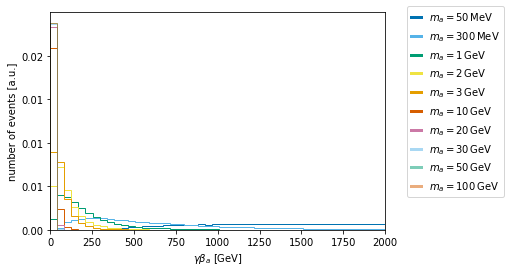

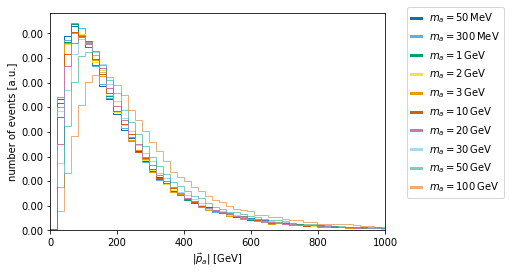

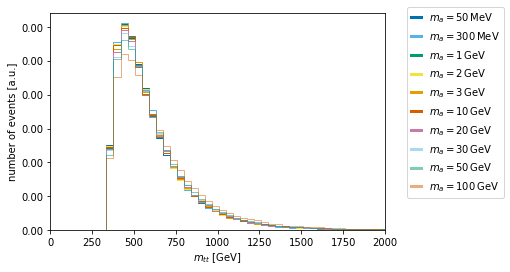

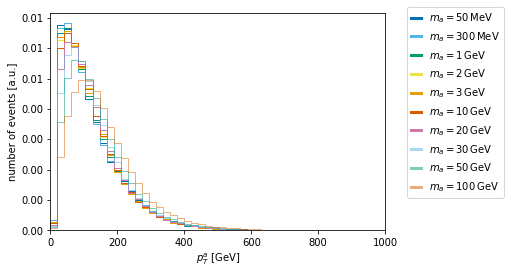

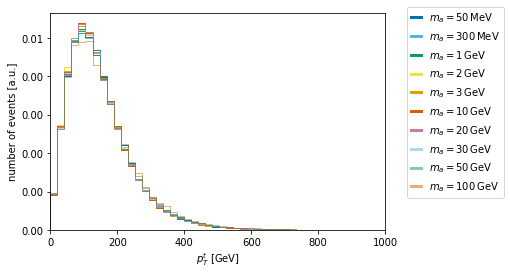

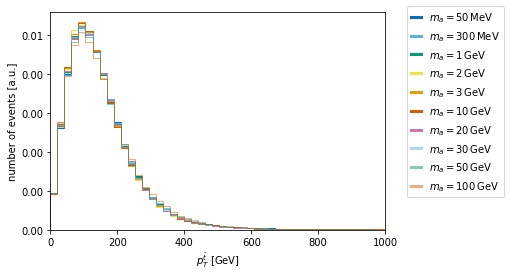

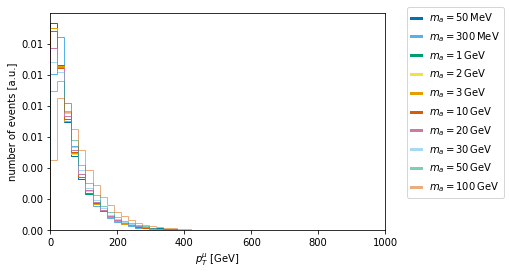

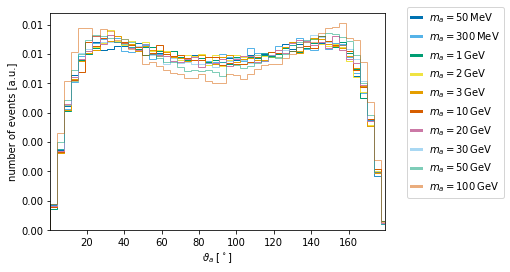

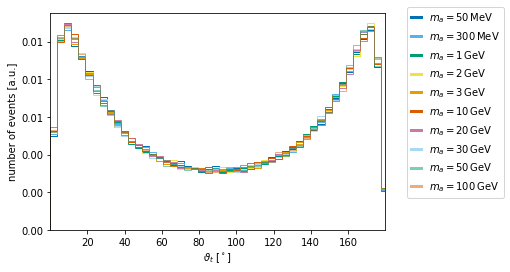

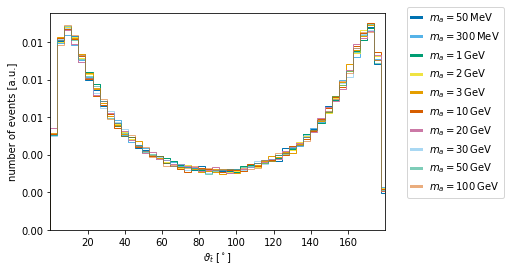

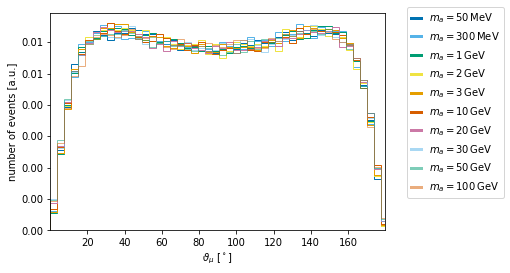

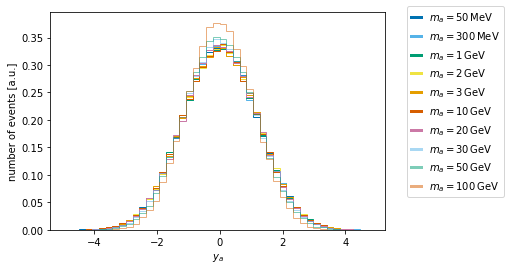

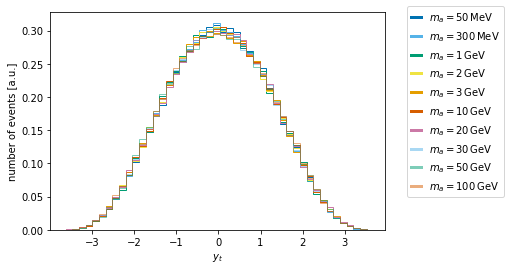

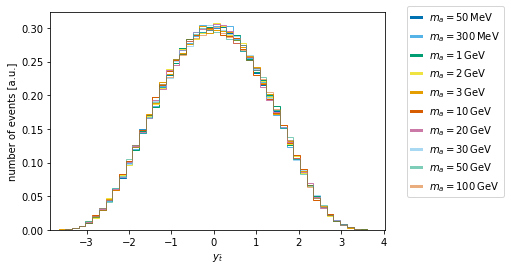

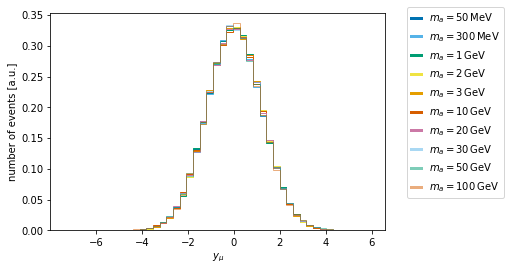

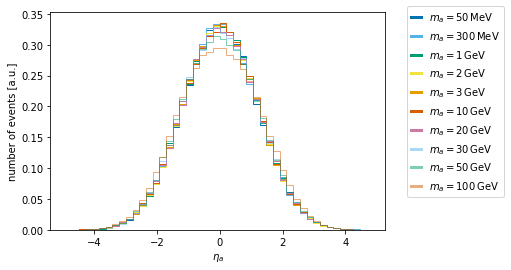

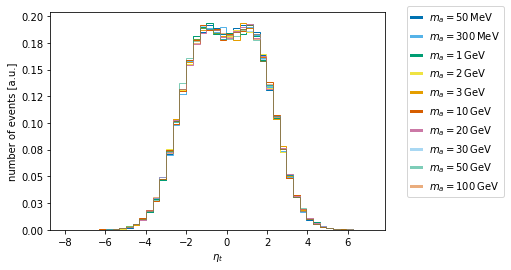

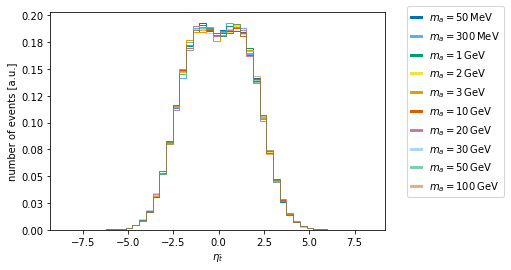

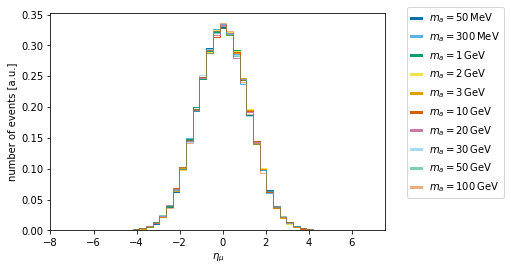

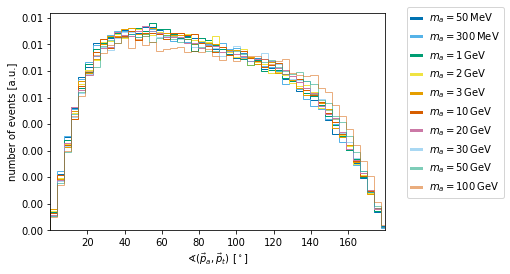

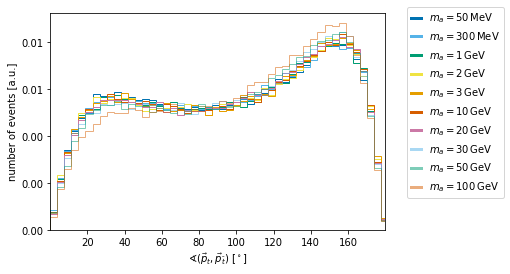

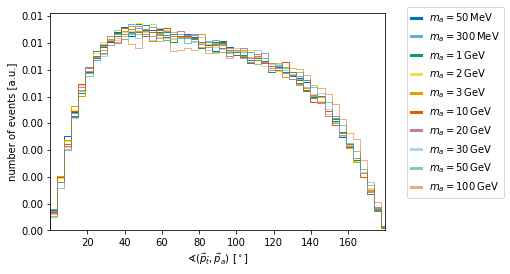

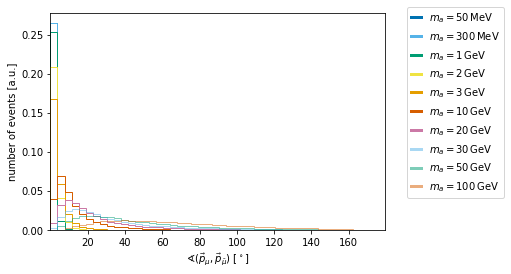

In [43]:
# kinematics of the inclusive signal events
mypl.hist1d(data("boost",["alp"],"incl"),massLabels,dirLabel["boost_a"],outputpath+"ALP_boost.png",customXlim=[0,2000])
mypl.hist1d(data("p3",["alp"],"incl"),massLabels,dirLabel["abs3mom_a"],outputpath+"ALP_3mom.png",customXlim=[0,1000])
mypl.hist1d(data("inv_mass",["top","antitop"],"incl"),massLabels,dirLabel["mtt"],outputpath+"mtt.png",customXlim=[0,2000])
mypl.hist1d(data("pT",["alp"],"incl"),massLabels,dirLabel["pT_a"],outputpath+"ALP_pT.png",customXlim=[0,1000])
mypl.hist1d(data("pT",["top"],"incl"),massLabels,dirLabel["pT_t"],outputpath+"Top_pT.png",customXlim=[0,1000])
mypl.hist1d(data("pT",["antitop"],"incl"),massLabels,dirLabel["pT_at"],outputpath+"AntiTop_pT.png",customXlim=[0,1000])
mypl.hist1d(data("pT",["muon"],"incl"),massLabels,dirLabel["pT_mu"],outputpath+"Muon_pT.png",customXlim=[0,1000])
mypl.hist1d(data("theta",["alp"],"incl"),massLabels,dirLabel["theta_a"],outputpath+"ALP_theta.png")
mypl.hist1d(data("theta",["top"],"incl"),massLabels,dirLabel["theta_t"],outputpath+"Top_theta.png")
mypl.hist1d(data("theta",["antitop"],"incl"),massLabels,dirLabel["theta_at"],outputpath+"AntiTop_theta.png")
mypl.hist1d(data("theta",["muon"],"incl"),massLabels,dirLabel["theta_mu"],outputpath+"Muon_theta.png")
mypl.hist1d(data("y",["alp"],"incl"),massLabels,dirLabel["y_a"],outputpath+"ALP_rapidity.png")
mypl.hist1d(data("y",["top"],"incl"),massLabels,dirLabel["y_t"],outputpath+"Top_rapidity.png")
mypl.hist1d(data("y",["antitop"],"incl"),massLabels,dirLabel["y_at"],outputpath+"AntiTop_rapidity.png")
mypl.hist1d(data("y",["muon"],"incl"),massLabels,dirLabel["y_mu"],outputpath+"Muon_rapidity.png")
mypl.hist1d(data("eta",["alp"],"incl"),massLabels,dirLabel["eta_a"],outputpath+"ALP_pseudorapidity.png")
mypl.hist1d(data("eta",["top"],"incl"),massLabels,dirLabel["eta_t"],outputpath+"Top_pseudorapidity.png")
mypl.hist1d(data("eta",["antitop"],"incl"),massLabels,dirLabel["eta_at"],outputpath+"AntiTop_pseudorapidity.png")
mypl.hist1d(data("eta",["muon"],"incl"),massLabels,dirLabel["eta_mu"],outputpath+"Muon_pseudorapidity.png")
mypl.hist1d(data("oA",["alp","top"],"incl"),massLabels,dirLabel["oA_at"],outputpath+"Angle_ALPTop.png")
mypl.hist1d(data("oA",["top","antitop"],"incl"),massLabels,dirLabel["oA_tat"],outputpath+"Angle_TopAntiTop.png")
mypl.hist1d(data("oA",["antitop","alp"],"incl"),massLabels,dirLabel["oA_ata"],outputpath+"Angle_AntiTopALP.png")
mypl.hist1d(data("oA",["muon","antimuon"],"incl"),massLabels,dirLabel["oA_muons"],outputpath+"Angle_Muons.png")

In [18]:
labels_cwb = [r'inclusive $t\bar{t}$',r'boosted $t\bar{t}$']
#labels_cwboth = [r'inclusive $t\bar{t}$',r'boosted $t\bar{t}$',r'background $t\bar{t}\mu\bar{\mu}$']
labels_cwboth = [r'inclusive $t\bar{t}$',r'boosted $t\bar{t}$',r'background']
labels_bkg = [r'inclusive $t\bar{t}$',r'boosted $t\bar{t}$',r'background']

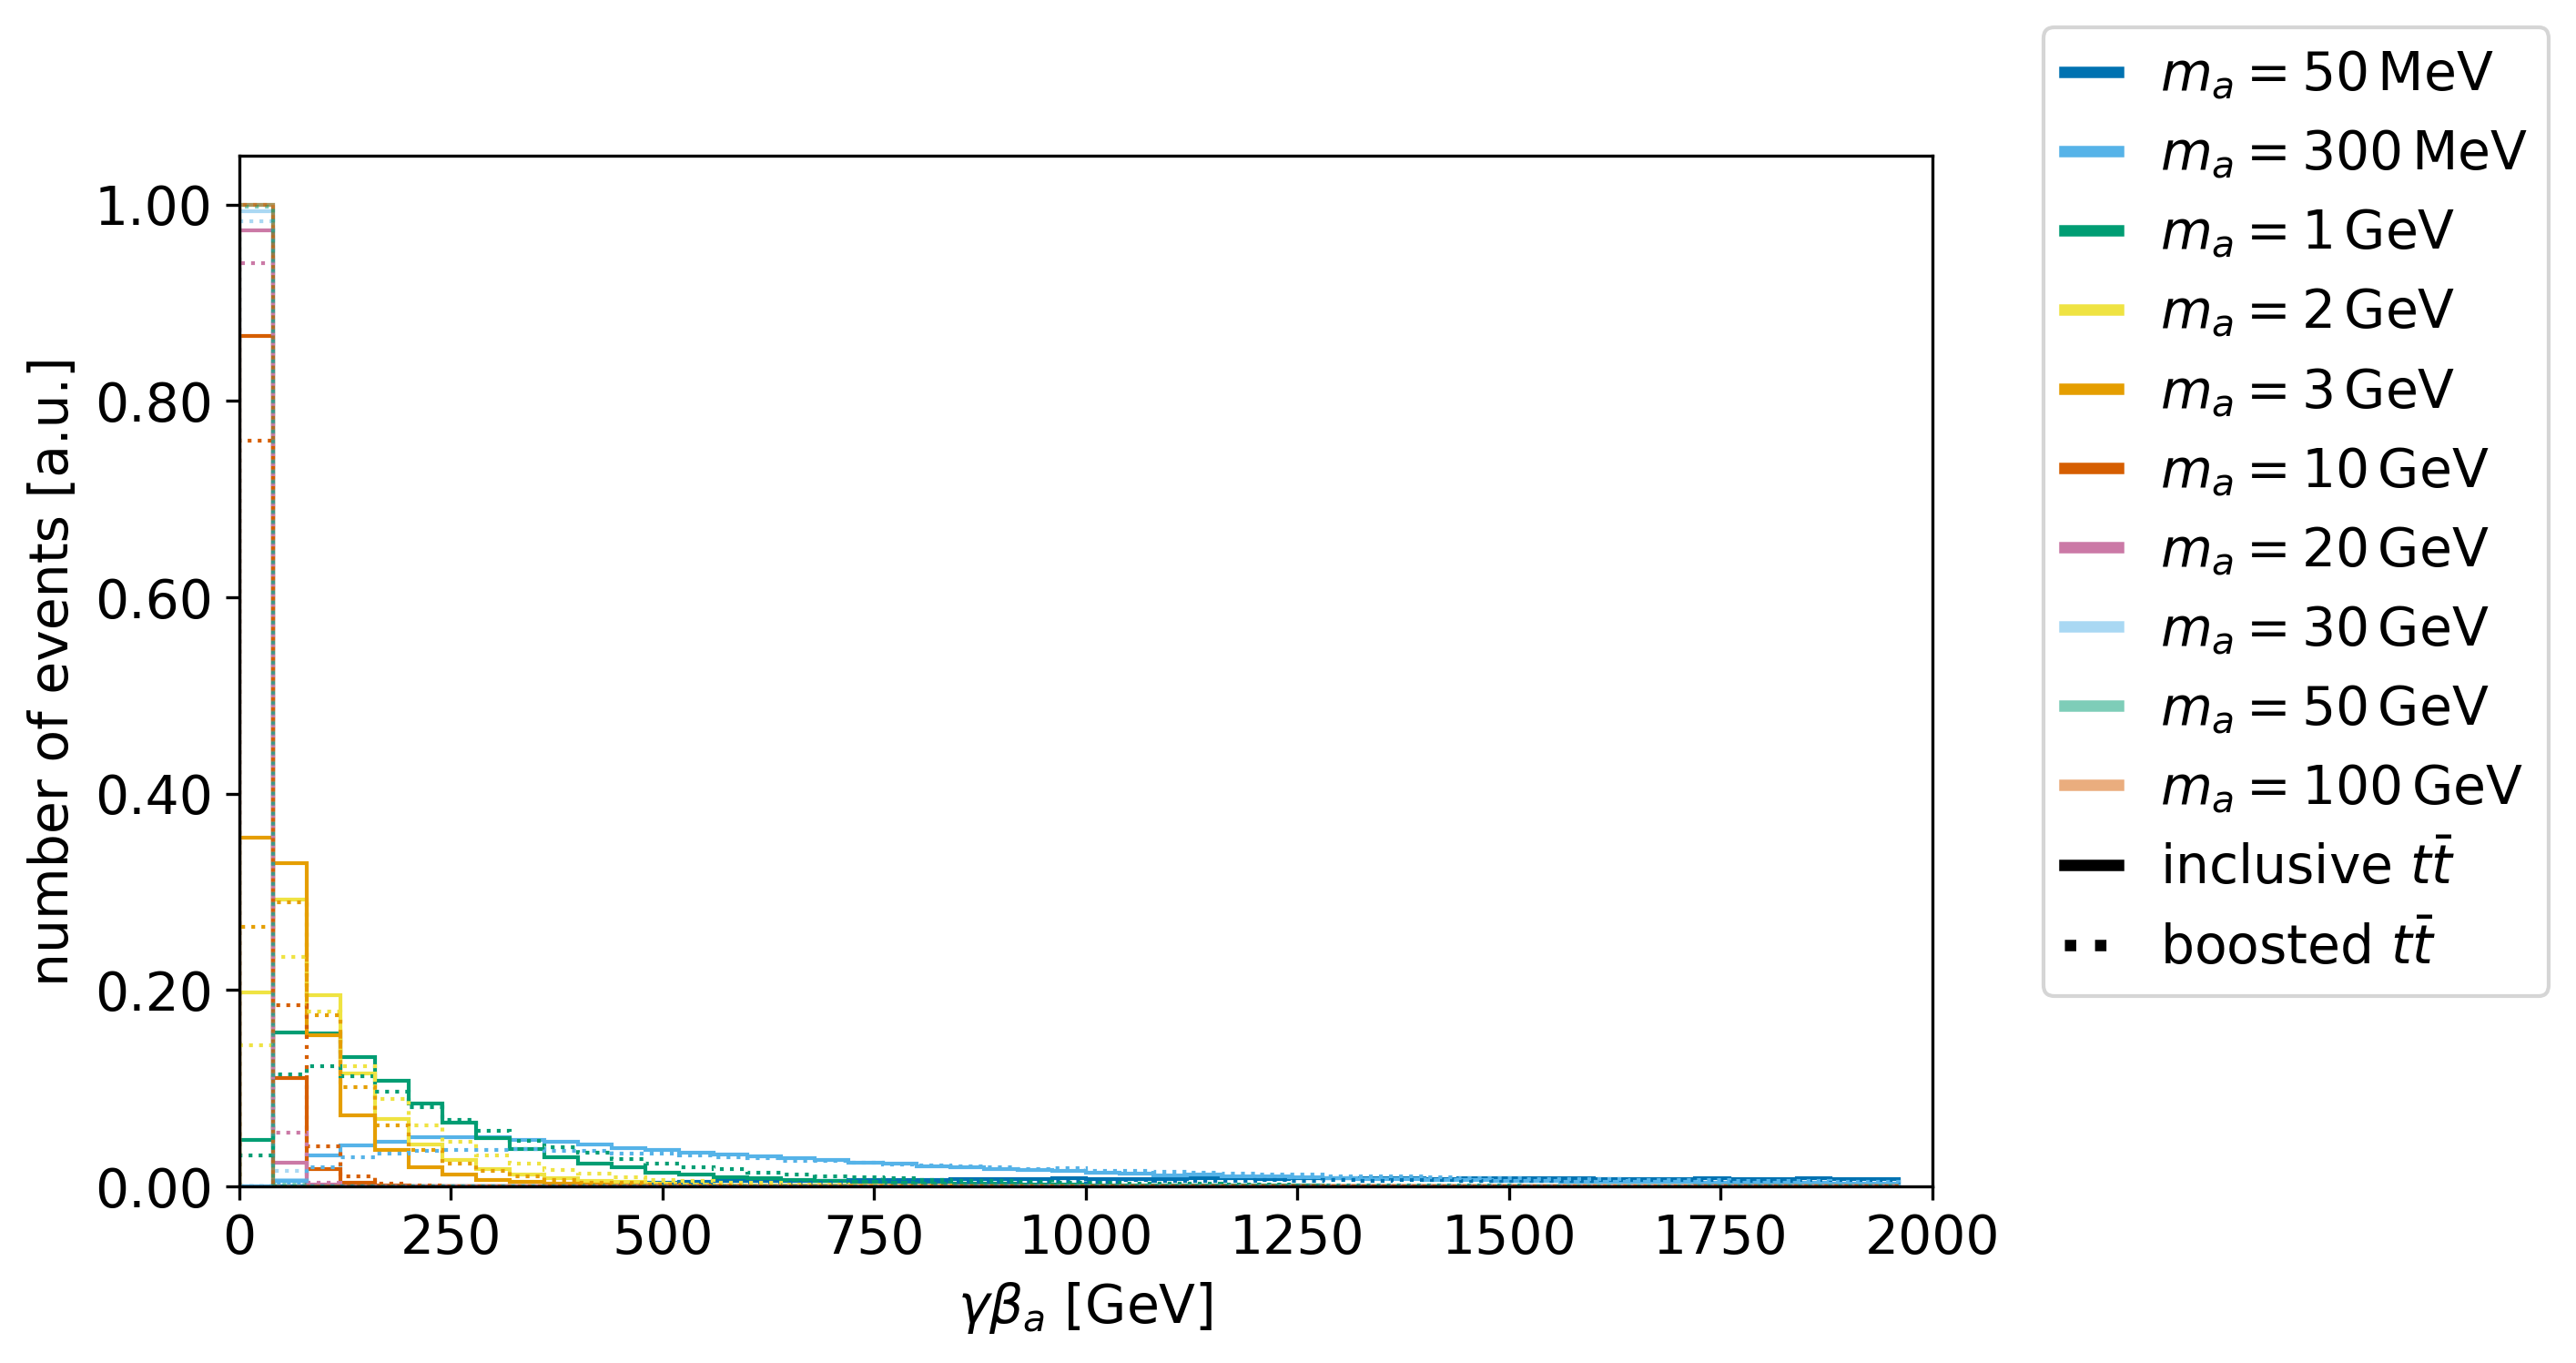

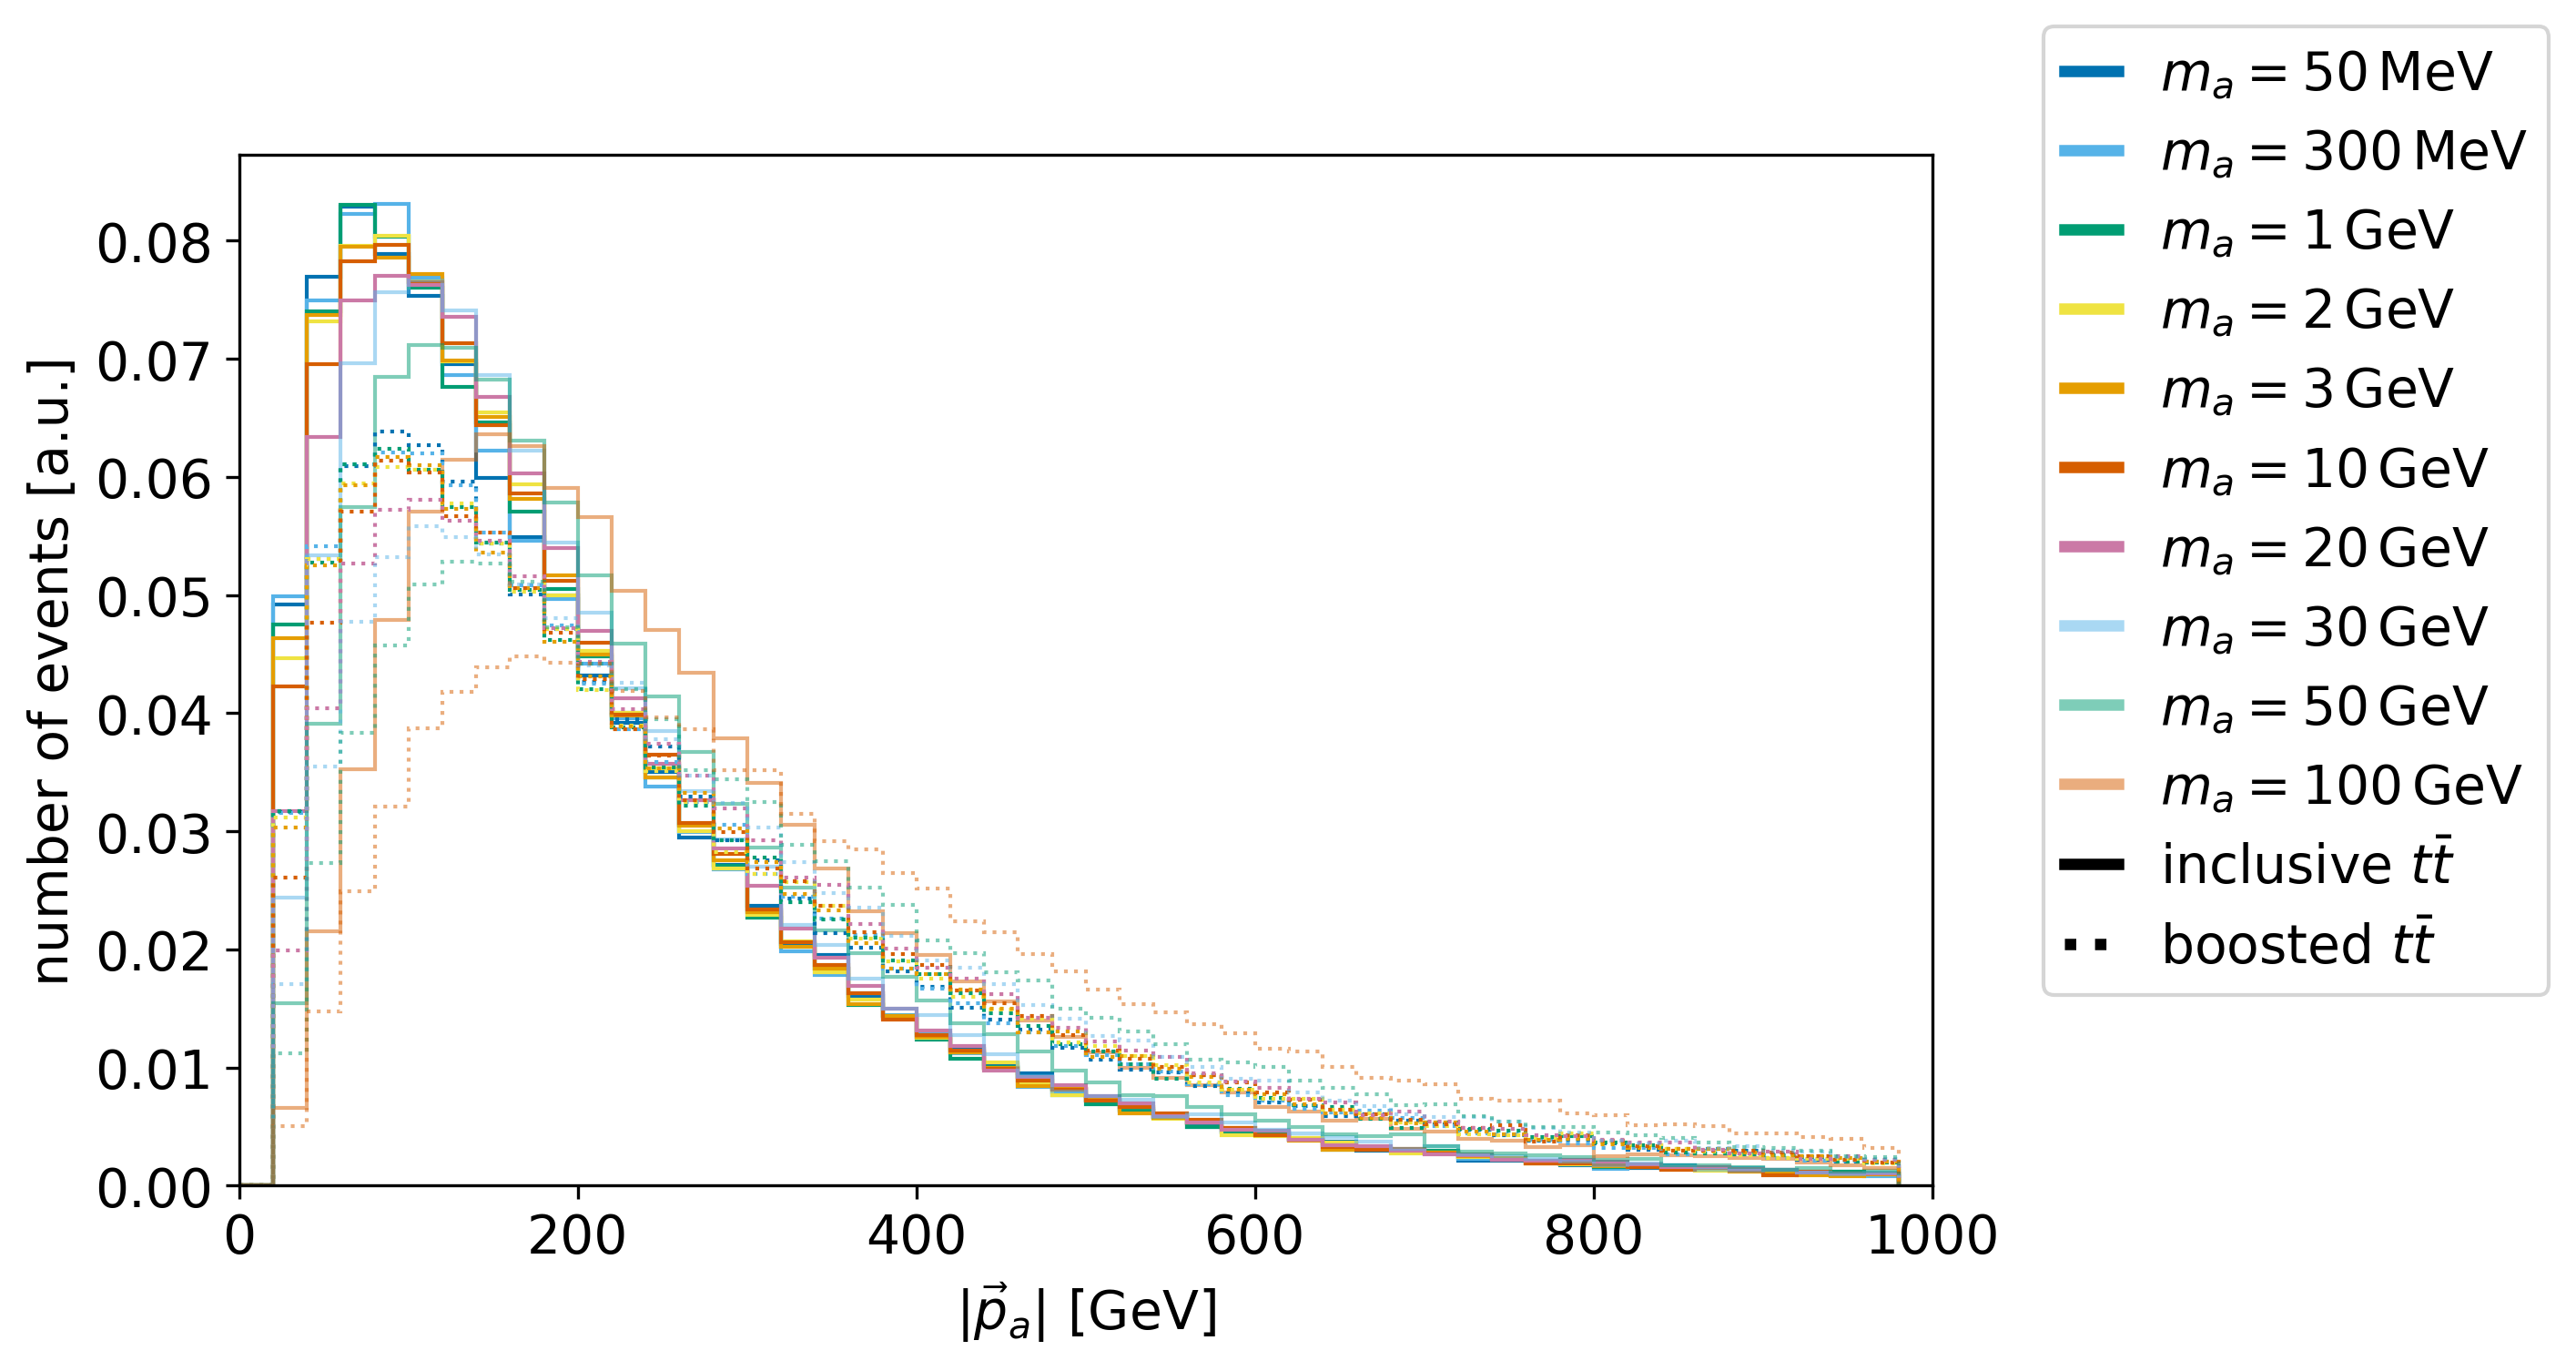

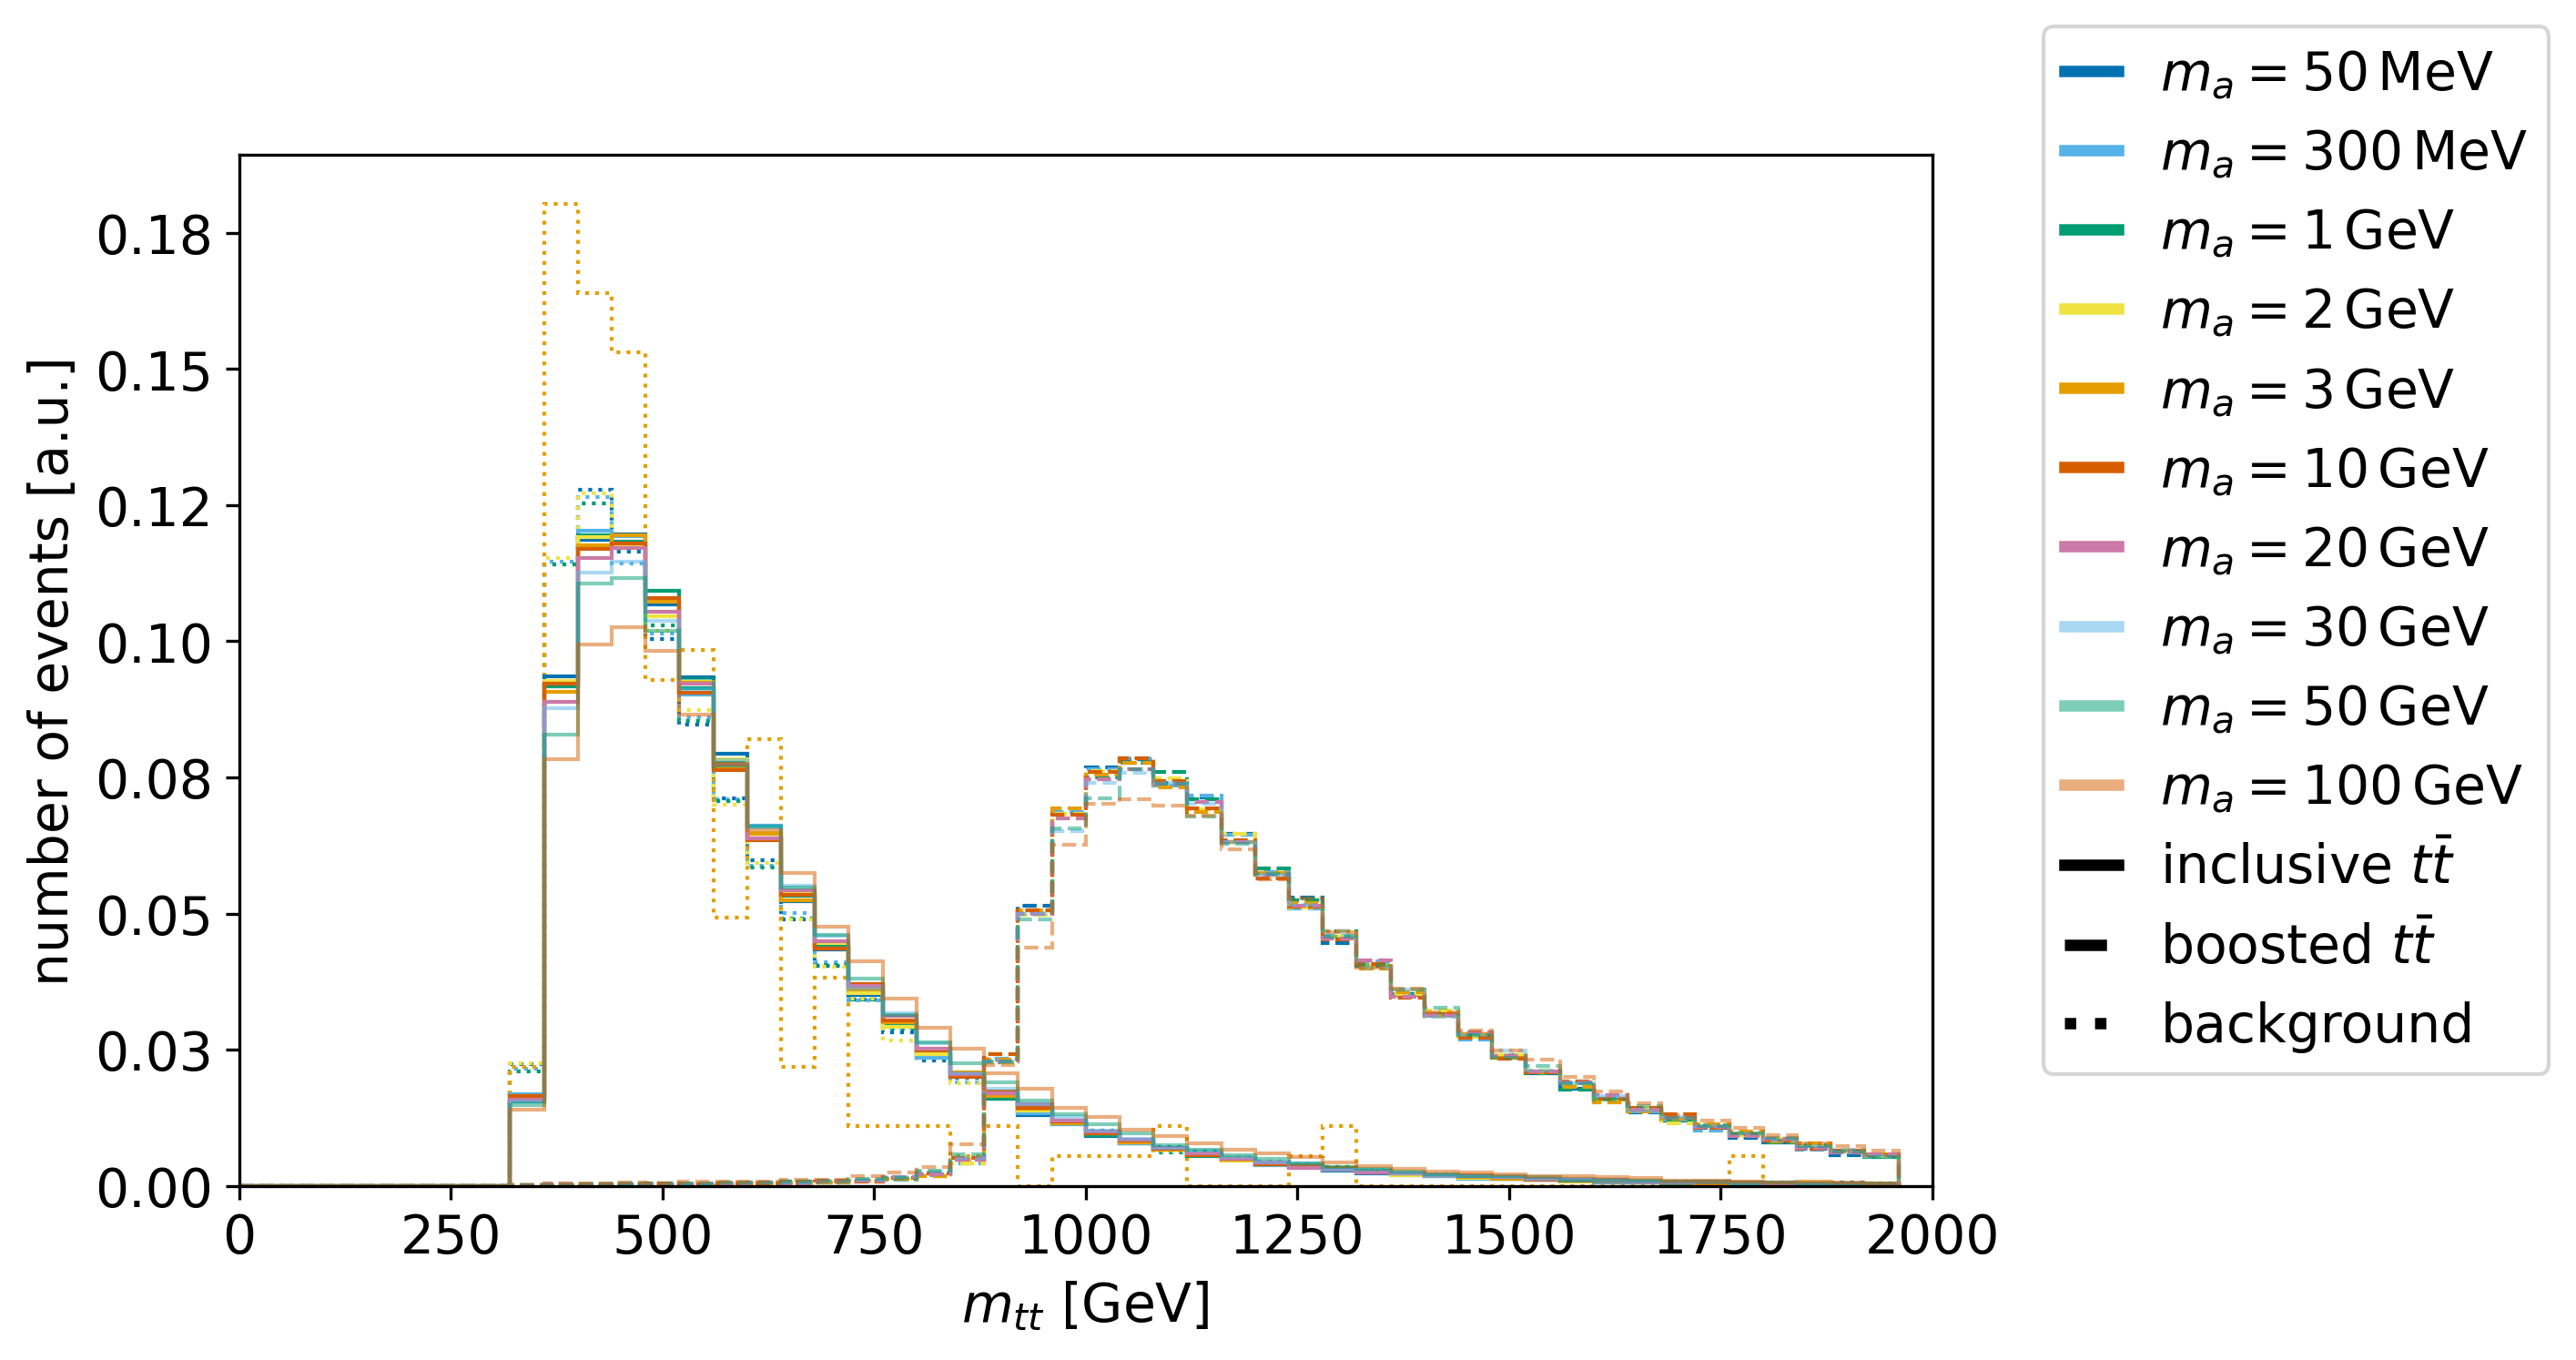

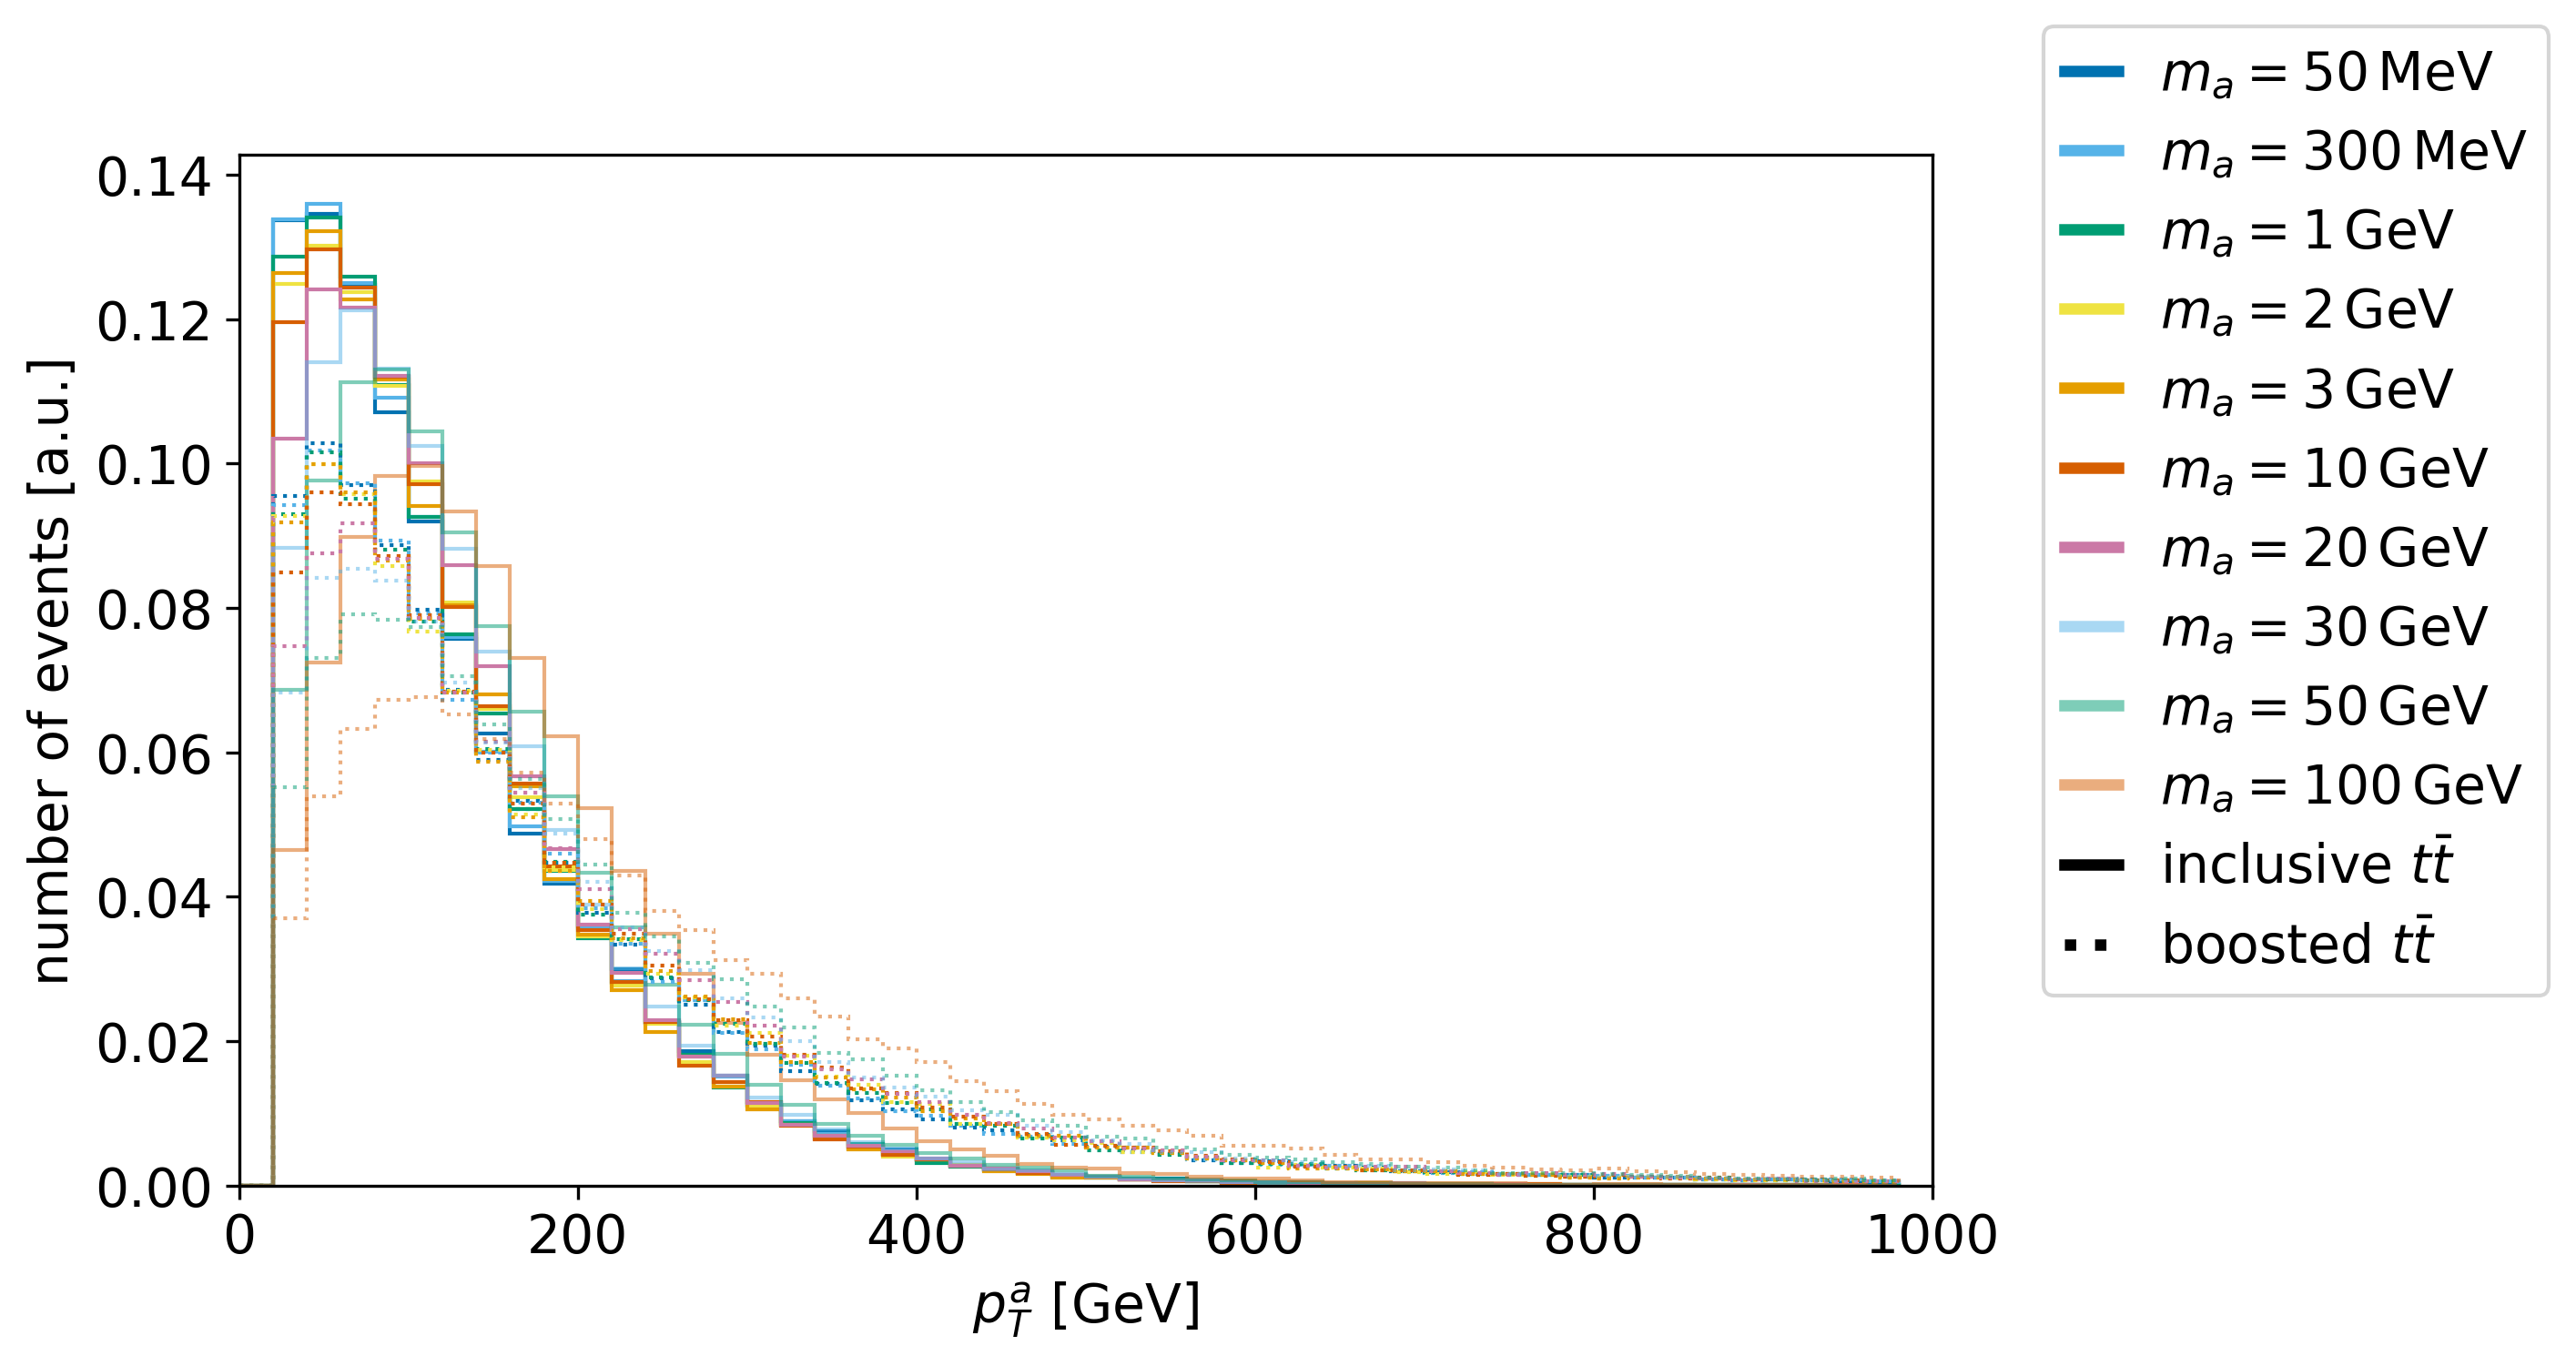

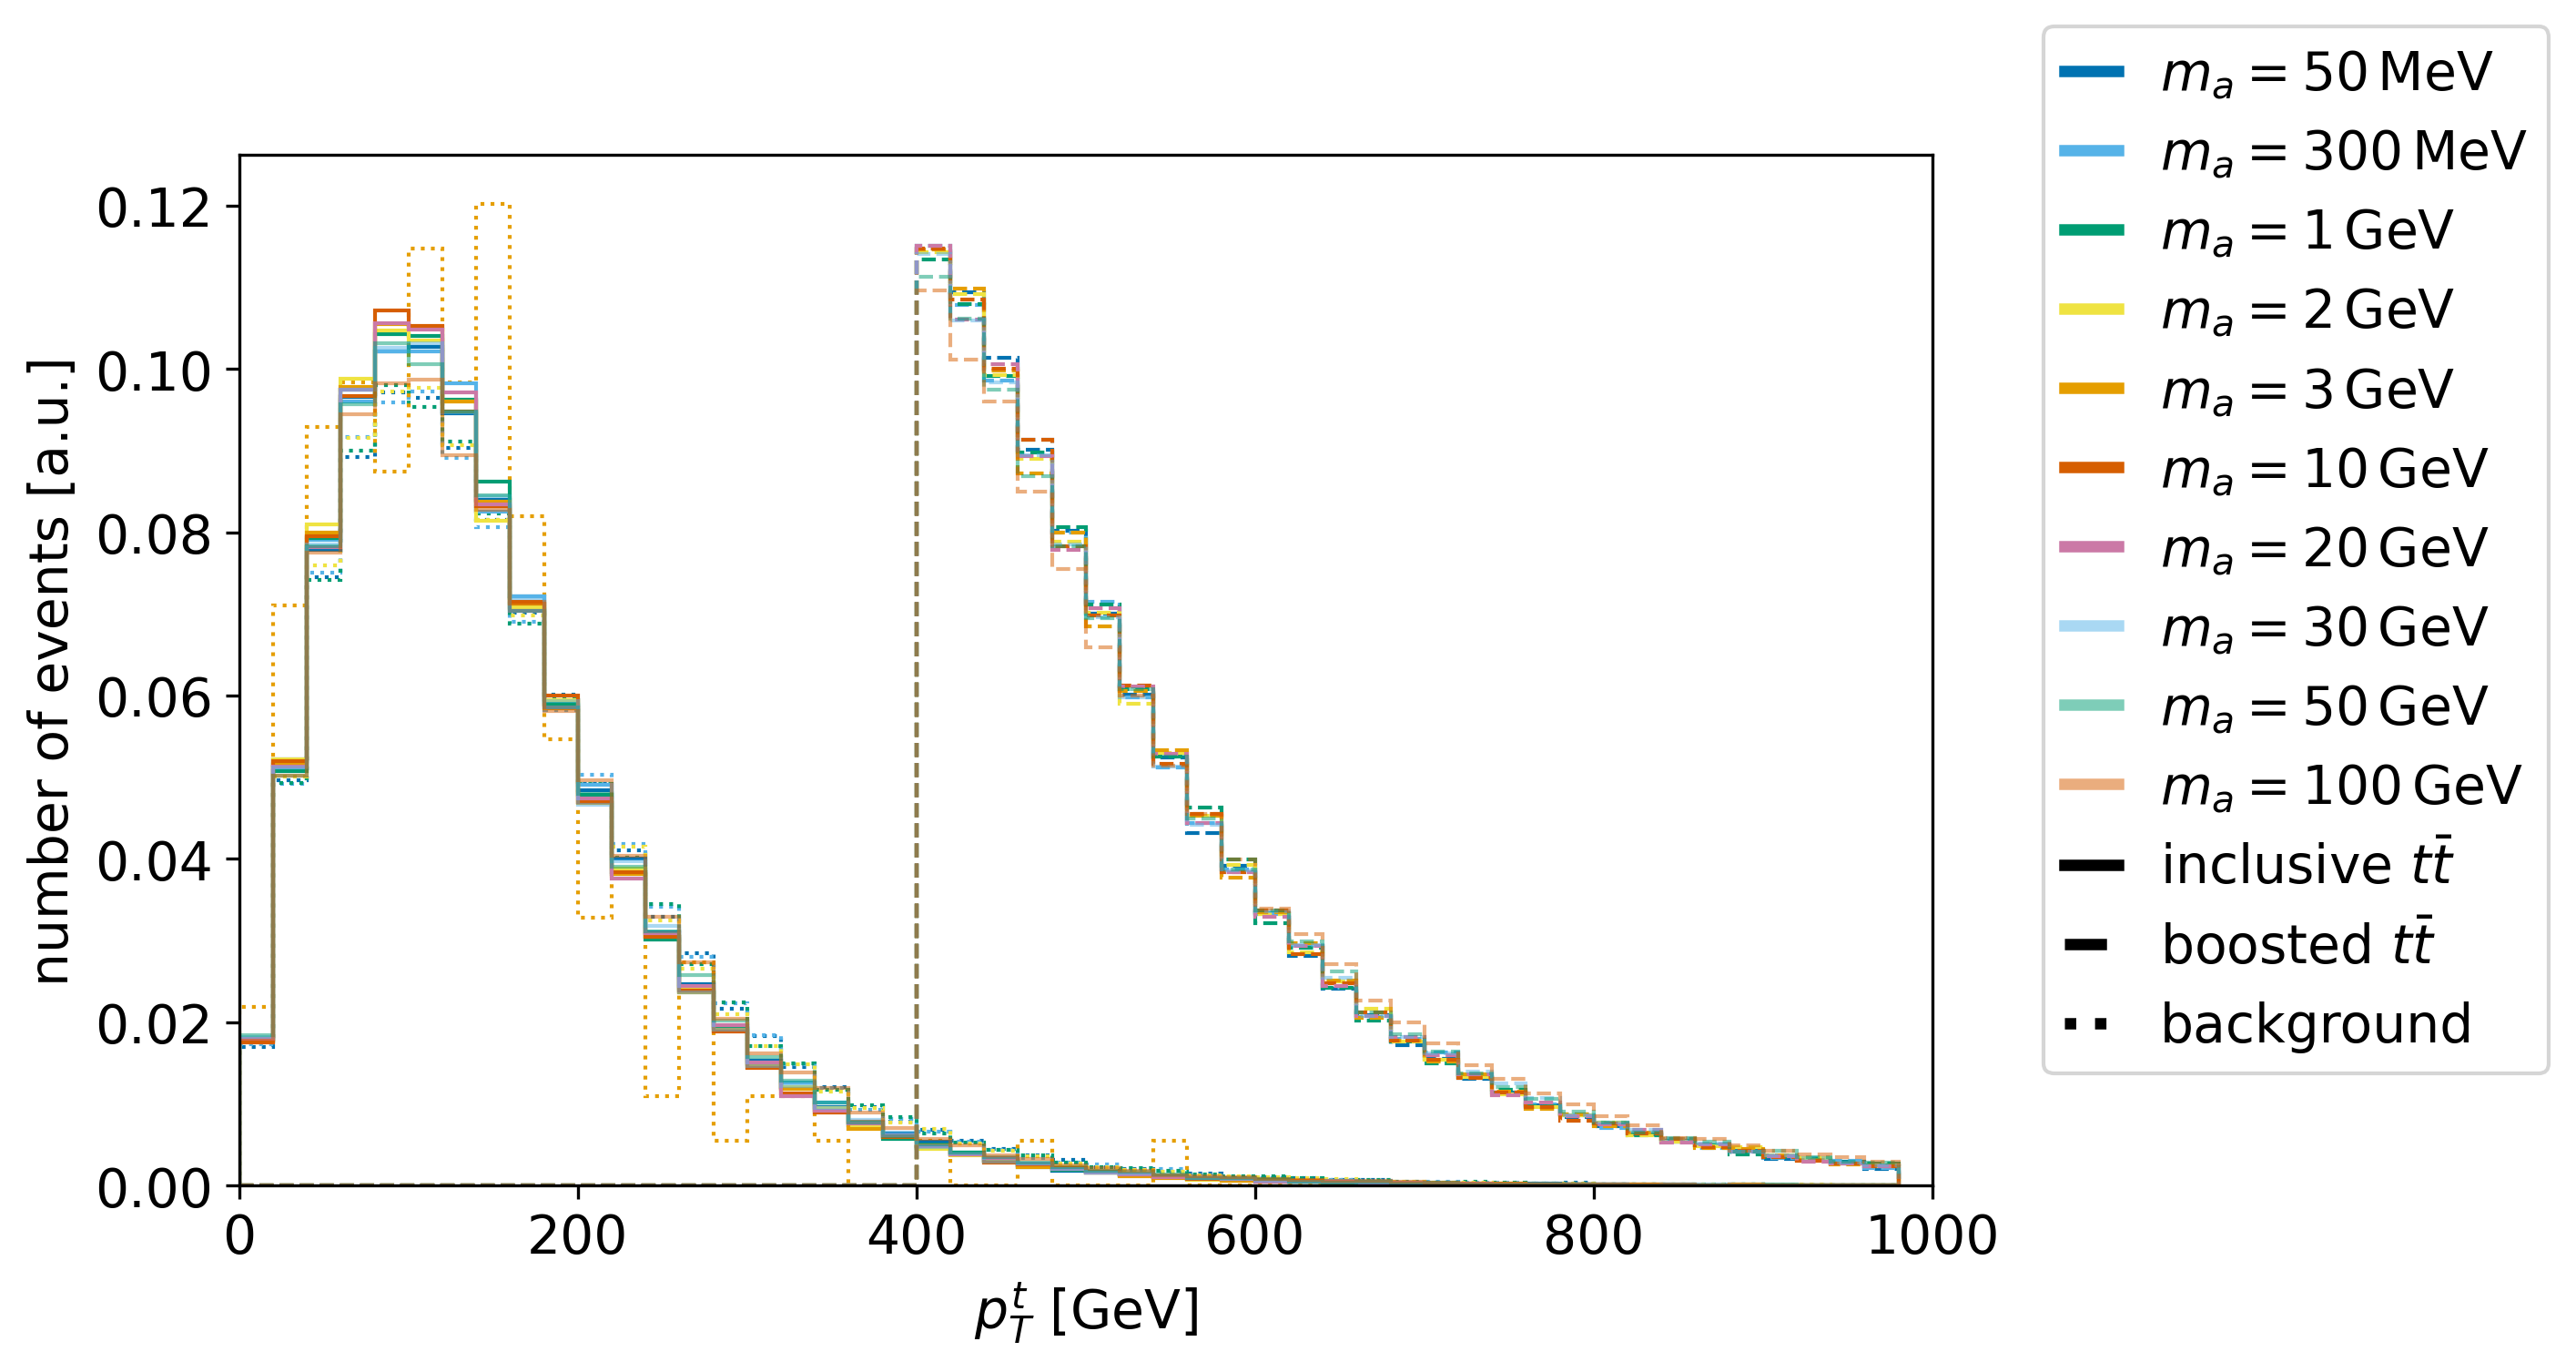

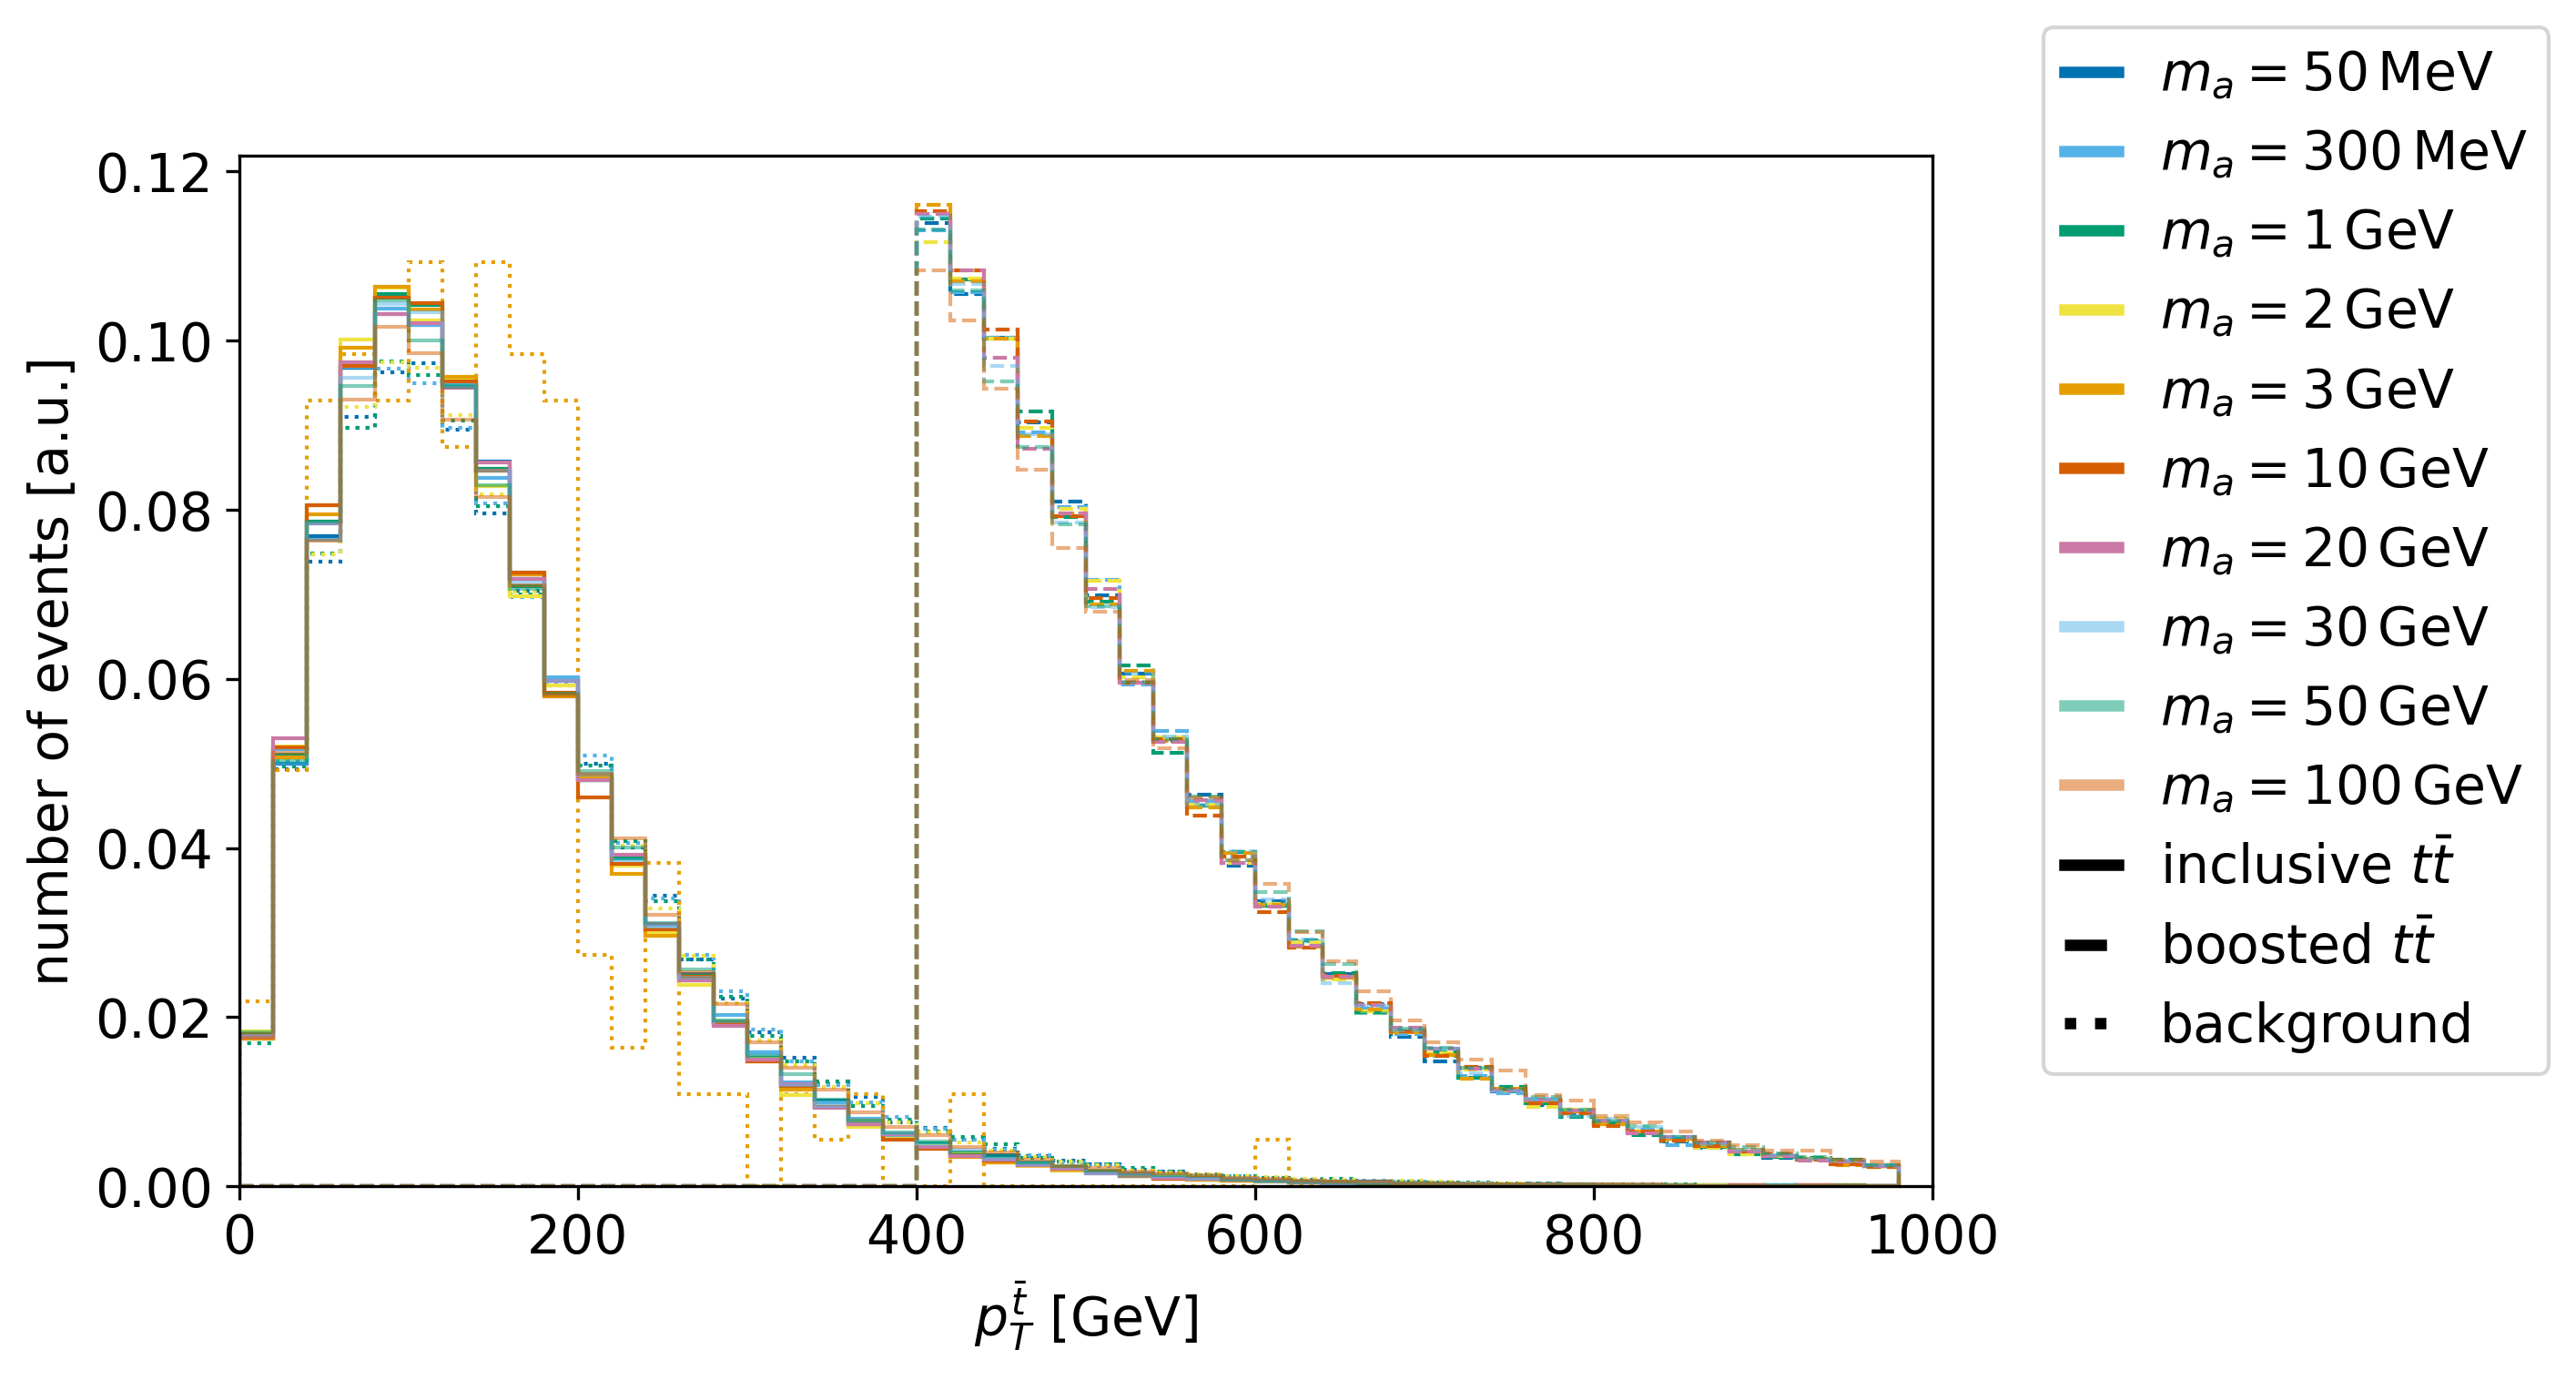

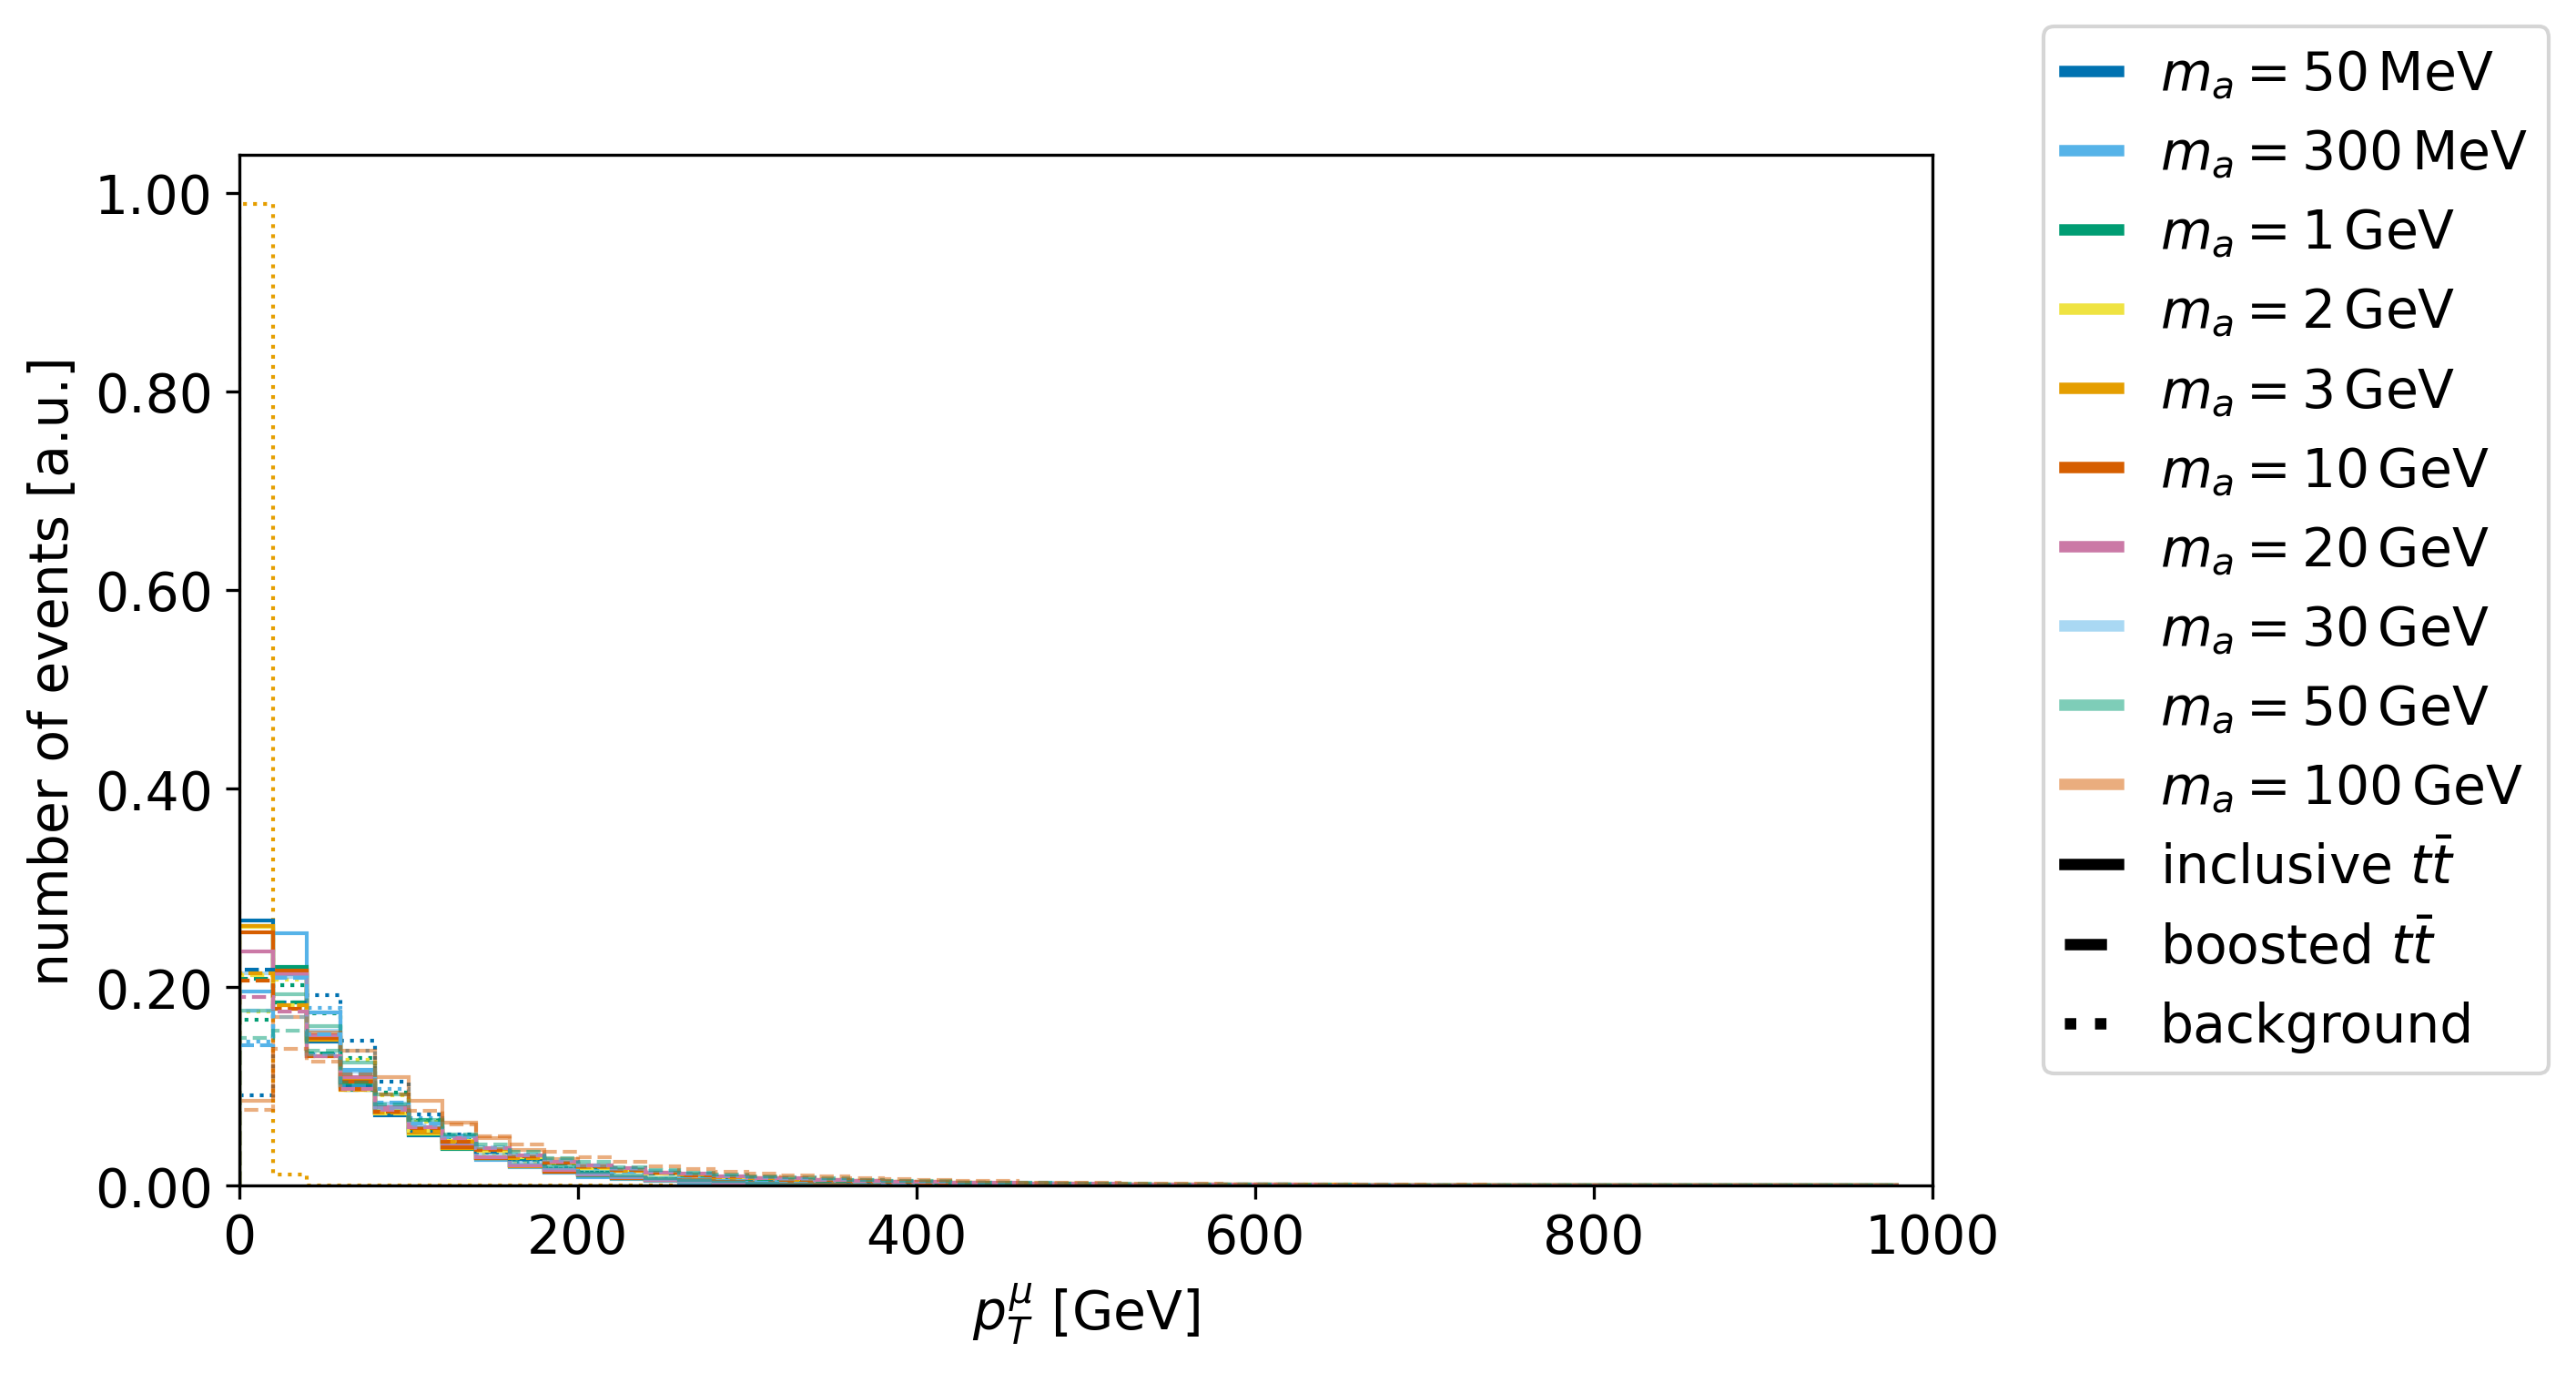

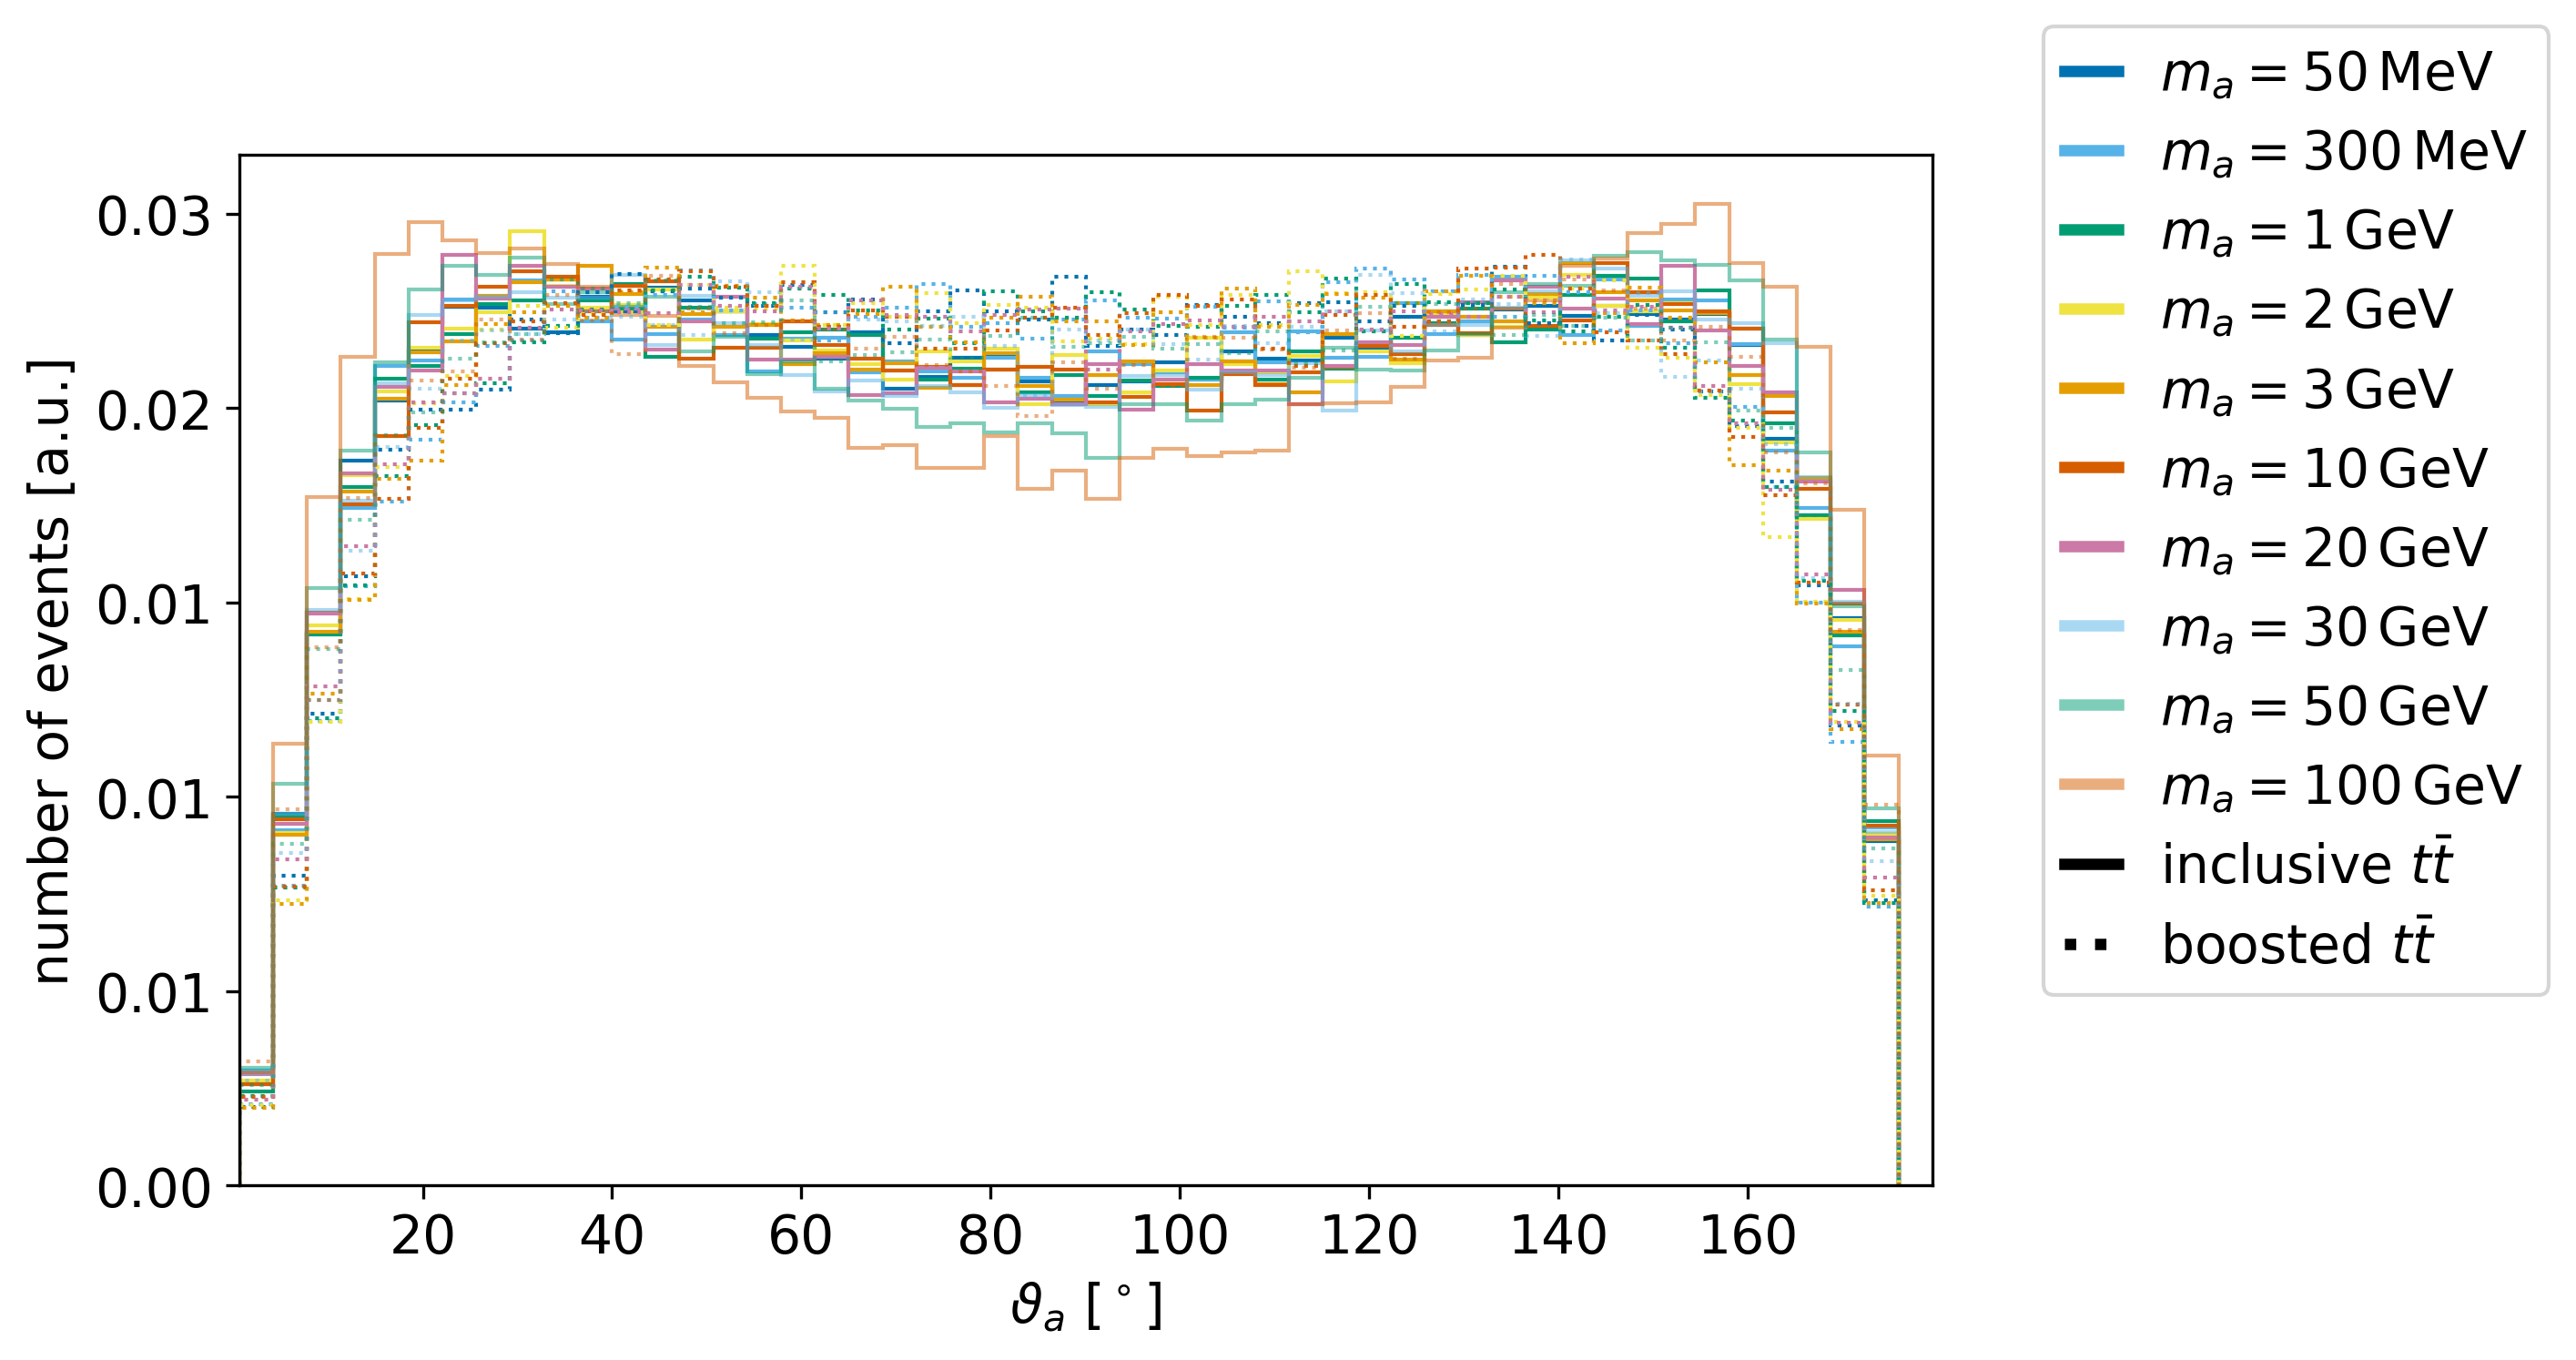

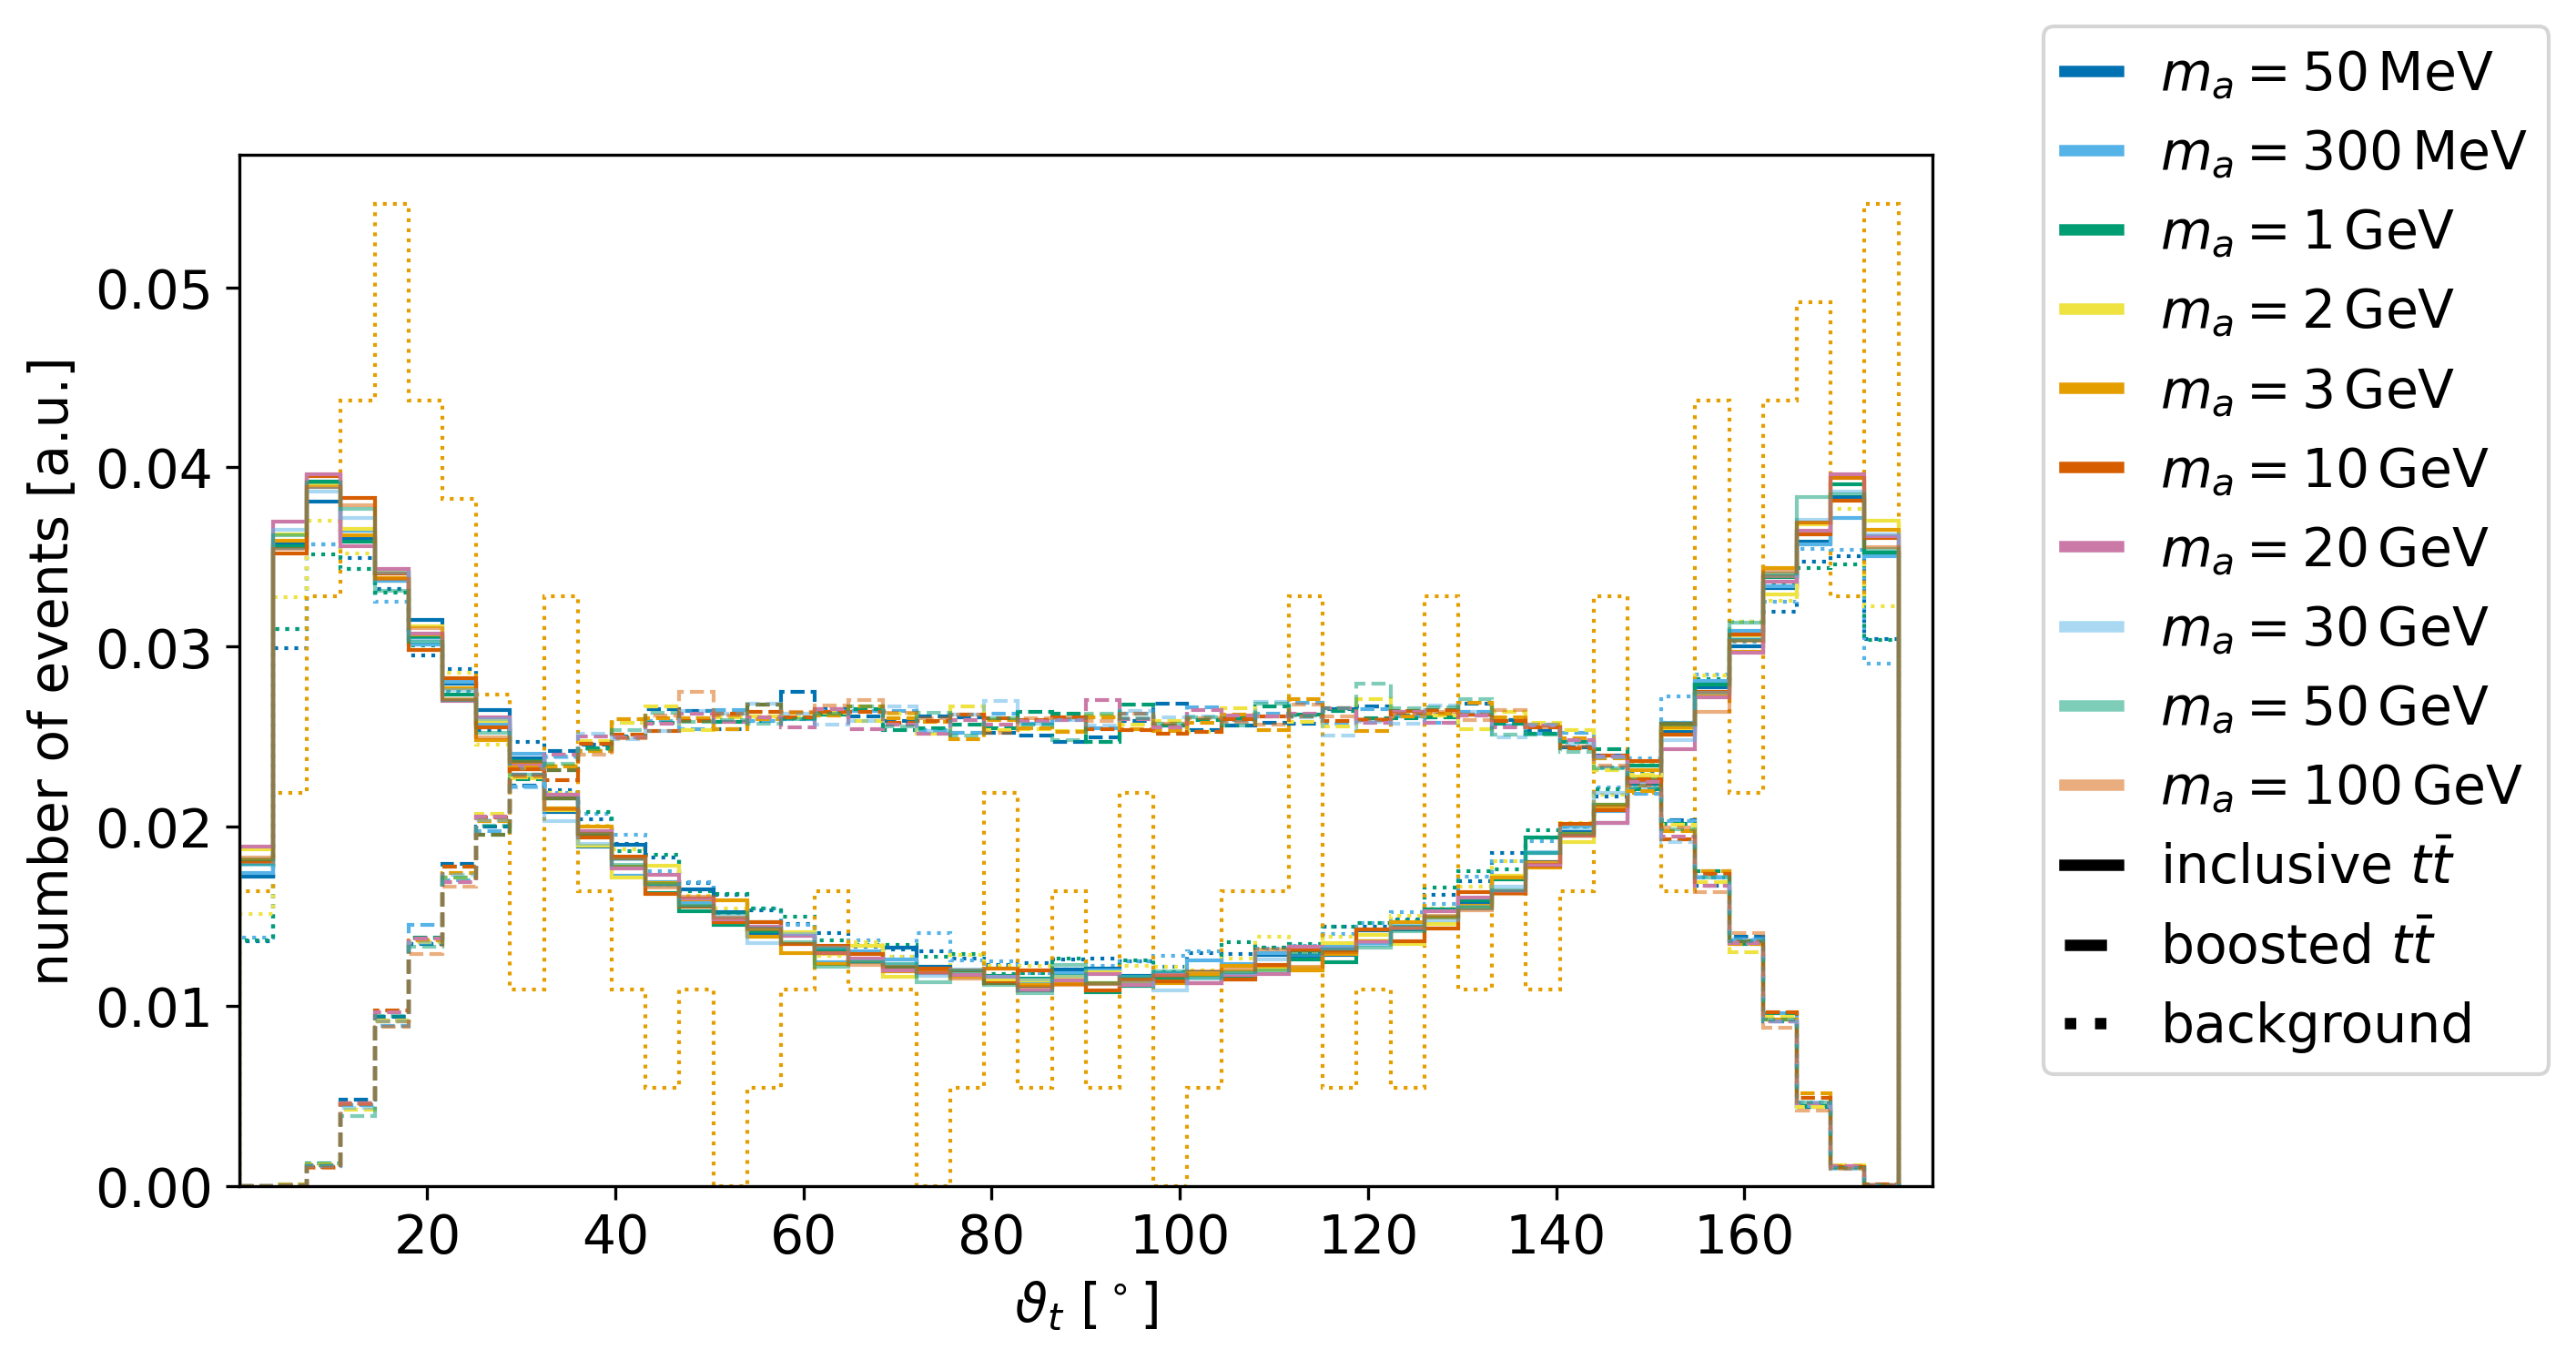

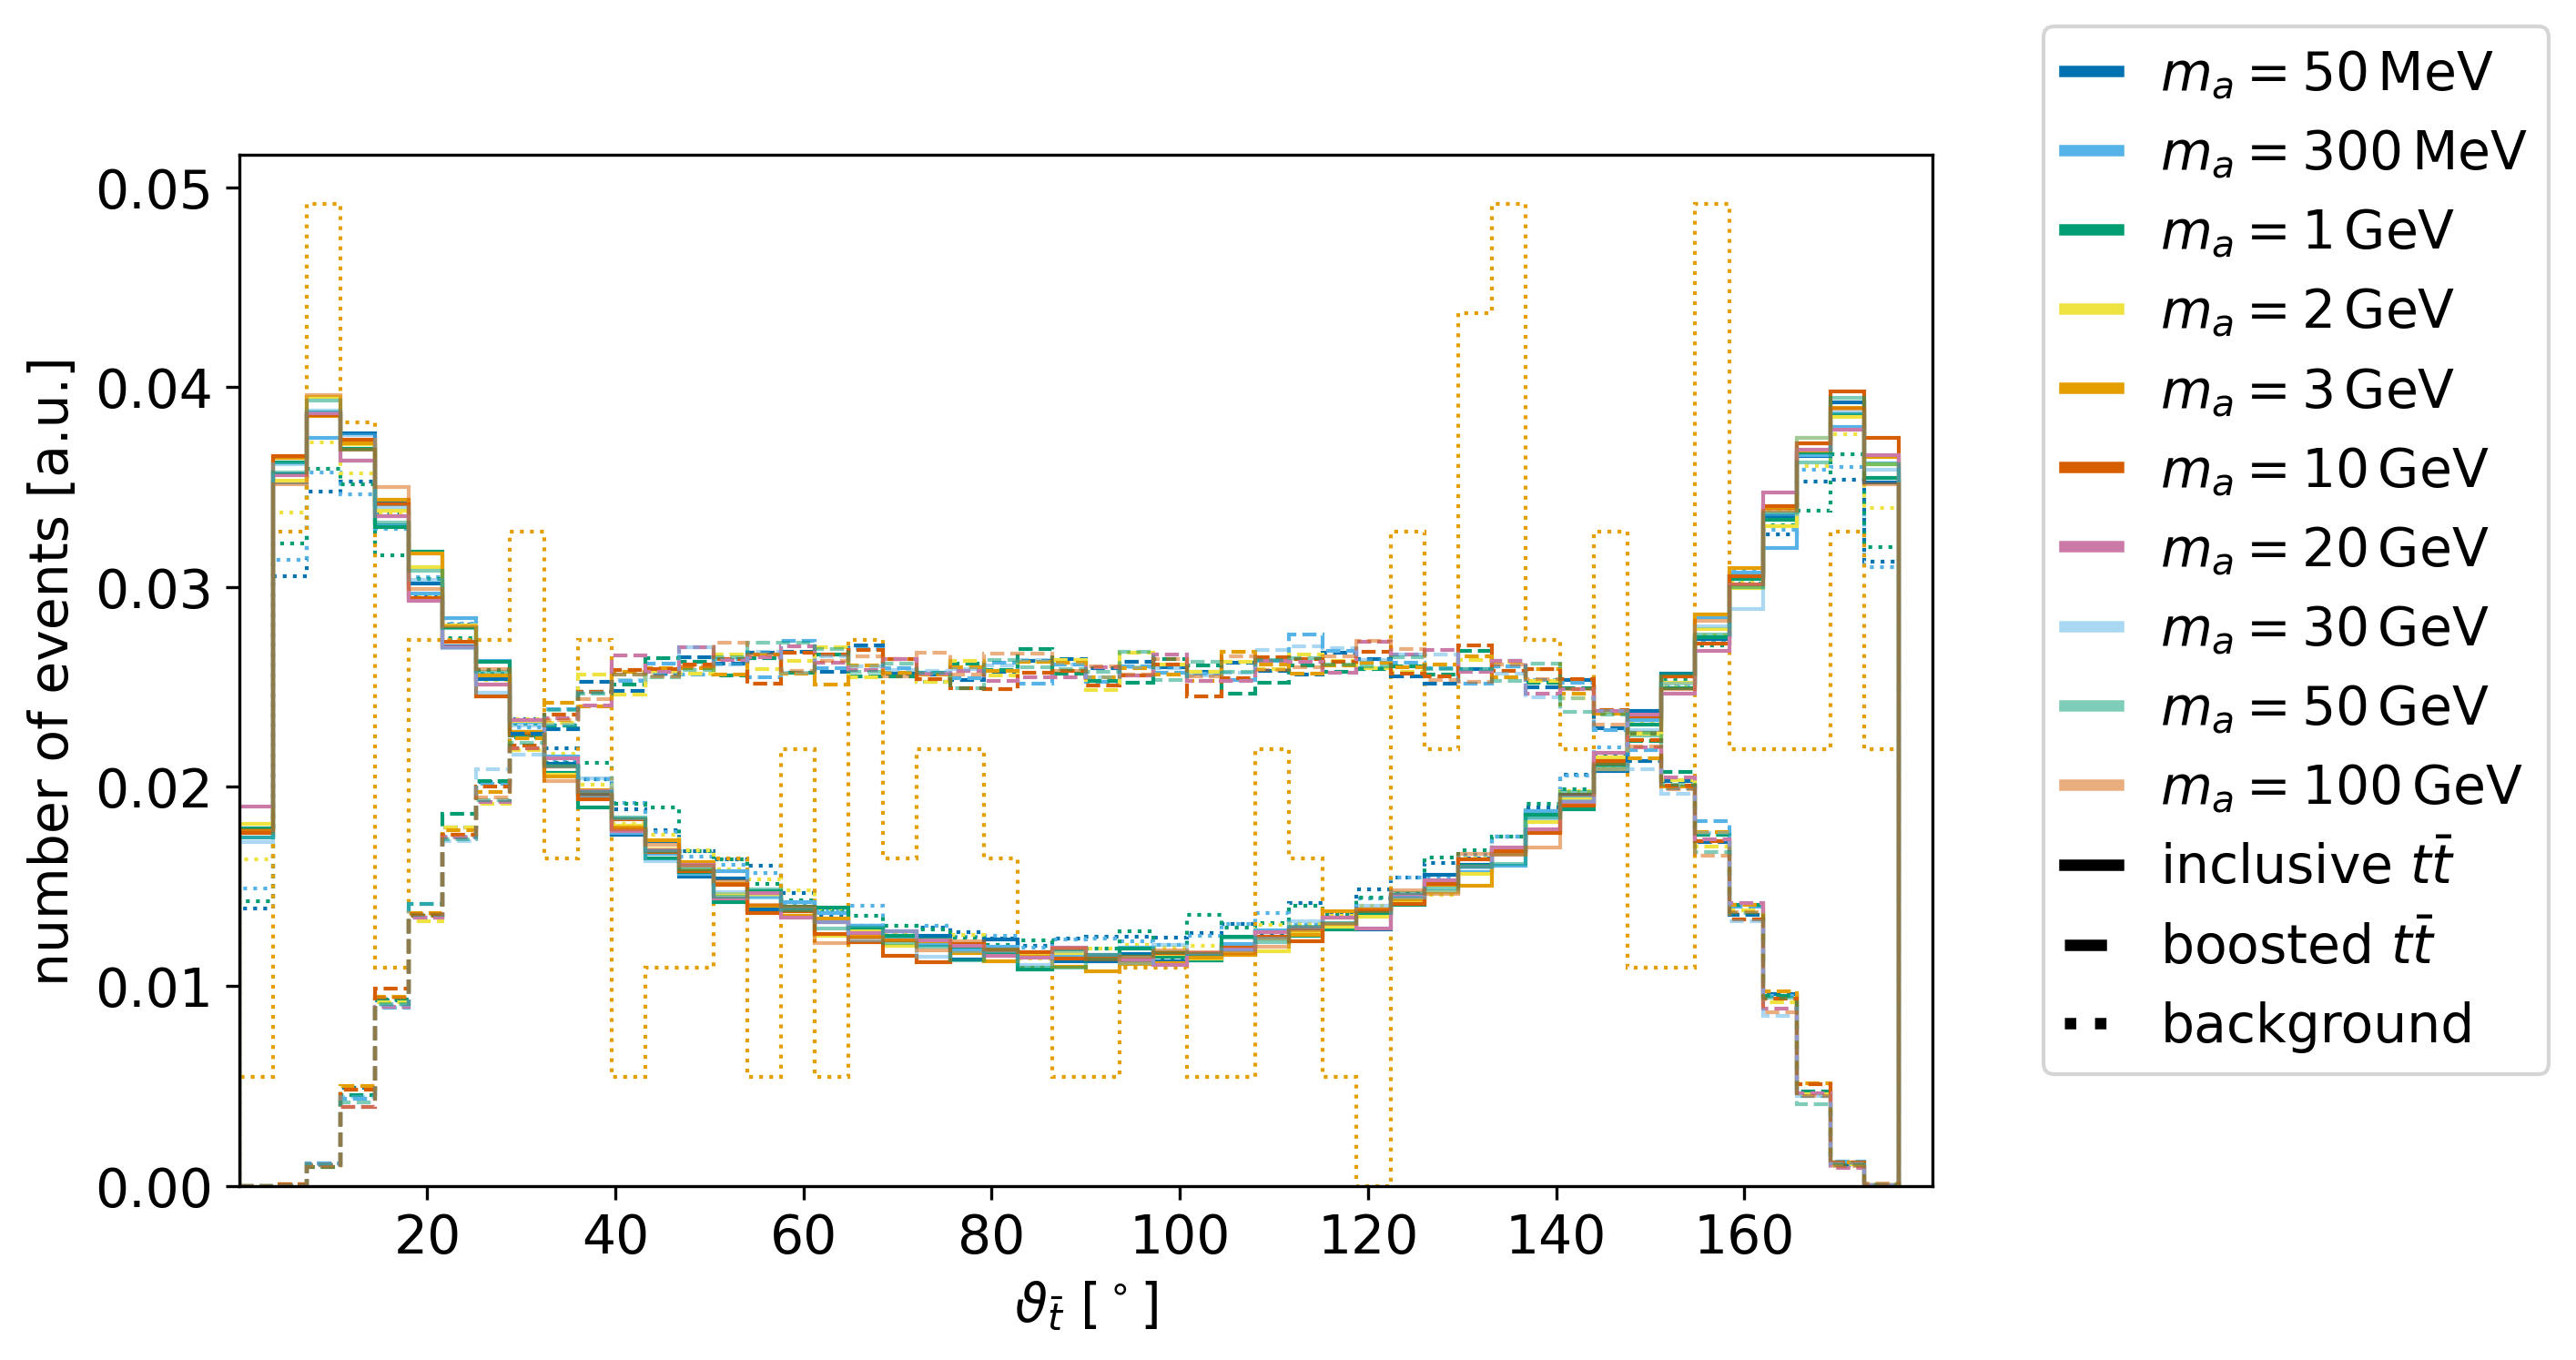

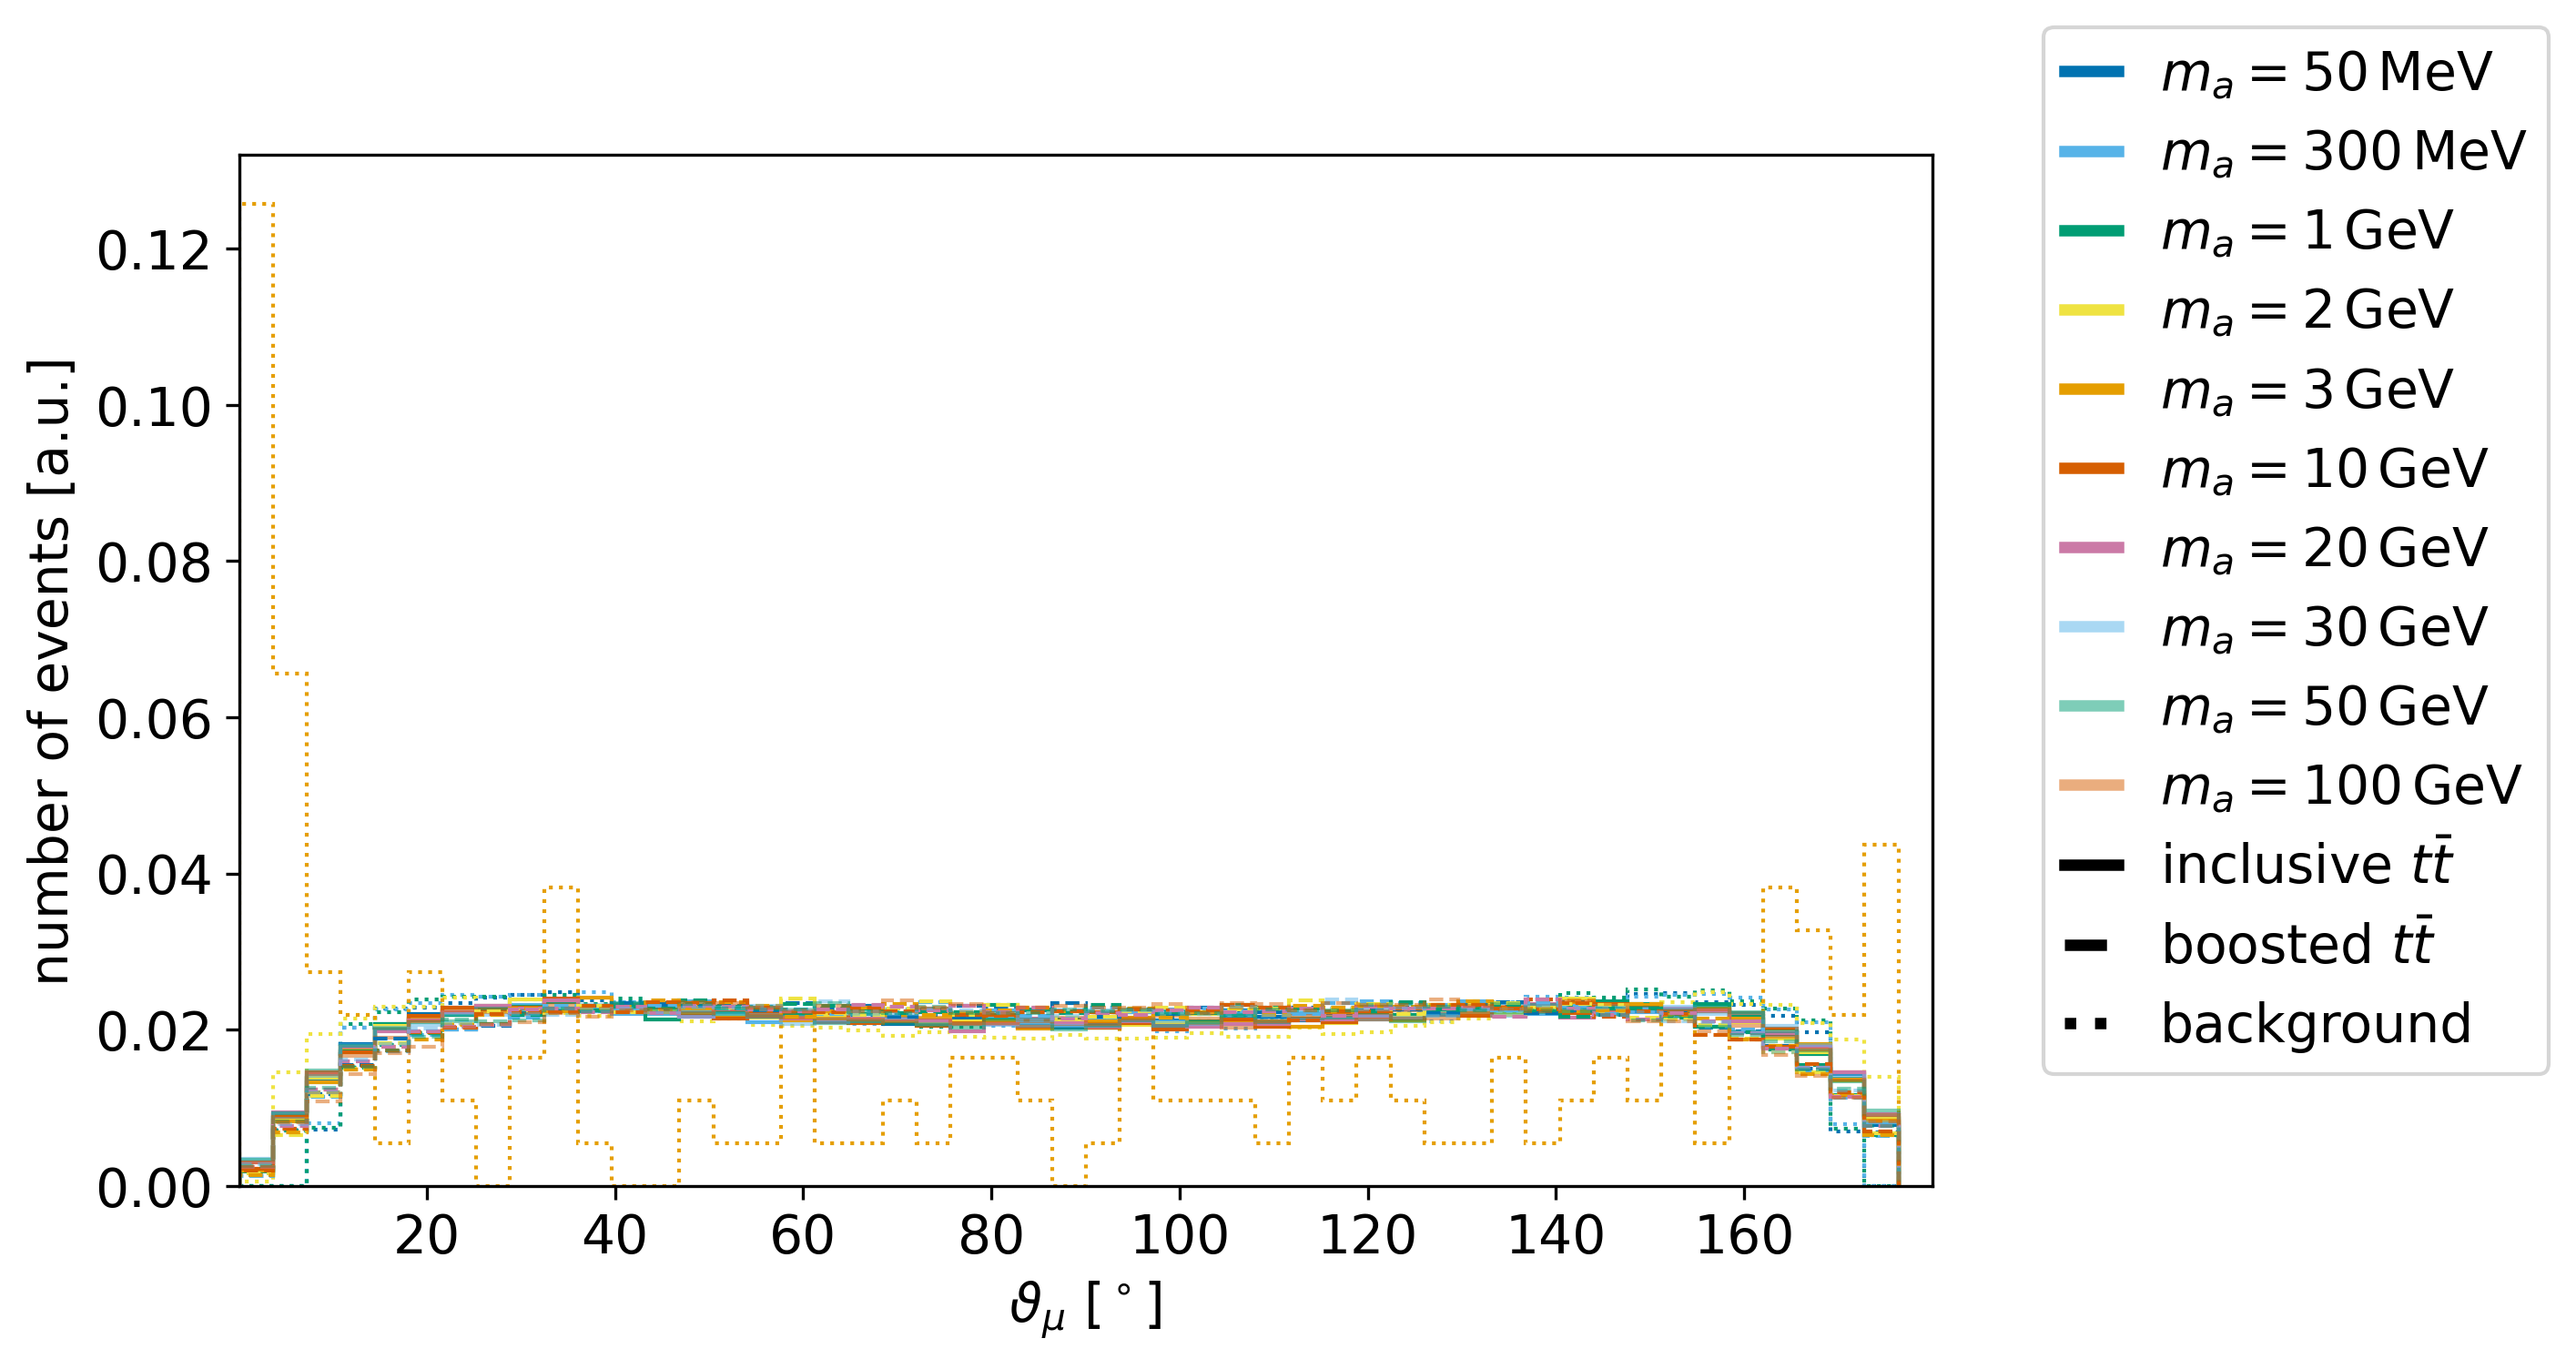

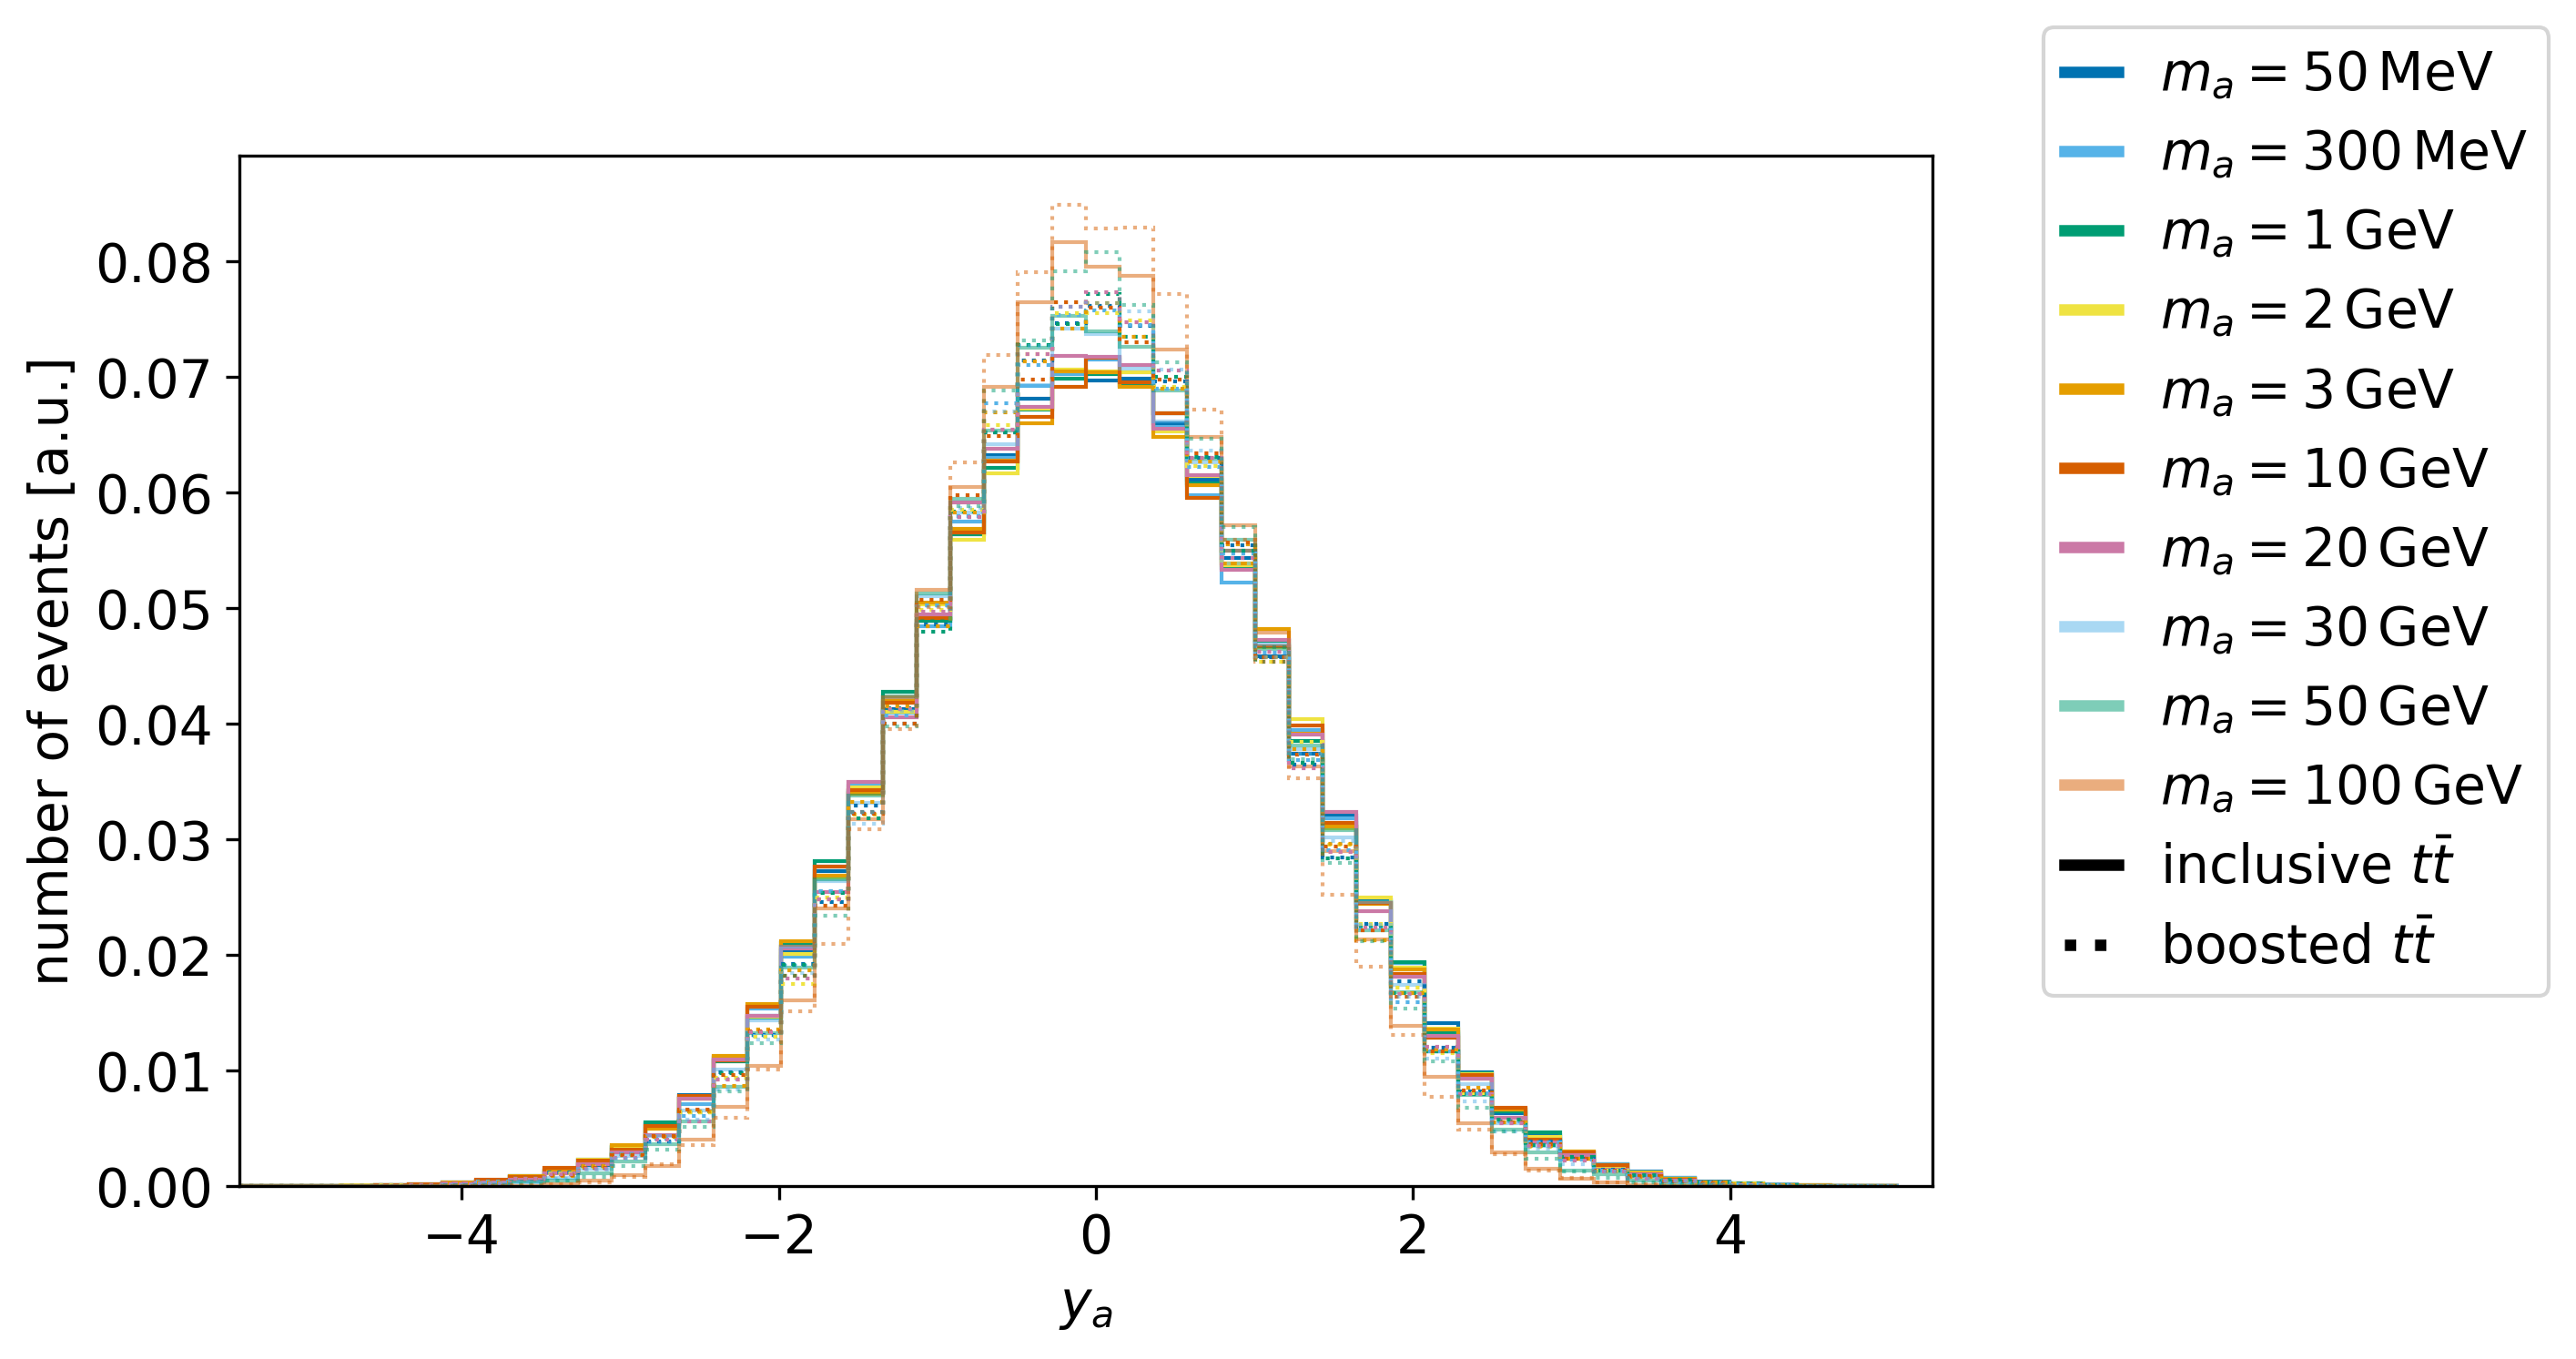

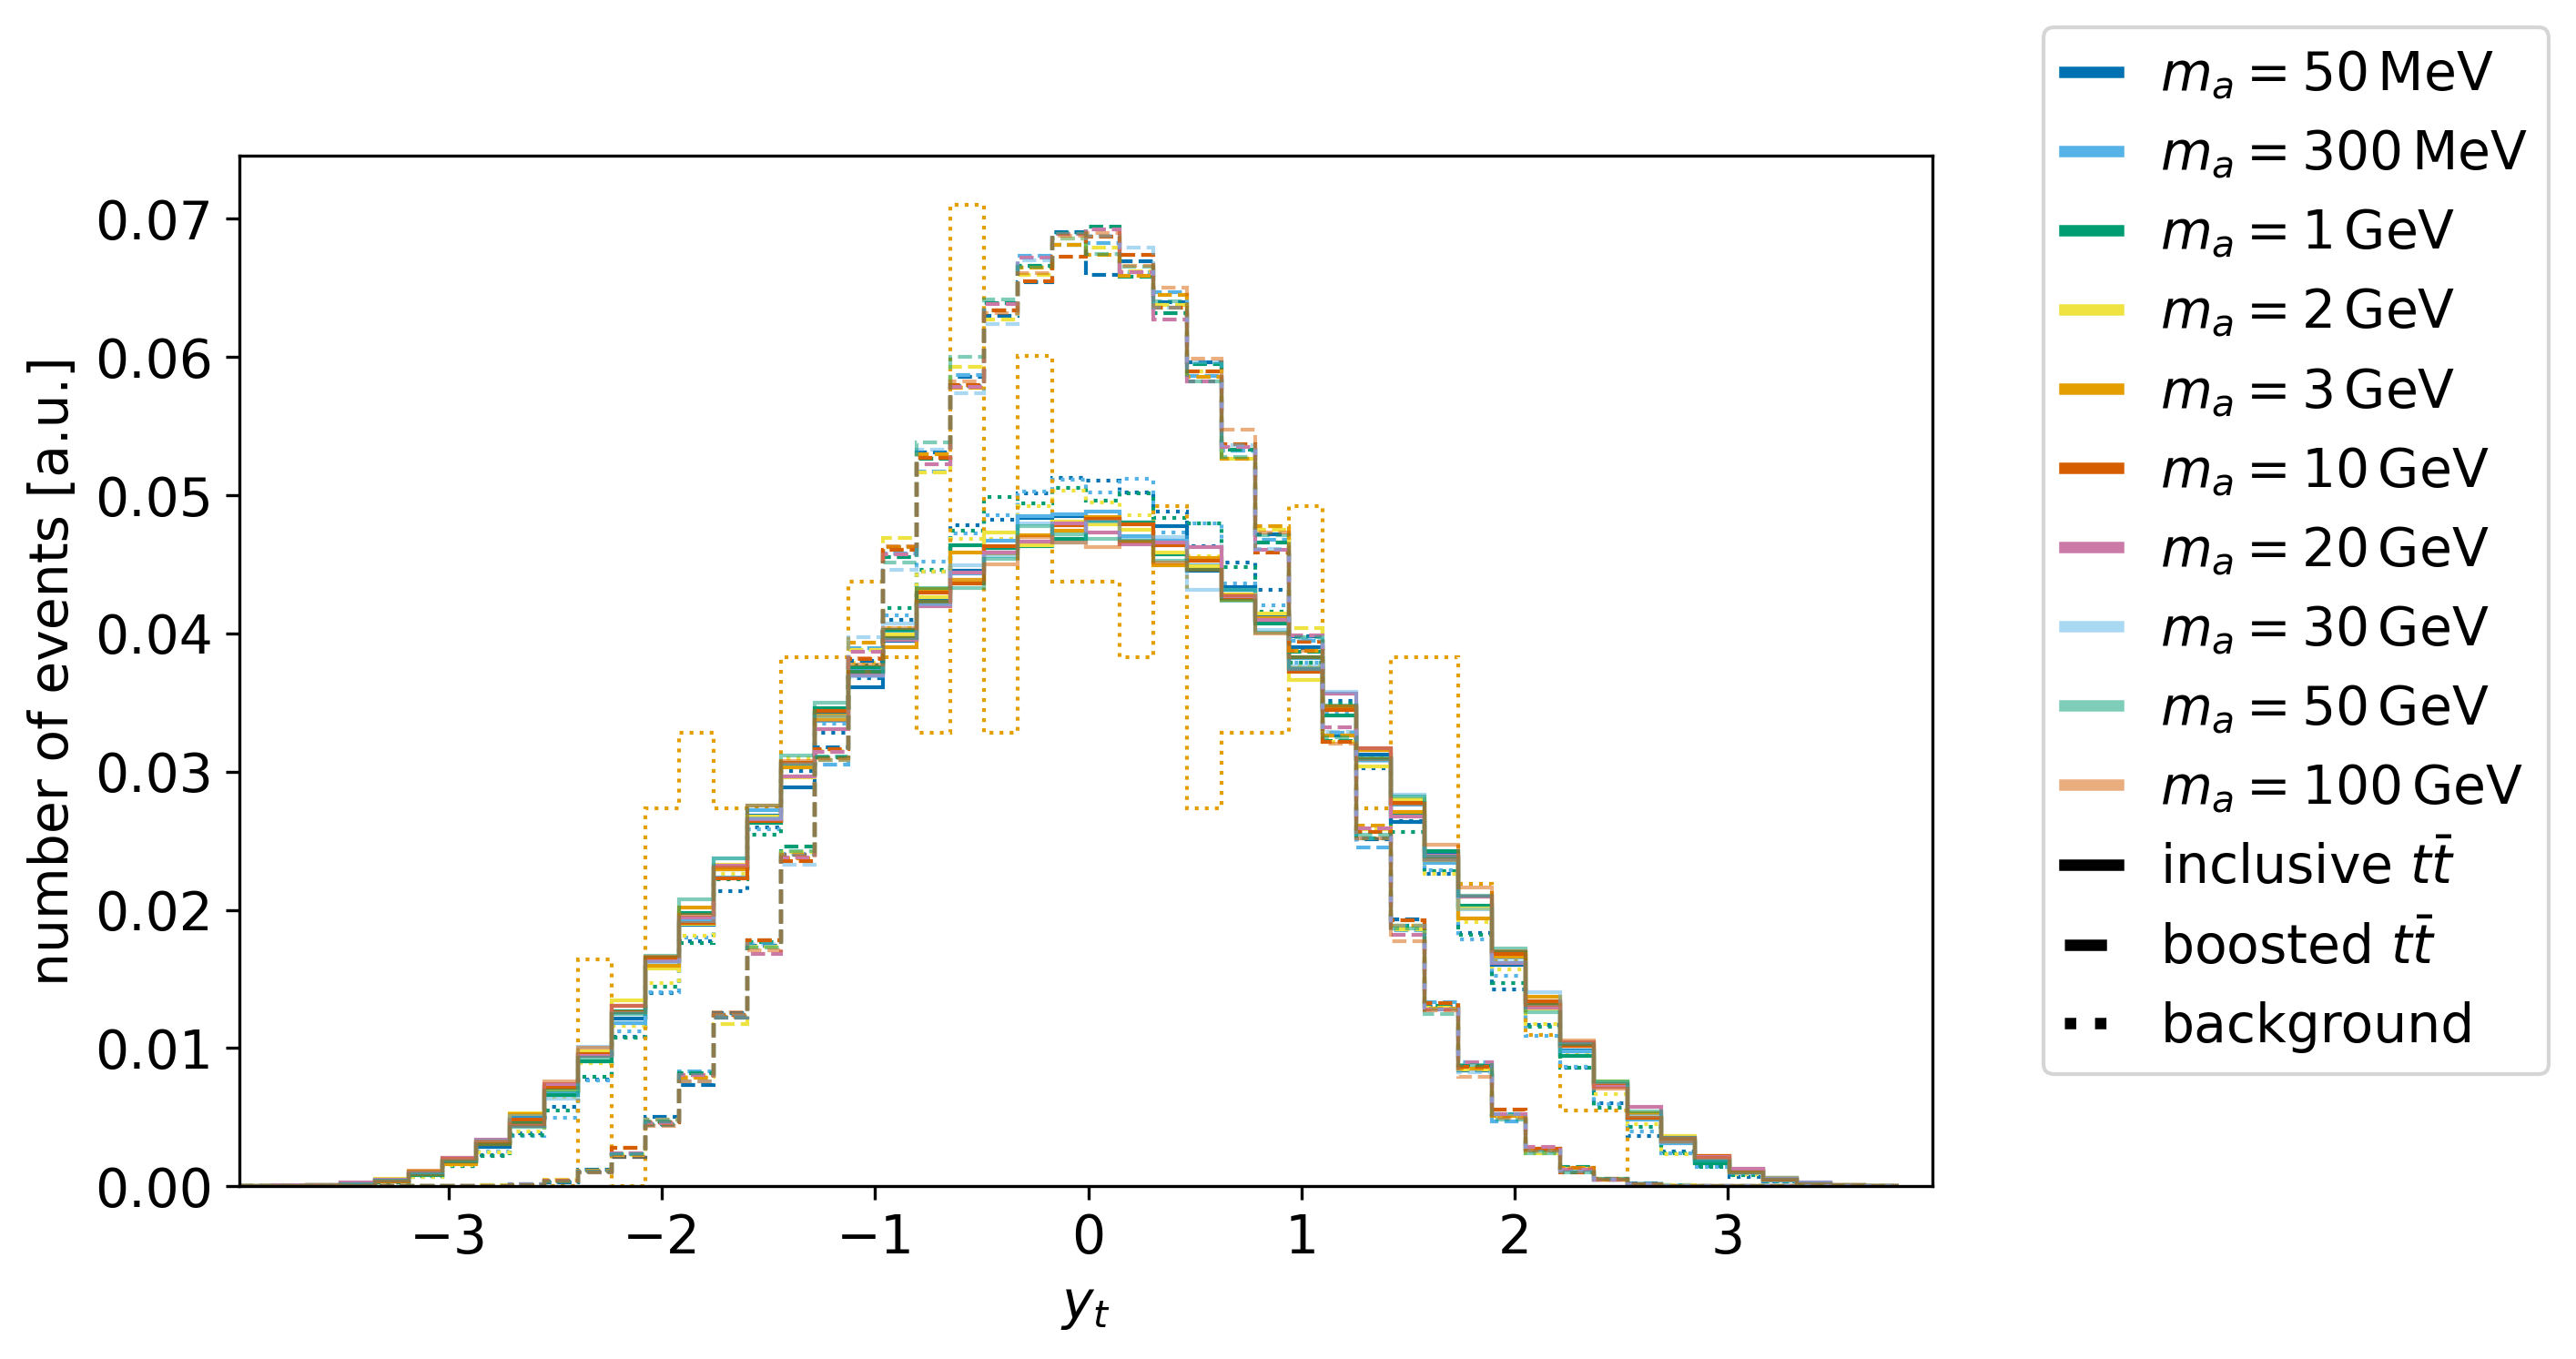

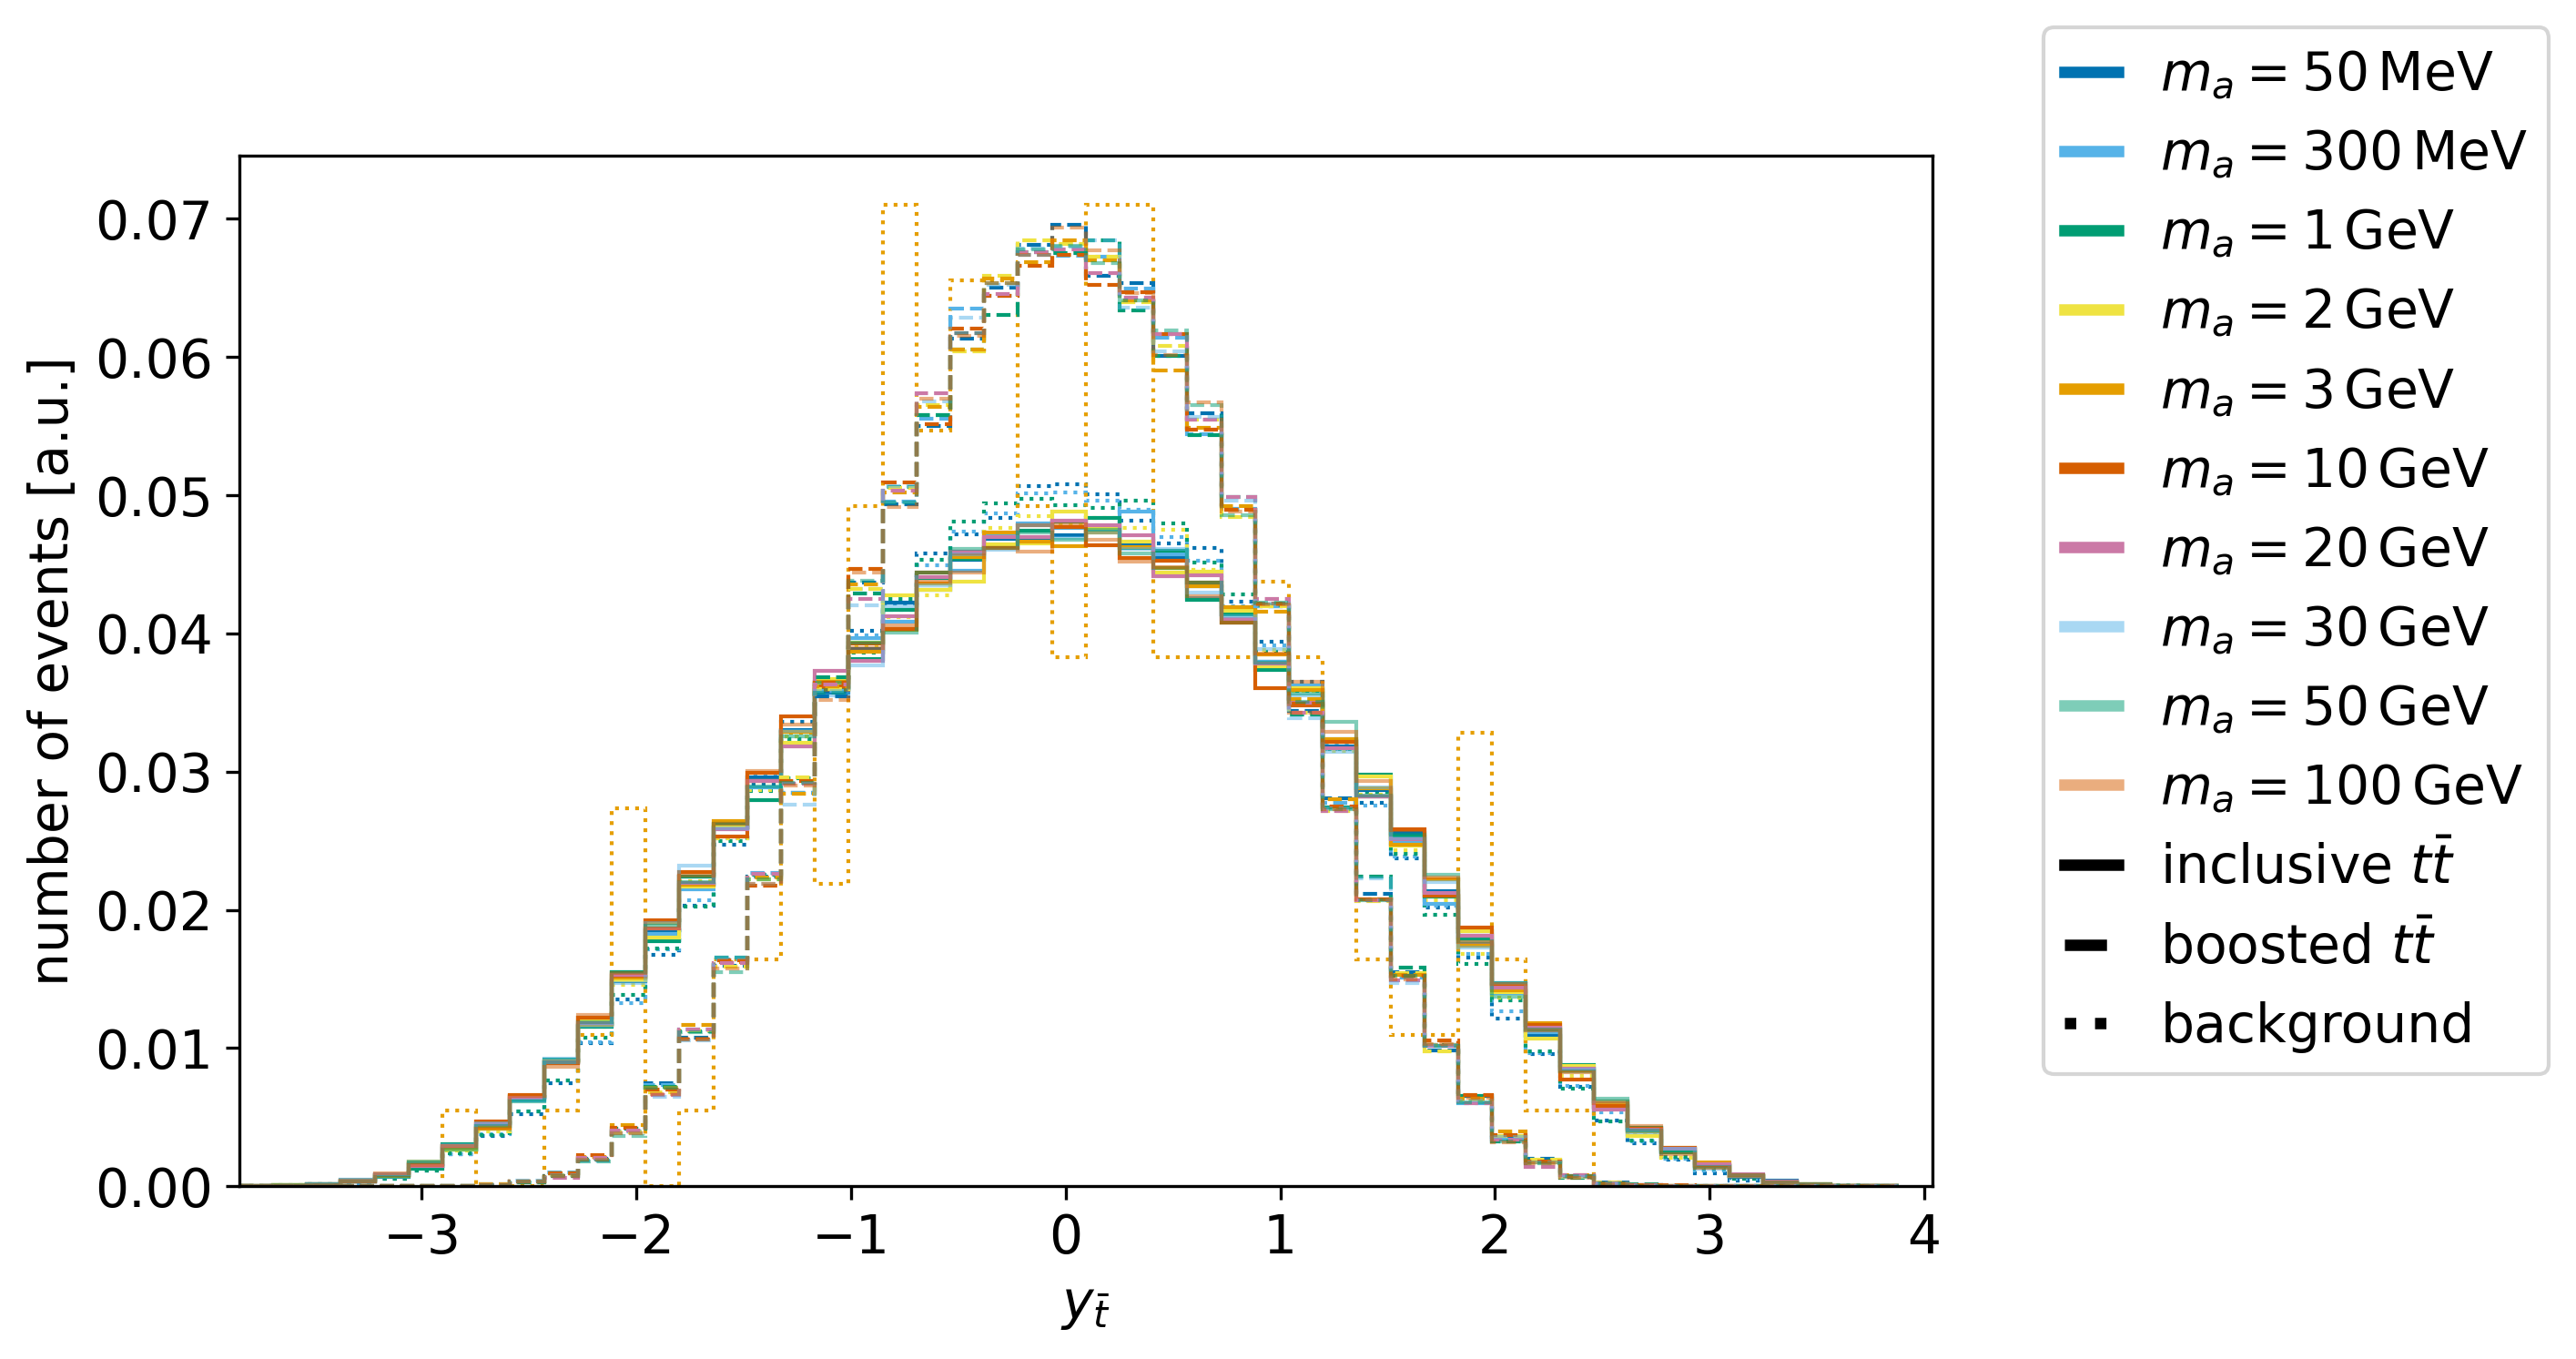

ValueError: math domain error

In [21]:
# kinematics of the inclusive and boosted signal events and the ttmumu background events
mypl.hist1dcomp(data("boost",["alp"],"incl"),data("boost",["alp"],"boost"),[],massLabels,dirLabel["boost_a"],outputpath+"ALP_boost_cwb.png",customXlim=[0,2000],customXlabels=labels_cwb)
mypl.hist1dcomp(data("p3",["alp"],"incl"),data("p3",["alp"],"boost"),[],massLabels,dirLabel["abs3mom_a"],outputpath+"ALP_3mom_cwb.png",customXlim=[0,1000],customXlabels=labels_cwb)
mypl.hist1dcomp(data("inv_mass",["top","antitop"],"incl"),data("inv_mass",["top","antitop"],"boost"),data("inv_mass",["top","antitop"],"bkg"),massLabels,dirLabel["mtt"],outputpath+"mtt_cwb.png",customXlim=[0,2000],customXlabels=labels_cwboth)
mypl.hist1dcomp(data("pT",["alp"],"incl"),data("pT",["alp"],"boost"),[],massLabels,dirLabel["pT_a"],outputpath+"ALP_pT_cwb.png",customXlim=[0,1000],customXlabels=labels_cwb)
mypl.hist1dcomp(data("pT",["top"],"incl"),data("pT",["top"],"boost"),data("pT",["top"],"bkg"),massLabels,dirLabel["pT_t"],outputpath+"Top_pT_cwb.png",customXlim=[0,1000],customXlabels=labels_cwboth)
mypl.hist1dcomp(data("pT",["antitop"],"incl"),data("pT",["antitop"],"boost"),data("pT",["antitop"],"bkg"),massLabels,dirLabel["pT_at"],outputpath+"AntiTop_pT_cwb.png",customXlim=[0,1000],customXlabels=labels_cwboth)
mypl.hist1dcomp(data("pT",["muon"],"incl"),data("pT",["muon"],"boost"),data("pT",["muon"],"bkg"),massLabels,dirLabel["pT_mu"],outputpath+"Muon_pT_cwb.png",customXlim=[0,1000],customXlabels=labels_cwboth)
mypl.hist1dcomp(data("theta",["alp"],"incl"),data("theta",["alp"],"boost"),[],massLabels,dirLabel["theta_a"],outputpath+"ALP_theta_cwb.png",customXlabels=labels_cwb)
mypl.hist1dcomp(data("theta",["top"],"incl"),data("theta",["top"],"boost"),data("theta",["top"],"bkg"),massLabels,dirLabel["theta_t"],outputpath+"Top_theta_cwb.png",customXlabels=labels_cwboth)
mypl.hist1dcomp(data("theta",["antitop"],"incl"),data("theta",["antitop"],"boost"),data("theta",["antitop"],"bkg"),massLabels,dirLabel["theta_at"],outputpath+"AntiTop_theta_cwb.png",customXlabels=labels_cwboth)
mypl.hist1dcomp(data("theta",["muon"],"incl"),data("theta",["muon"],"boost"),data("theta",["muon"],"bkg"),massLabels,dirLabel["theta_mu"],outputpath+"Muon_theta_cwb.png",customXlabels=labels_cwboth)
mypl.hist1dcomp(data("y",["alp"],"incl"),data("y",["alp"],"boost"),[],massLabels,dirLabel["y_a"],outputpath+"ALP_rapidity_cwb.png",customXlabels=labels_cwb)
mypl.hist1dcomp(data("y",["top"],"incl"),data("y",["top"],"boost"),data("y",["top"],"bkg"),massLabels,dirLabel["y_t"],outputpath+"Top_rapidity_cwb.png",customXlabels=labels_cwboth)
mypl.hist1dcomp(data("y",["antitop"],"incl"),data("y",["antitop"],"boost"),data("y",["antitop"],"bkg"),massLabels,dirLabel["y_at"],outputpath+"AntiTop_rapidity_cwb.png",customXlabels=labels_cwboth)
mypl.hist1dcomp(data("y",["muon"],"incl"),data("y",["muon"],"boost"),data("y",["muon"],"bkg"),massLabels,dirLabel["y_mu"],outputpath+"Muon_rapidity_cwb.png",customXlabels=labels_cwboth)
mypl.hist1dcomp(data("eta",["alp"],"incl"),data("eta",["alp"],"boost"),[],massLabels,dirLabel["eta_a"],outputpath+"ALP_pseudorapidity_cwb.png",customXlabels=labels_cwb)
mypl.hist1dcomp(data("eta",["top"],"incl"),data("eta",["top"],"boost"),data("eta",["top"],"bkg"),massLabels,dirLabel["eta_t"],outputpath+"Top_pseudorapidity_cwb.png",customXlabels=labels_cwboth)
mypl.hist1dcomp(data("eta",["antitop"],"incl"),data("eta",["antitop"],"boost"),data("eta",["antitop"],"bkg"),massLabels,dirLabel["eta_at"],outputpath+"AntiTop_pseudorapidity_cwb.png",customXlabels=labels_cwboth)
mypl.hist1dcomp(data("eta",["muon"],"incl"),data("eta",["muon"],"boost"),data("eta",["muon"],"bkg"),massLabels,dirLabel["eta_mu"],outputpath+"Muon_pseudorapidity_cwb.png",customXlabels=labels_cwboth)
mypl.hist1dcomp(data("oA",["alp","top"],"incl"),data("oA",["alp","top"],"boost"),[],massLabels,dirLabel["oA_at"],outputpath+"Angle_ALPTop_cwb.png",customXlabels=labels_cwb)
mypl.hist1dcomp(data("oA",["top","antitop"],"incl"),data("oA",["top","antitop"],"boost"),data("oA",["top","antitop"],"bkg"),massLabels,dirLabel["oA_tat"],outputpath+"Angle_TopAntiTop_cwb.png",customXlabels=labels_cwboth)
mypl.hist1dcomp(data("oA",["antitop","alp"],"incl"),data("oA",["antitop","alp"],"boost"),[],massLabels,dirLabel["oA_ata"],outputpath+"Angle_AntiTopALP_cwb.png",customXlabels=labels_cwb)
mypl.hist1dcomp(data("oA",["antimuon","muon"],"incl"),data("oA",["antimuon","muon"],"boost"),data("oA",["antimuon","muon"],"bkg"),massLabels,dirLabel["oA_muons"],outputpath+"Angle_Muons_cwb.png",customXlabels=labels_cwb)

AttributeError: This method only works with the ScalarFormatter

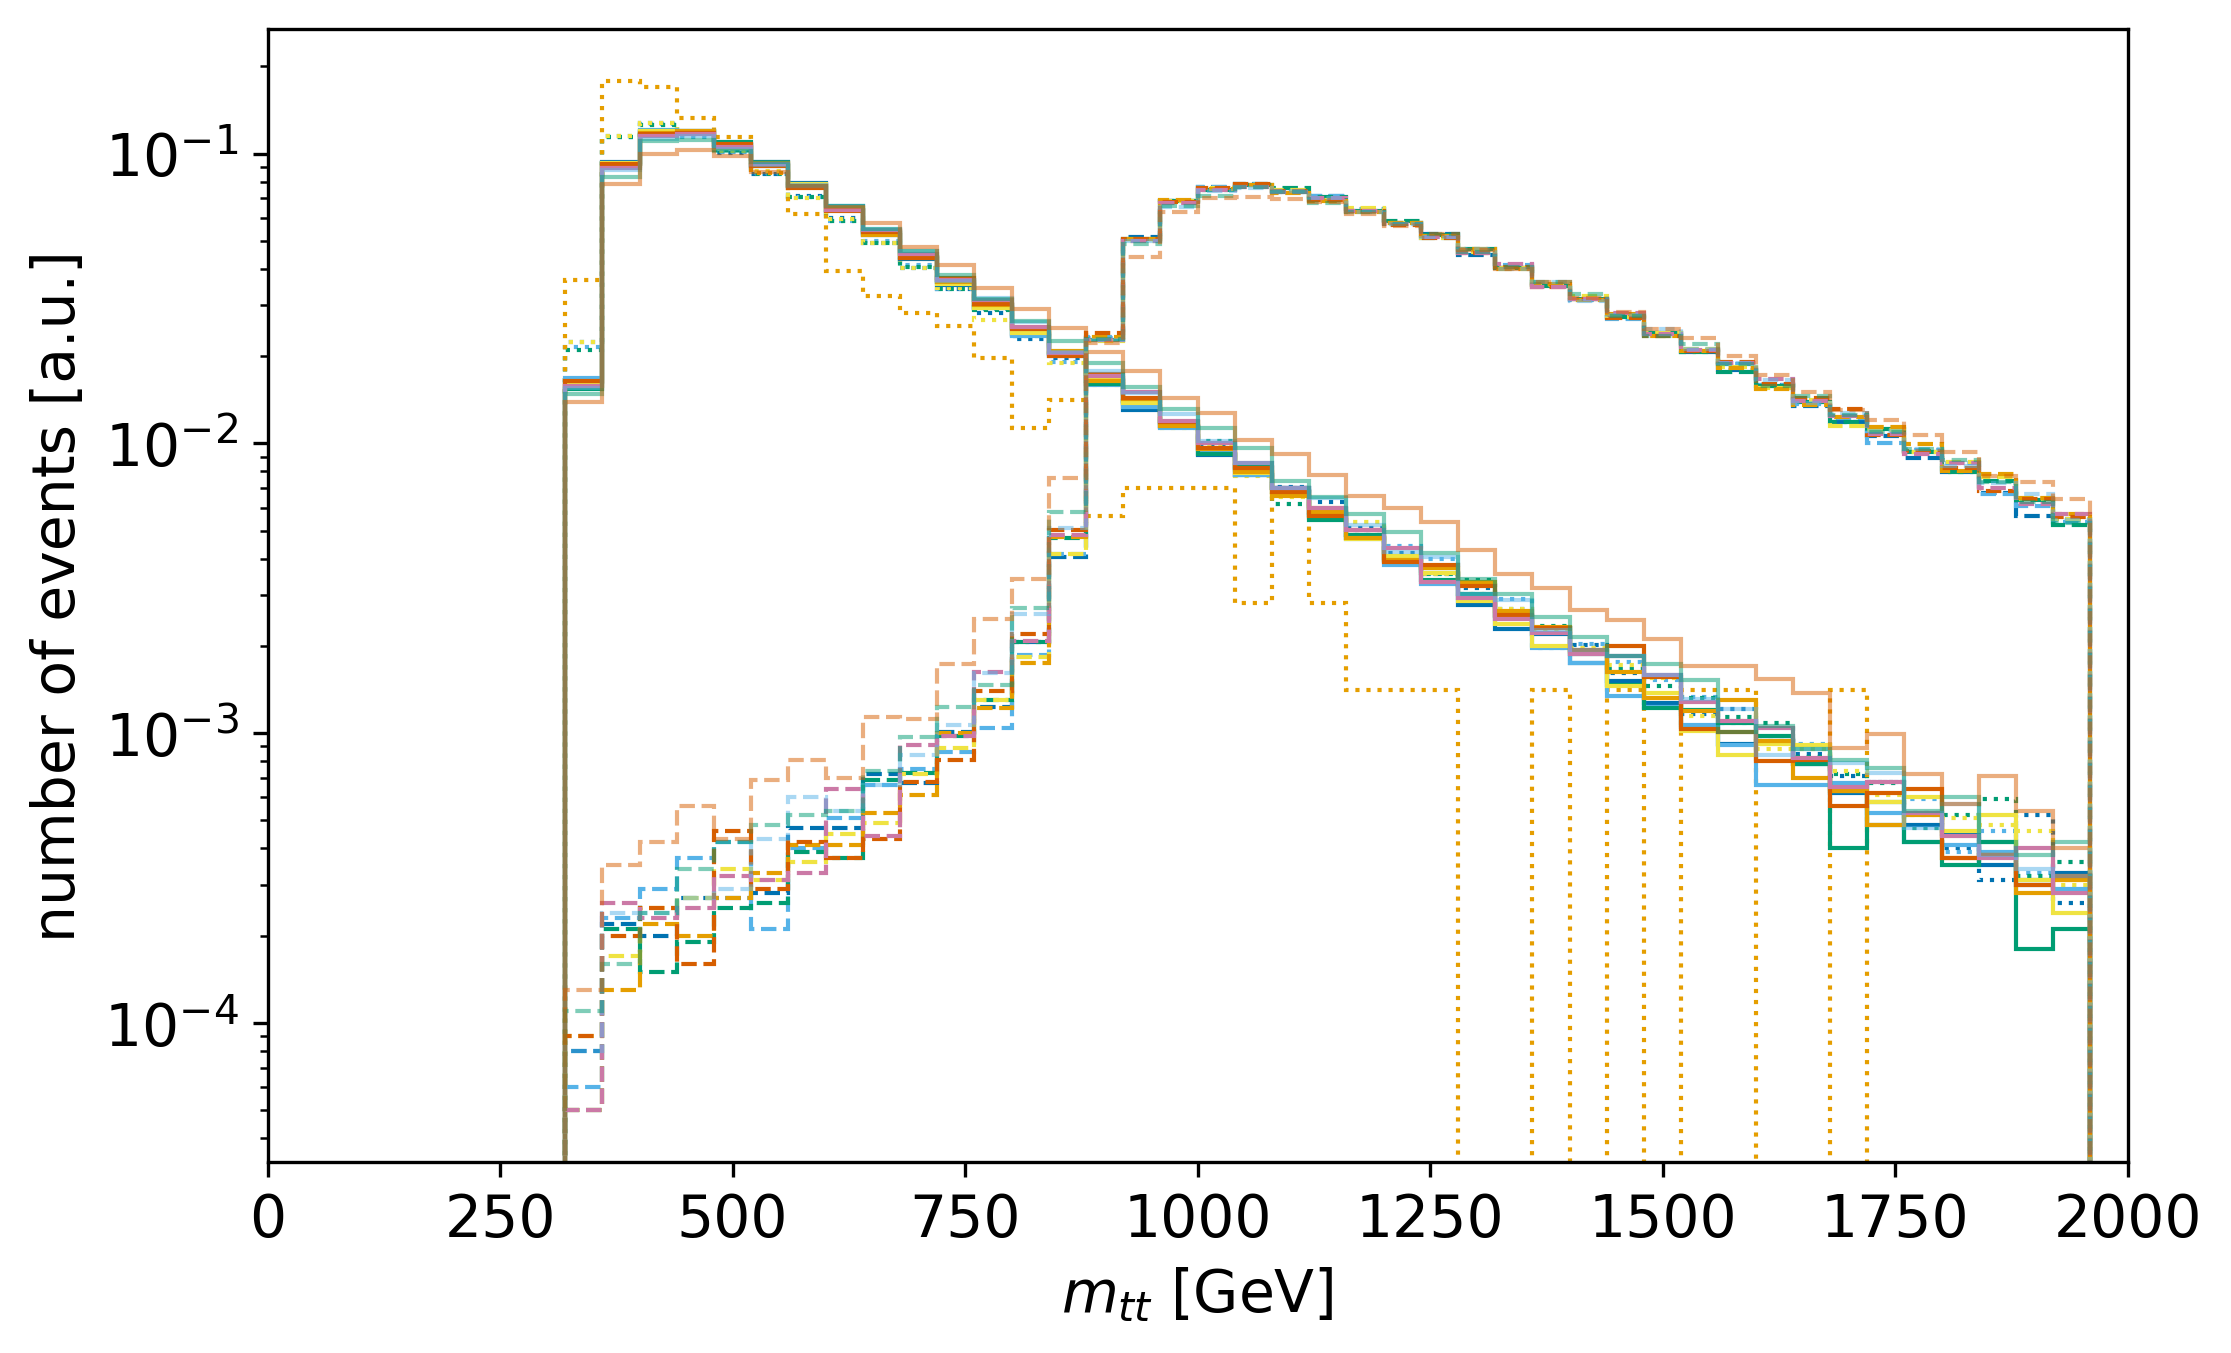

In [19]:

intlumi = 3.
#cross_incl = [1,1,1,1,1,1,1,1,1,1]
cross_incl = [8.073595e-05, 7.822266e-05, 8.793817e-05, 8.745365e-05, 9.330928e-05, 7.862018e-05, 8.211459e-05, 7.560688e-05, 6.105389e-05, 4.061047e-05]
#cross_boost = [1,1,1,1,1,1,1,1,1,1]
cross_boost = [9.524593e-07,8.812992e-07,9.218103e-07,1.035508e-06,9.279058e-07,9.905323e-07,8.934317e-07,9.732106e-07,7.858127e-07,5.881465e-07]
#cross_bkg = [1.601106e-05, 1.846138e-05, 1.870173e-05, 1.861830e-05, 1.663600e+01]
cross_bkg = [1.601106e-05, 1.846138e-05, 1.870173e-05, 1.861830e-05]
#mypl.hist1dcross(data("inv_mass",["top","antitop"],"incl"), data("inv_mass",["top","antitop"],"boost"), data("inv_mass",["top","antitop"],"bkg"),cross_incl,cross_boost,cross_bkg,intlumi,massLabels,dirLabel["mtt"],outputpath+"mtt_cwb_ttj_log_stacked.png",customXlim=[0,2000],customXlabels=labels_bkg, log_scale=True, stacked3=True)
mypl.hist1dcomp(data("inv_mass",["top","antitop"],"incl"), data("inv_mass",["top","antitop"],"boost"), data("inv_mass",["top","antitop"],"bkg"),massLabels,dirLabel["mtt"],outputpath+"mtt_cwb_ttj_log.png",customXlim=[0,2000],customXlabels=labels_bkg, log_scale=True)


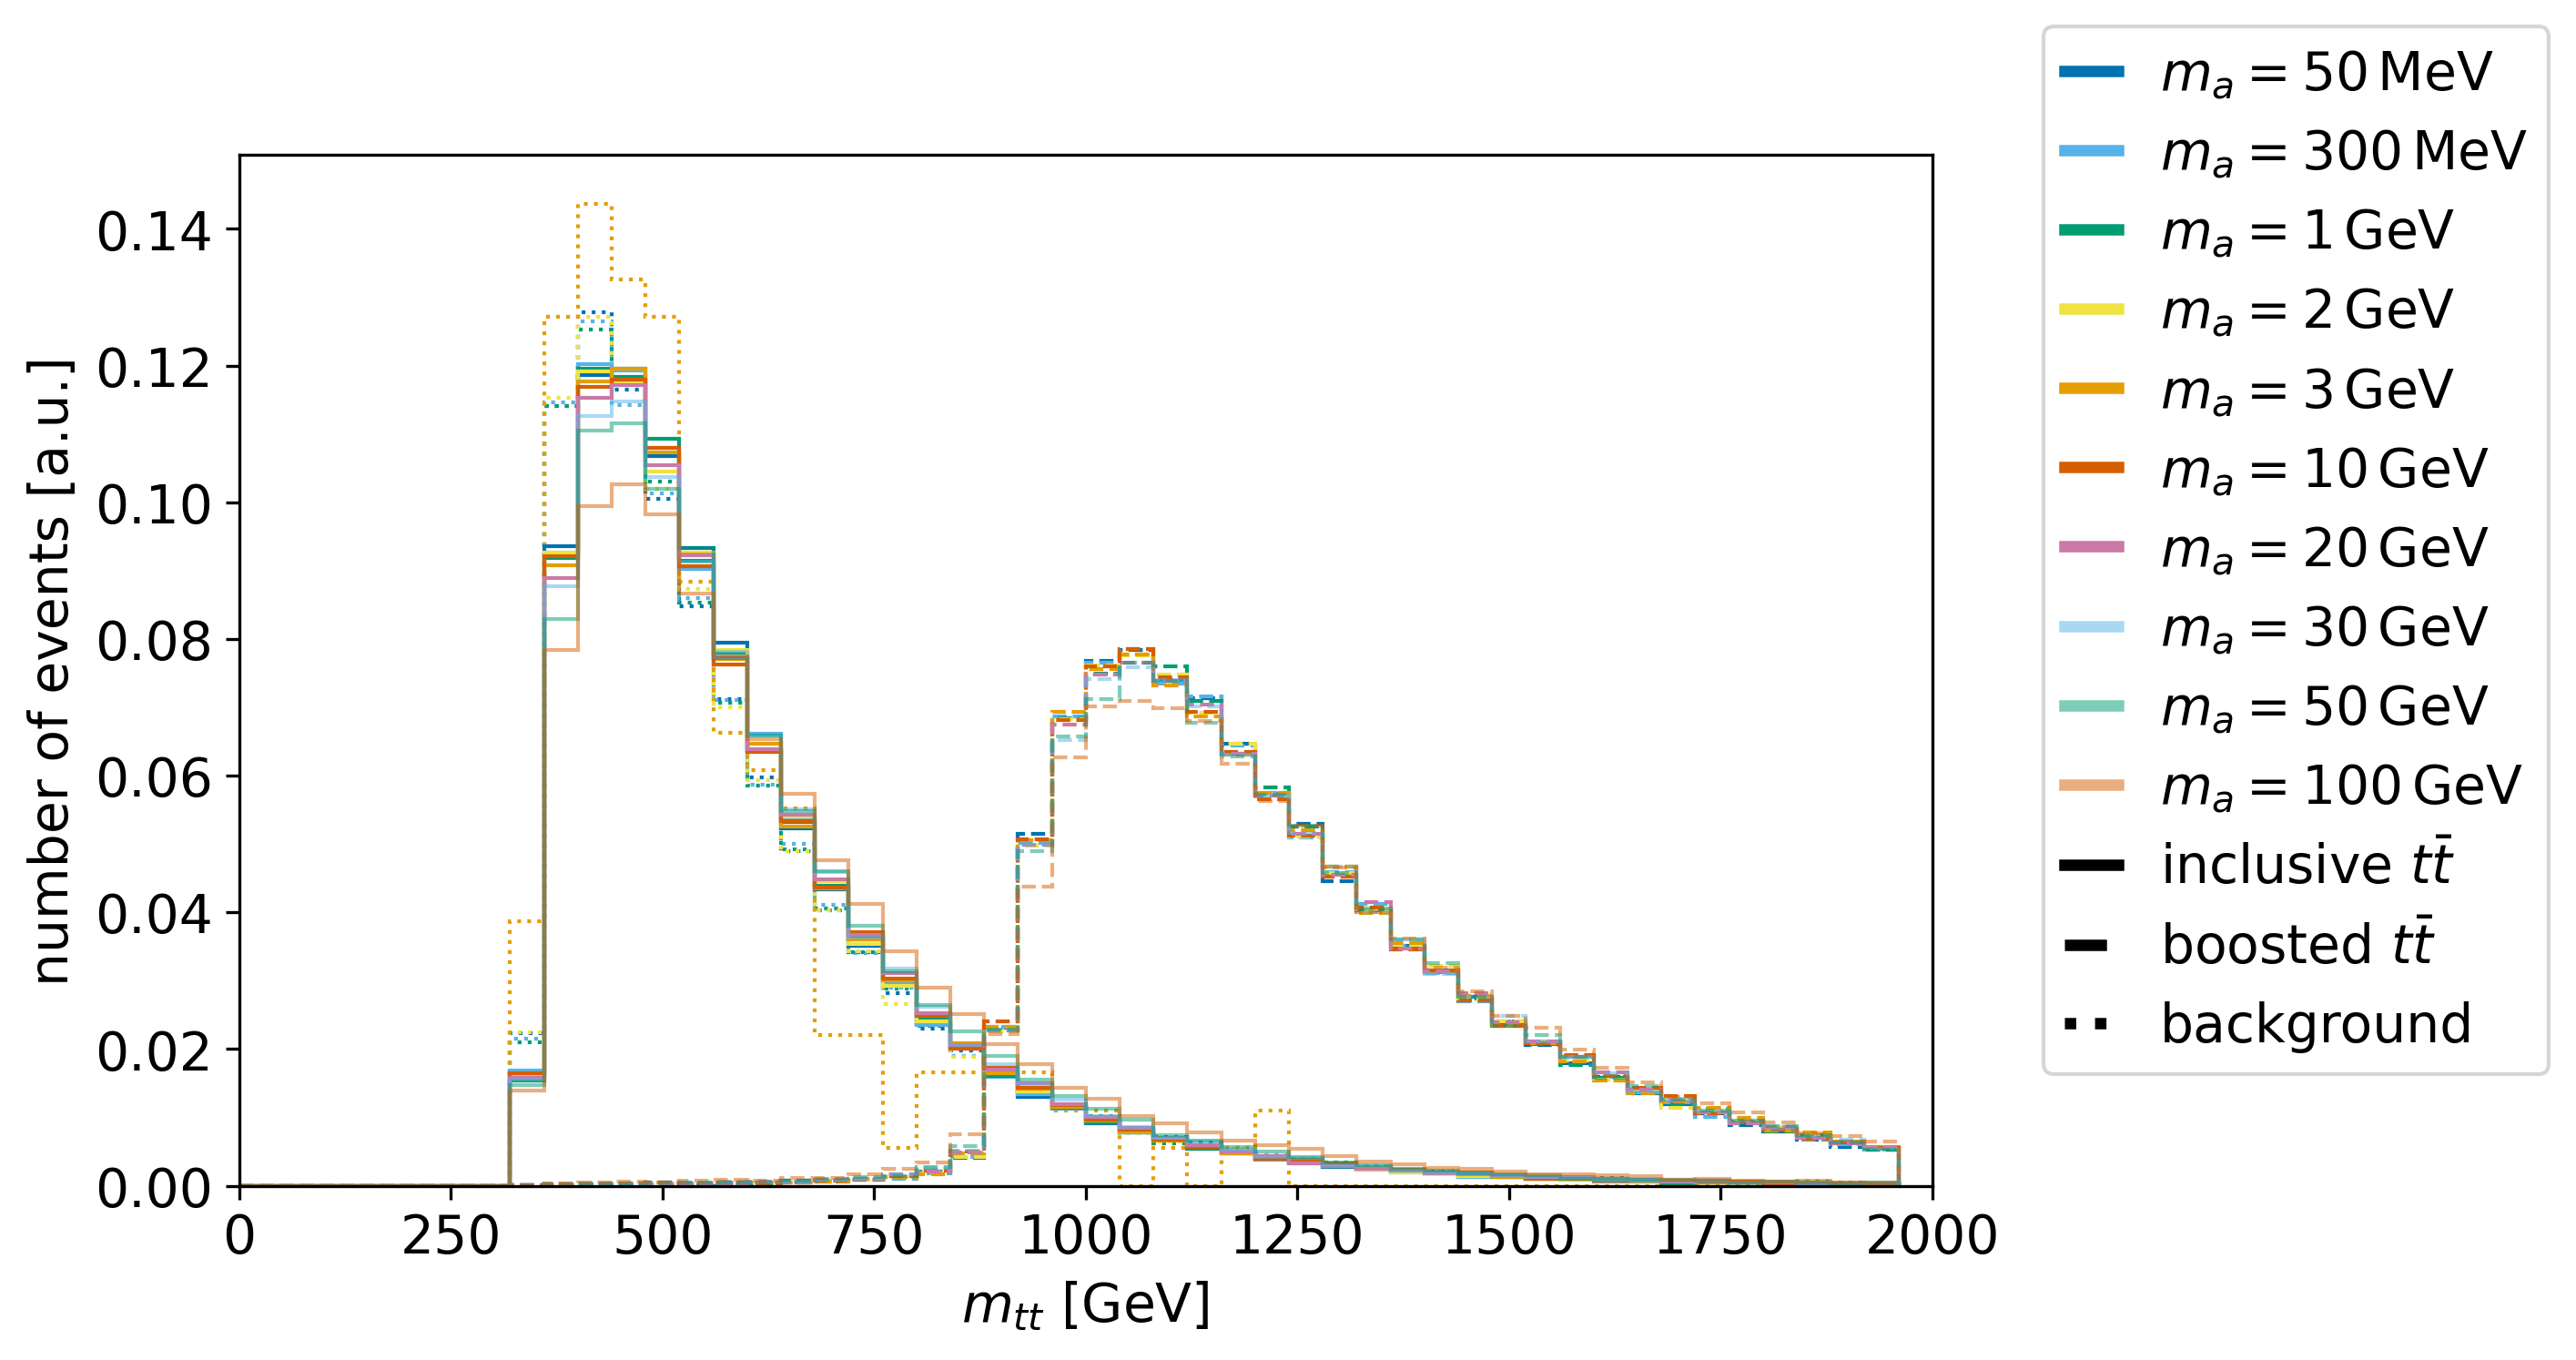

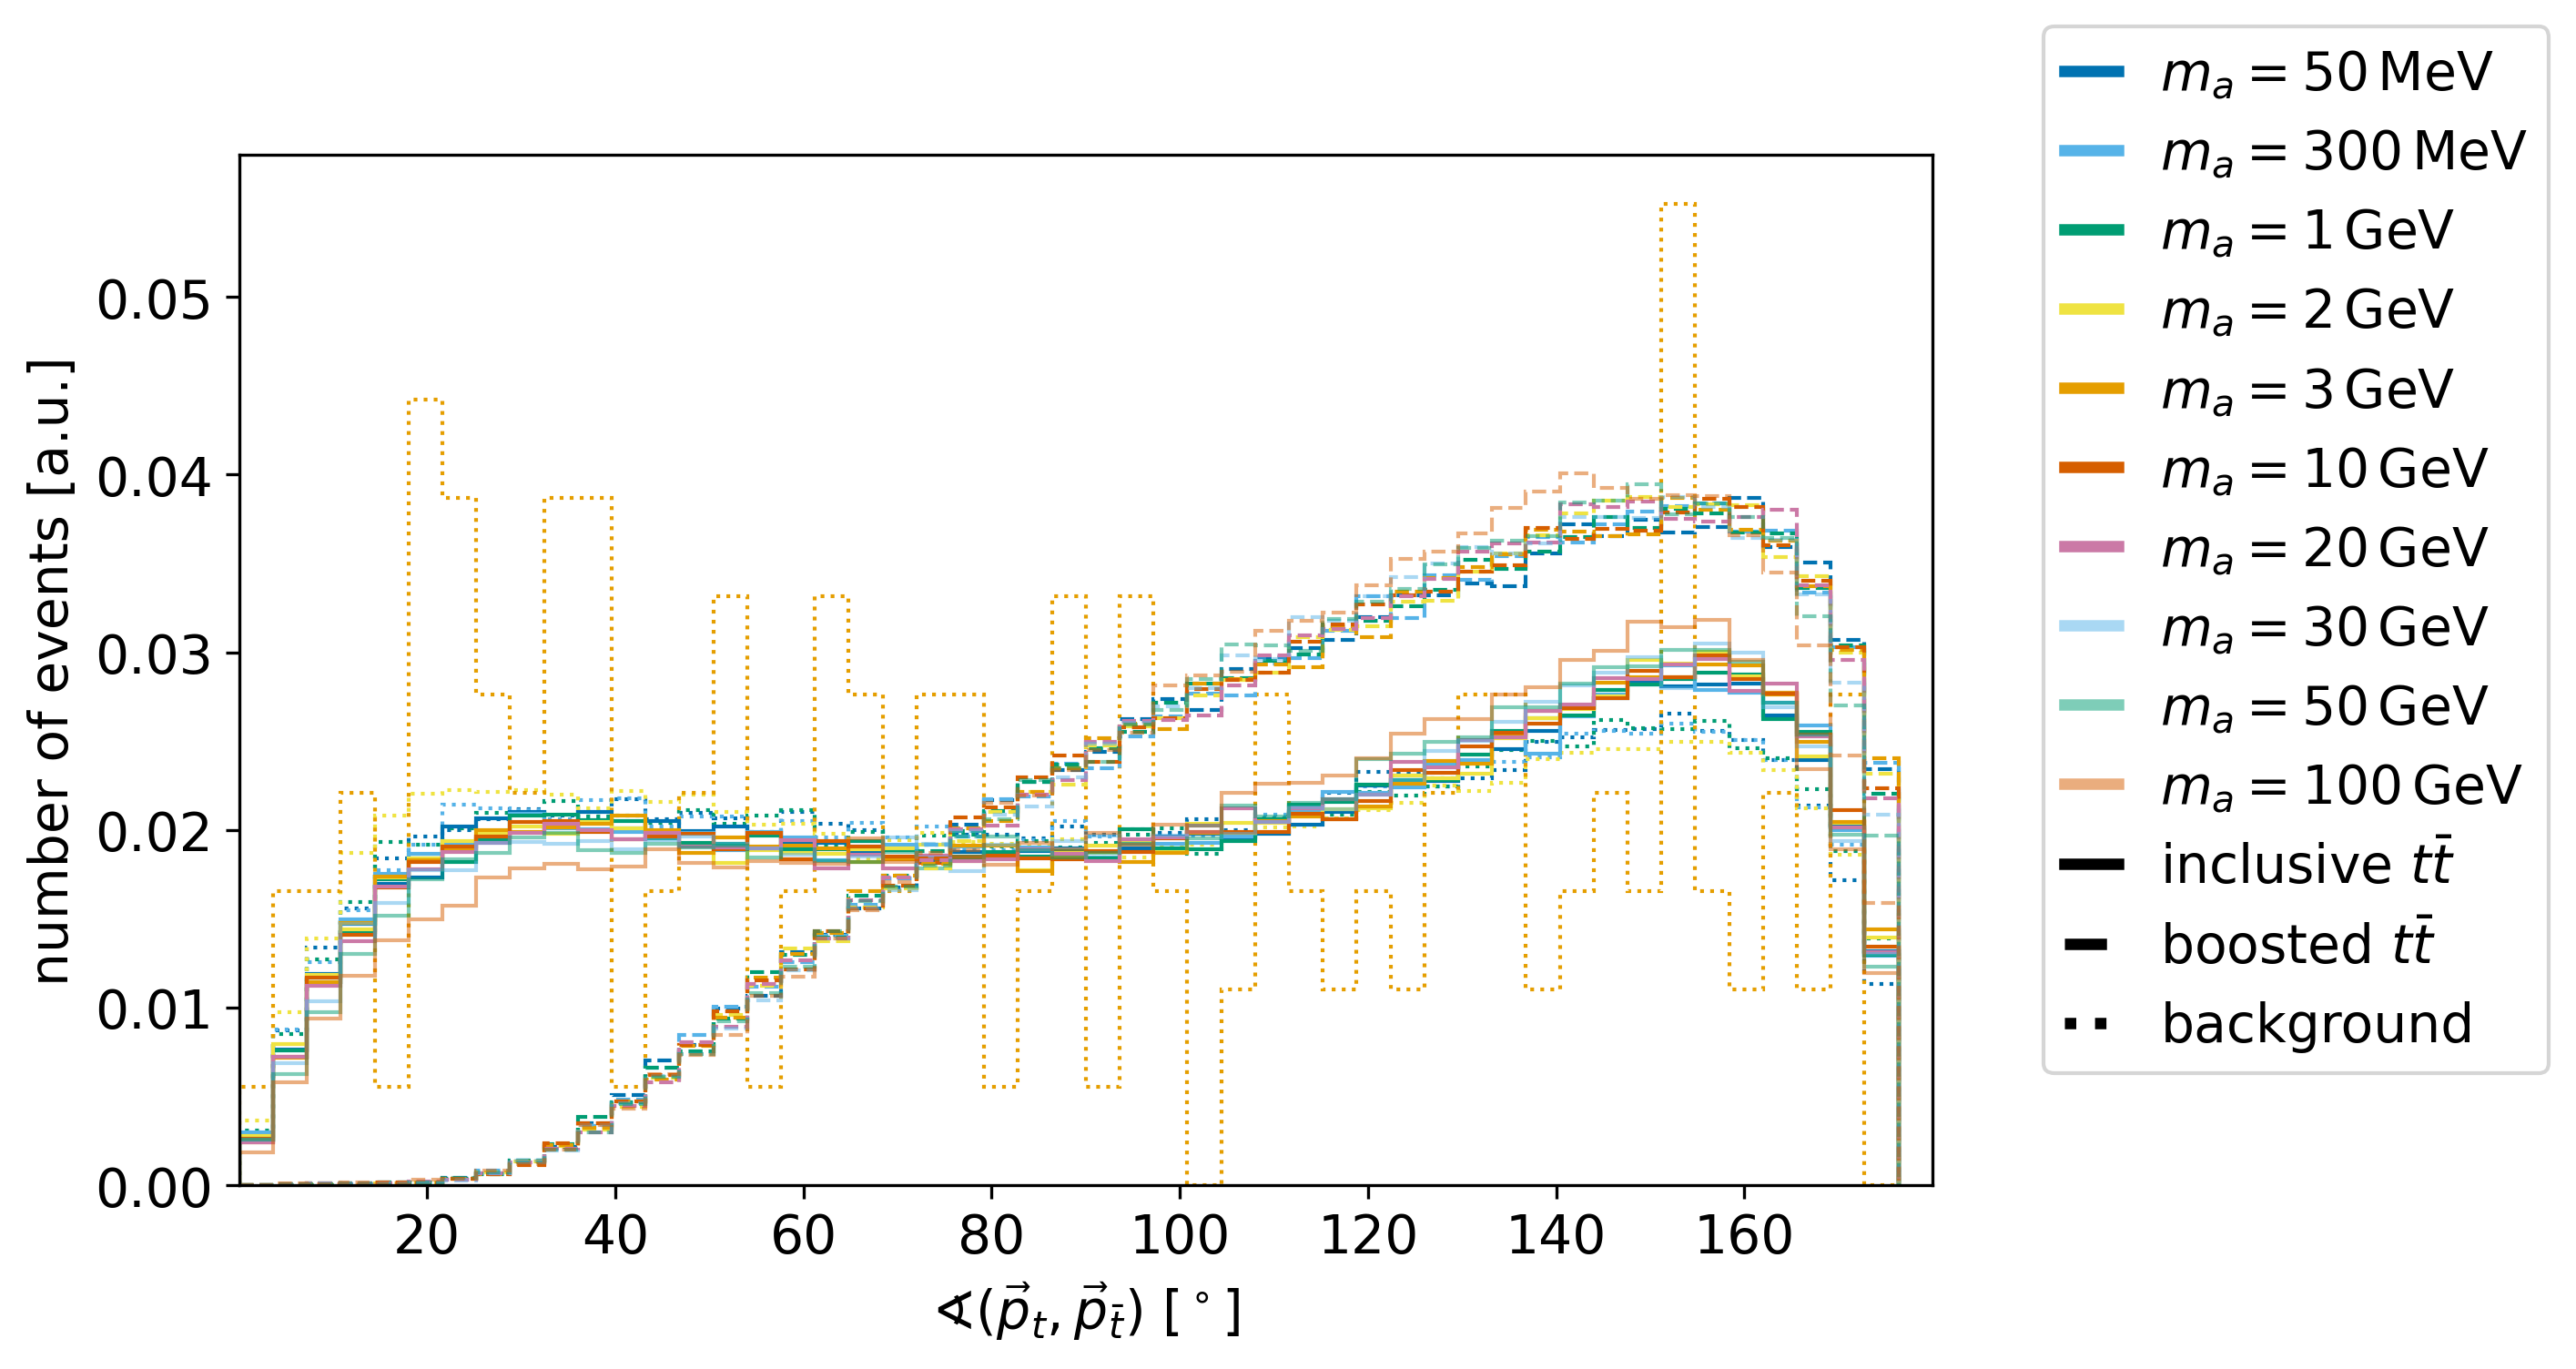

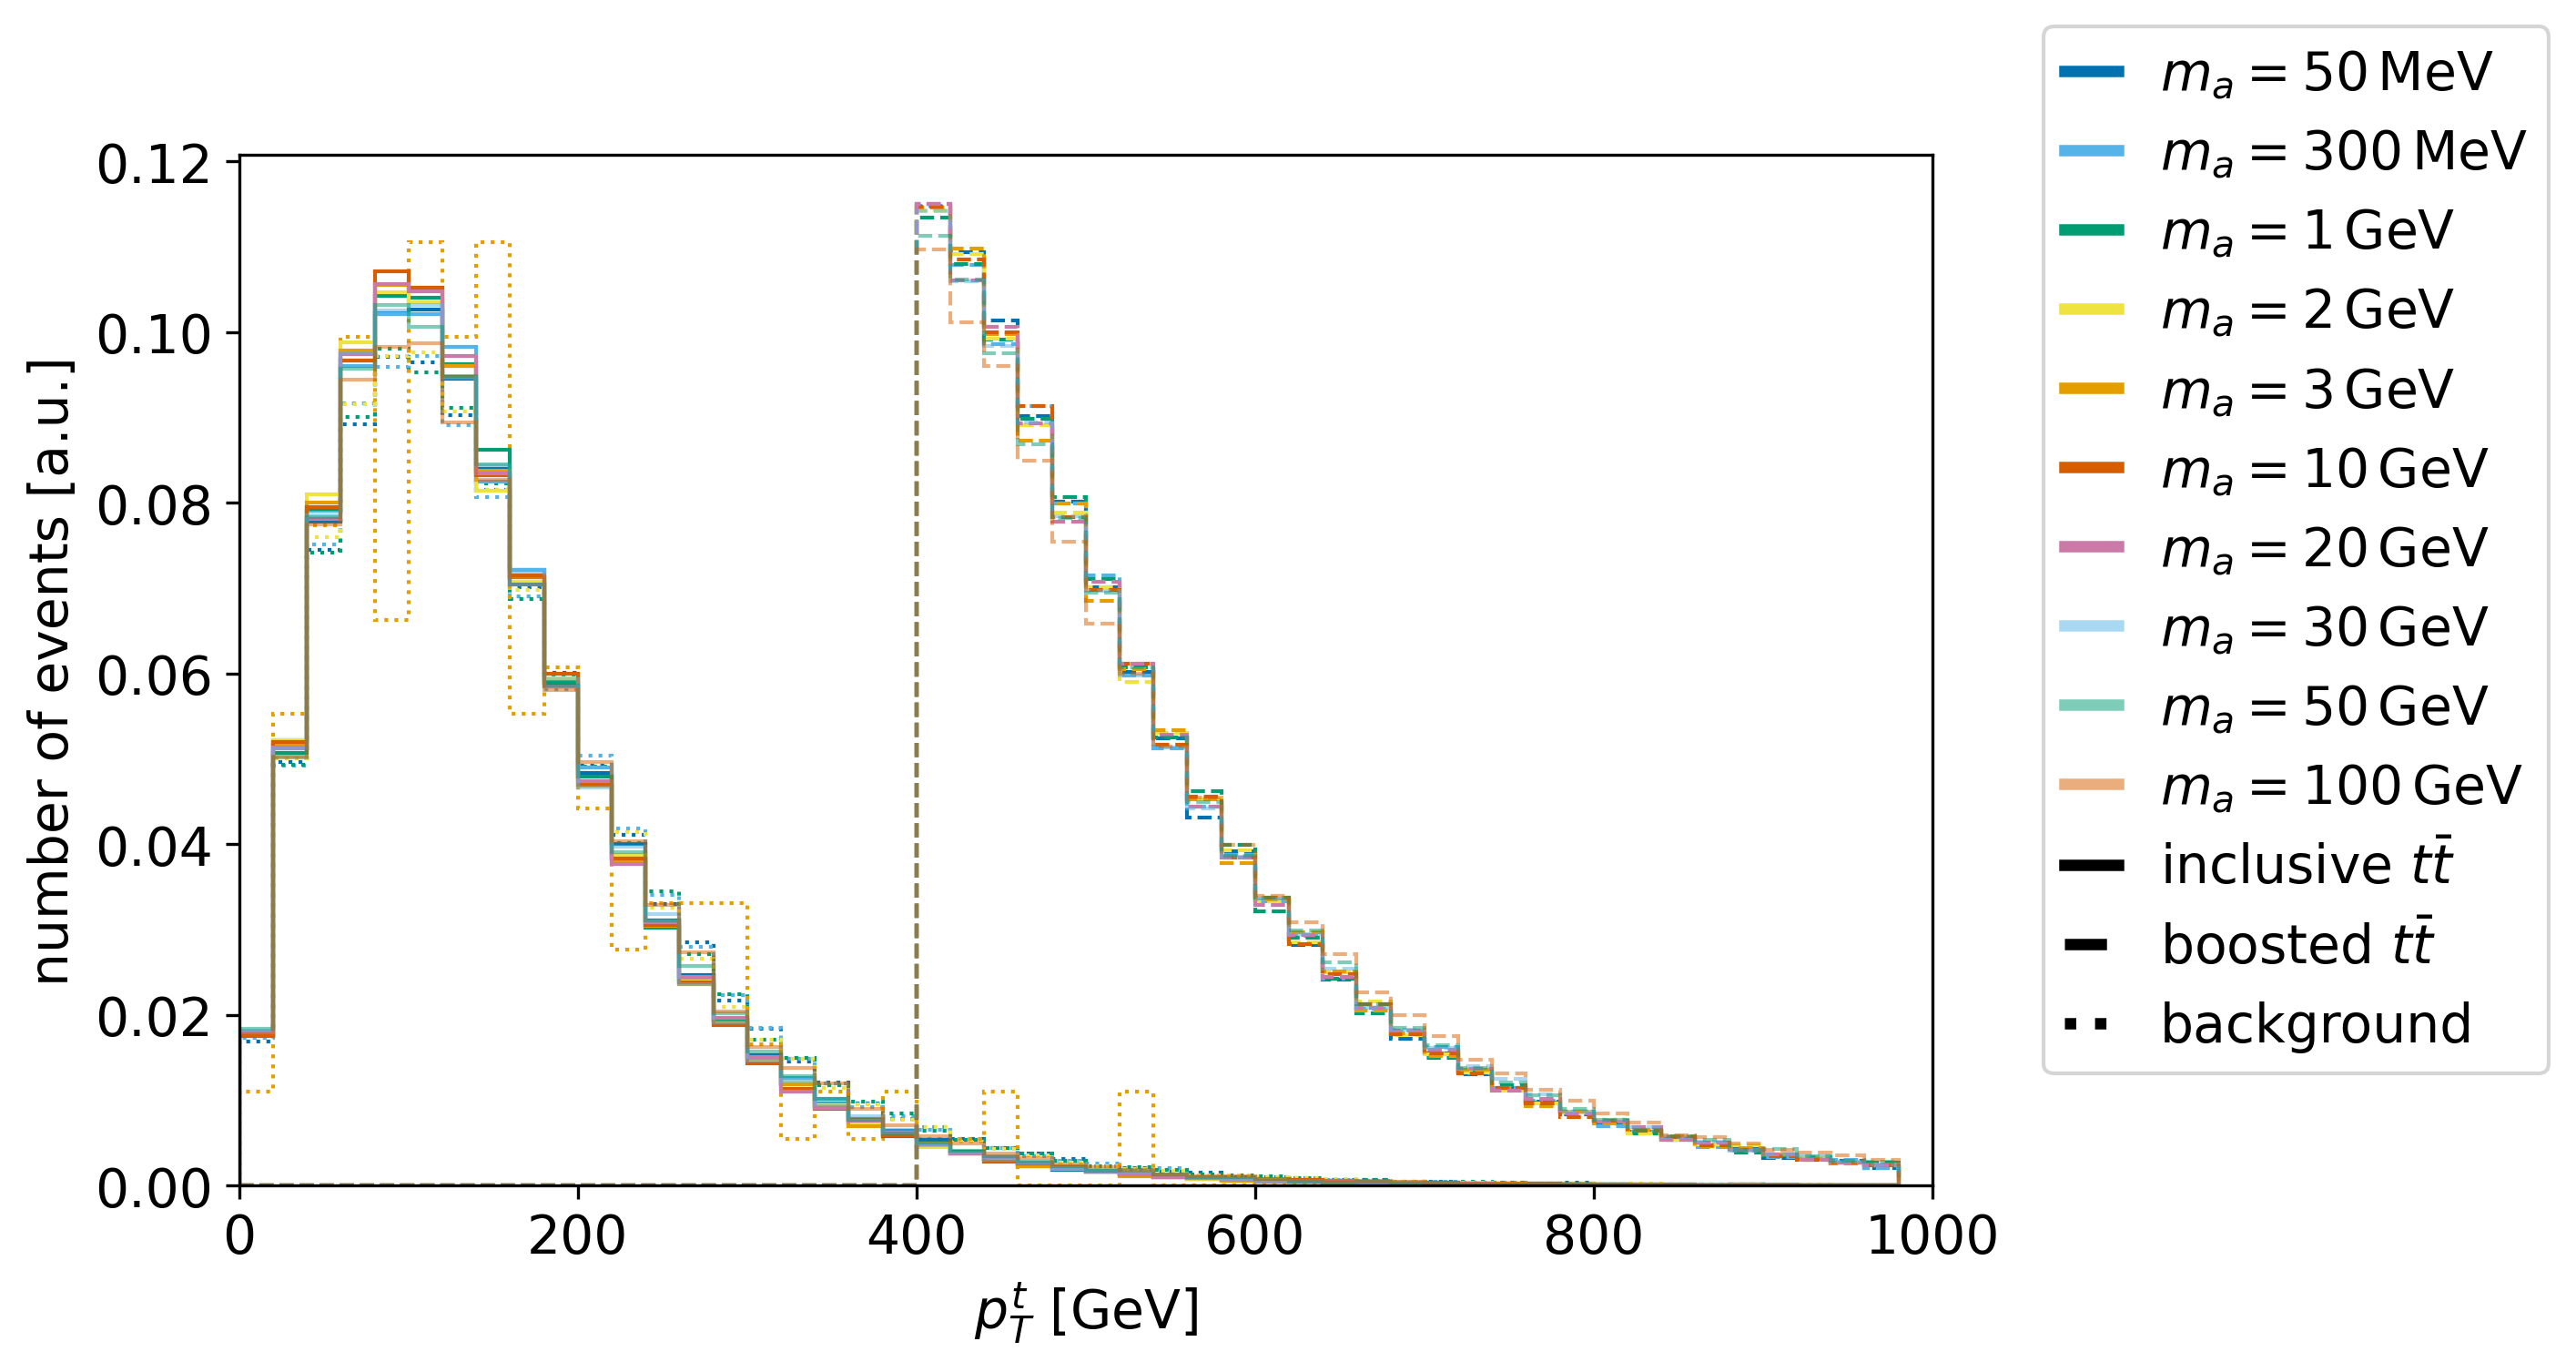

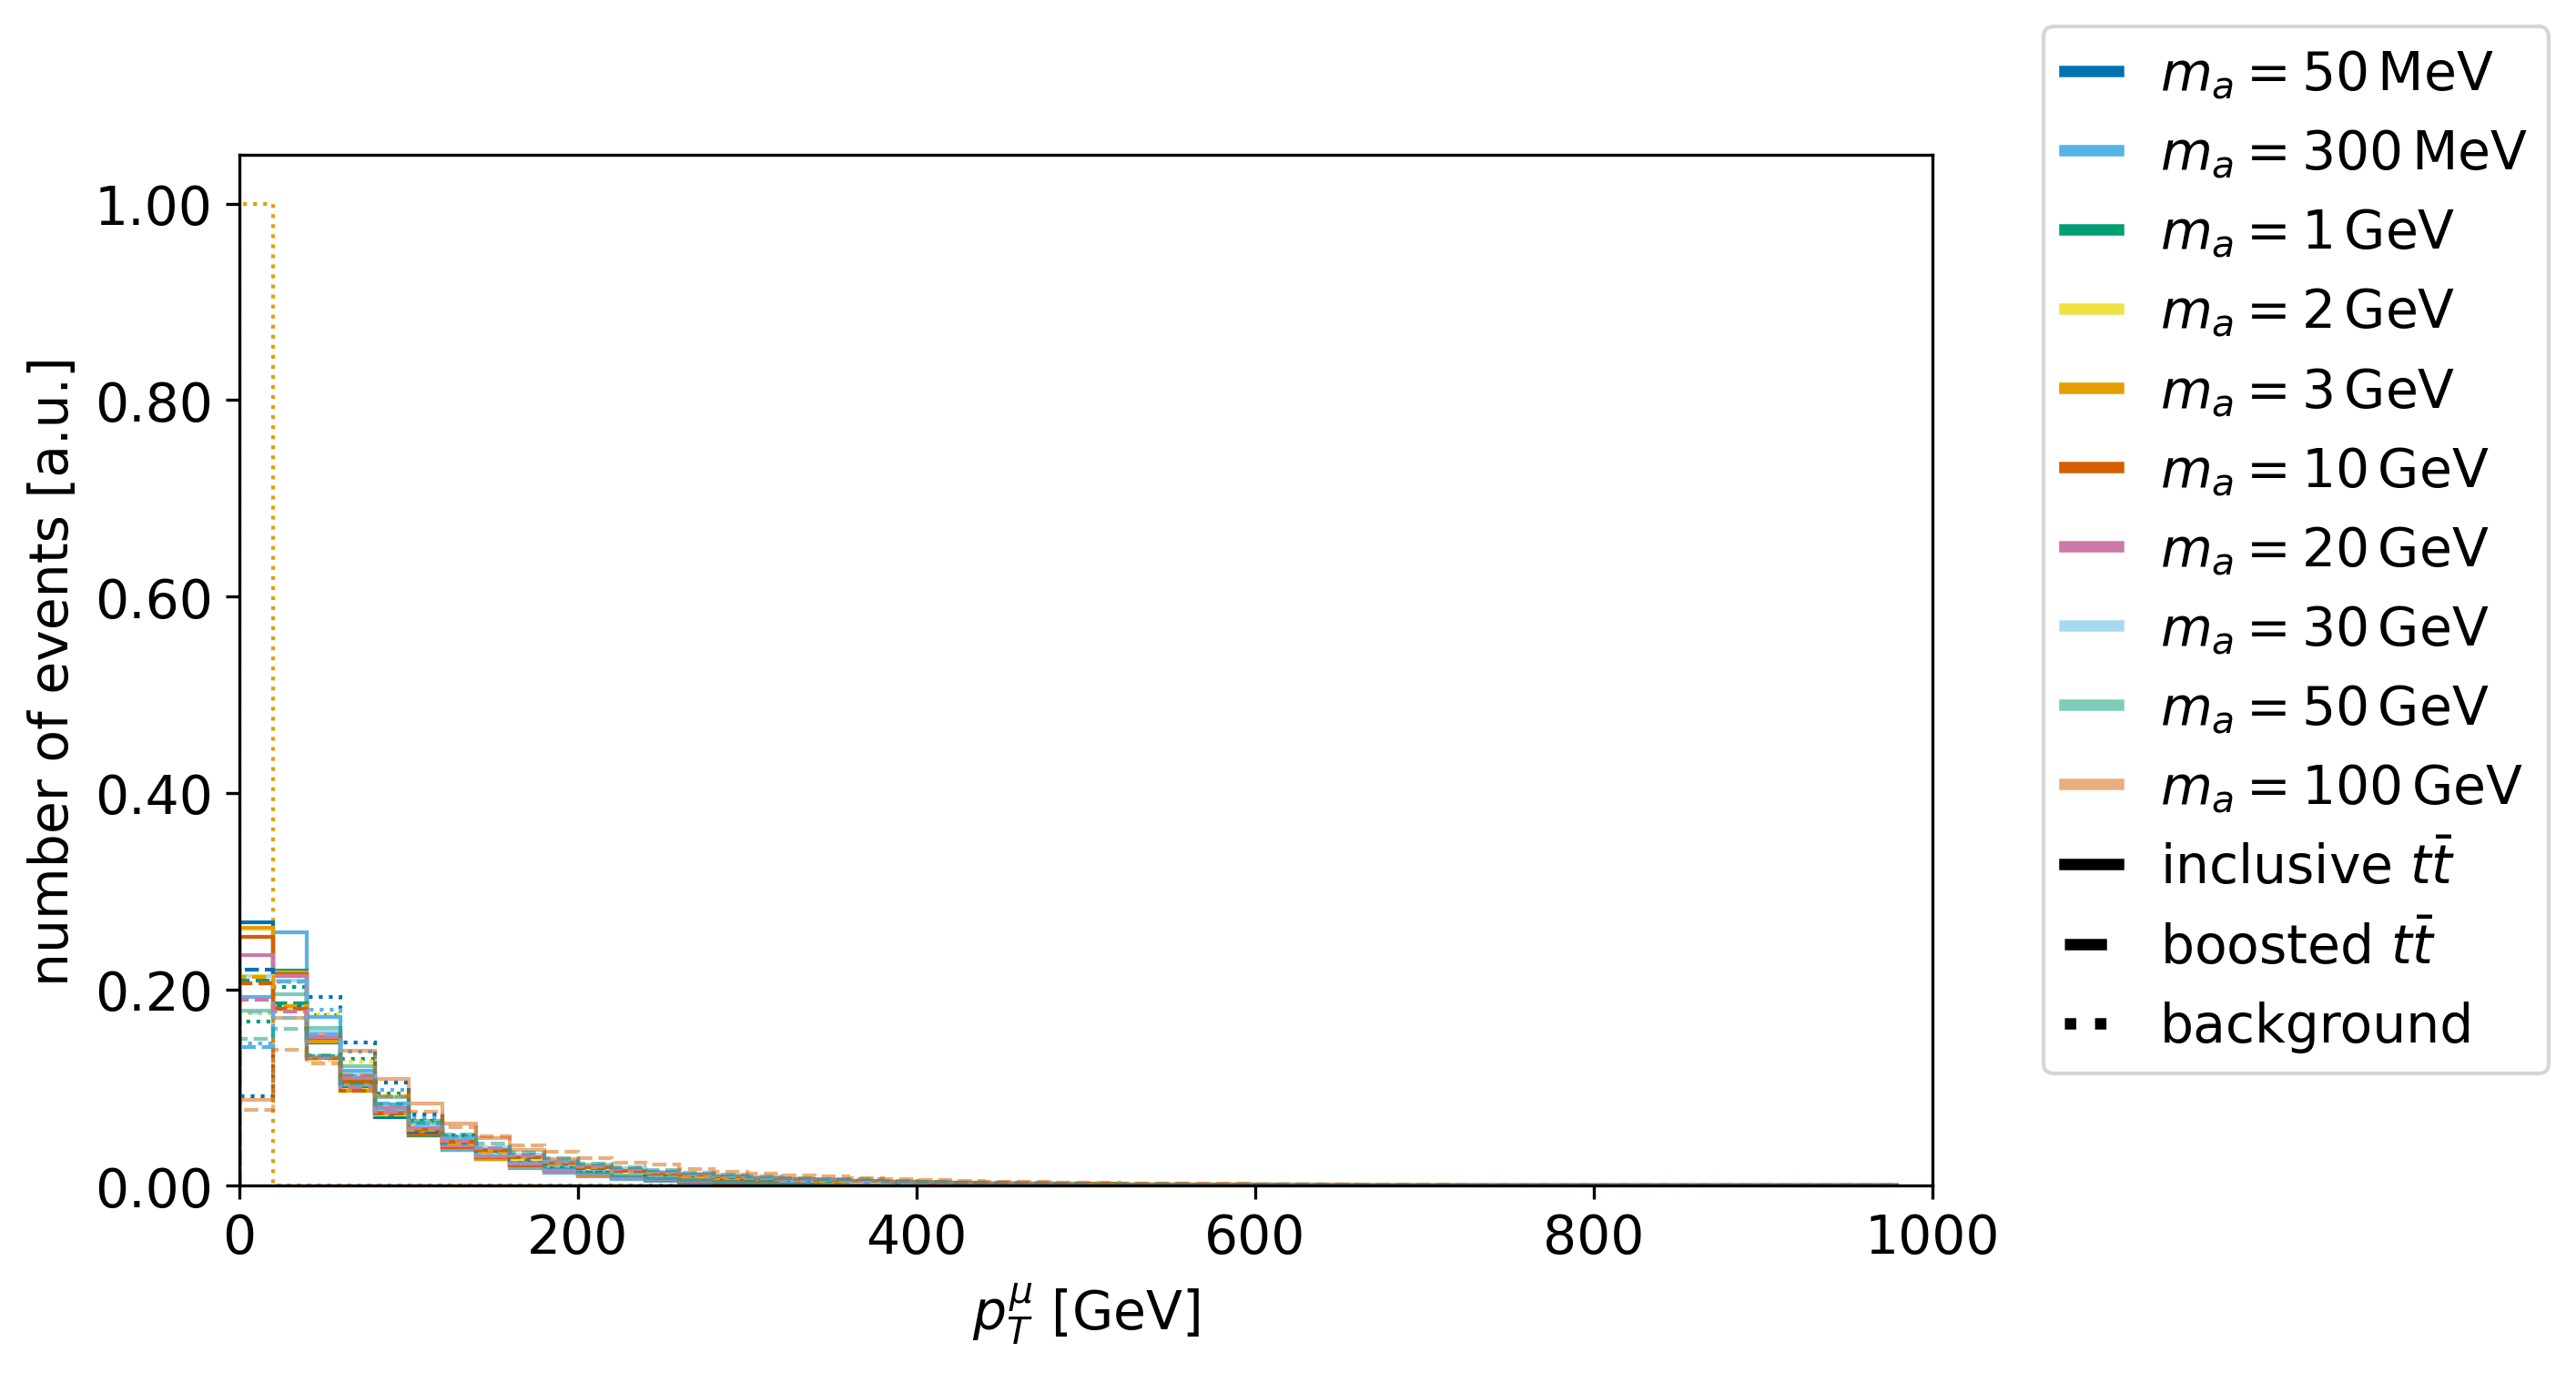

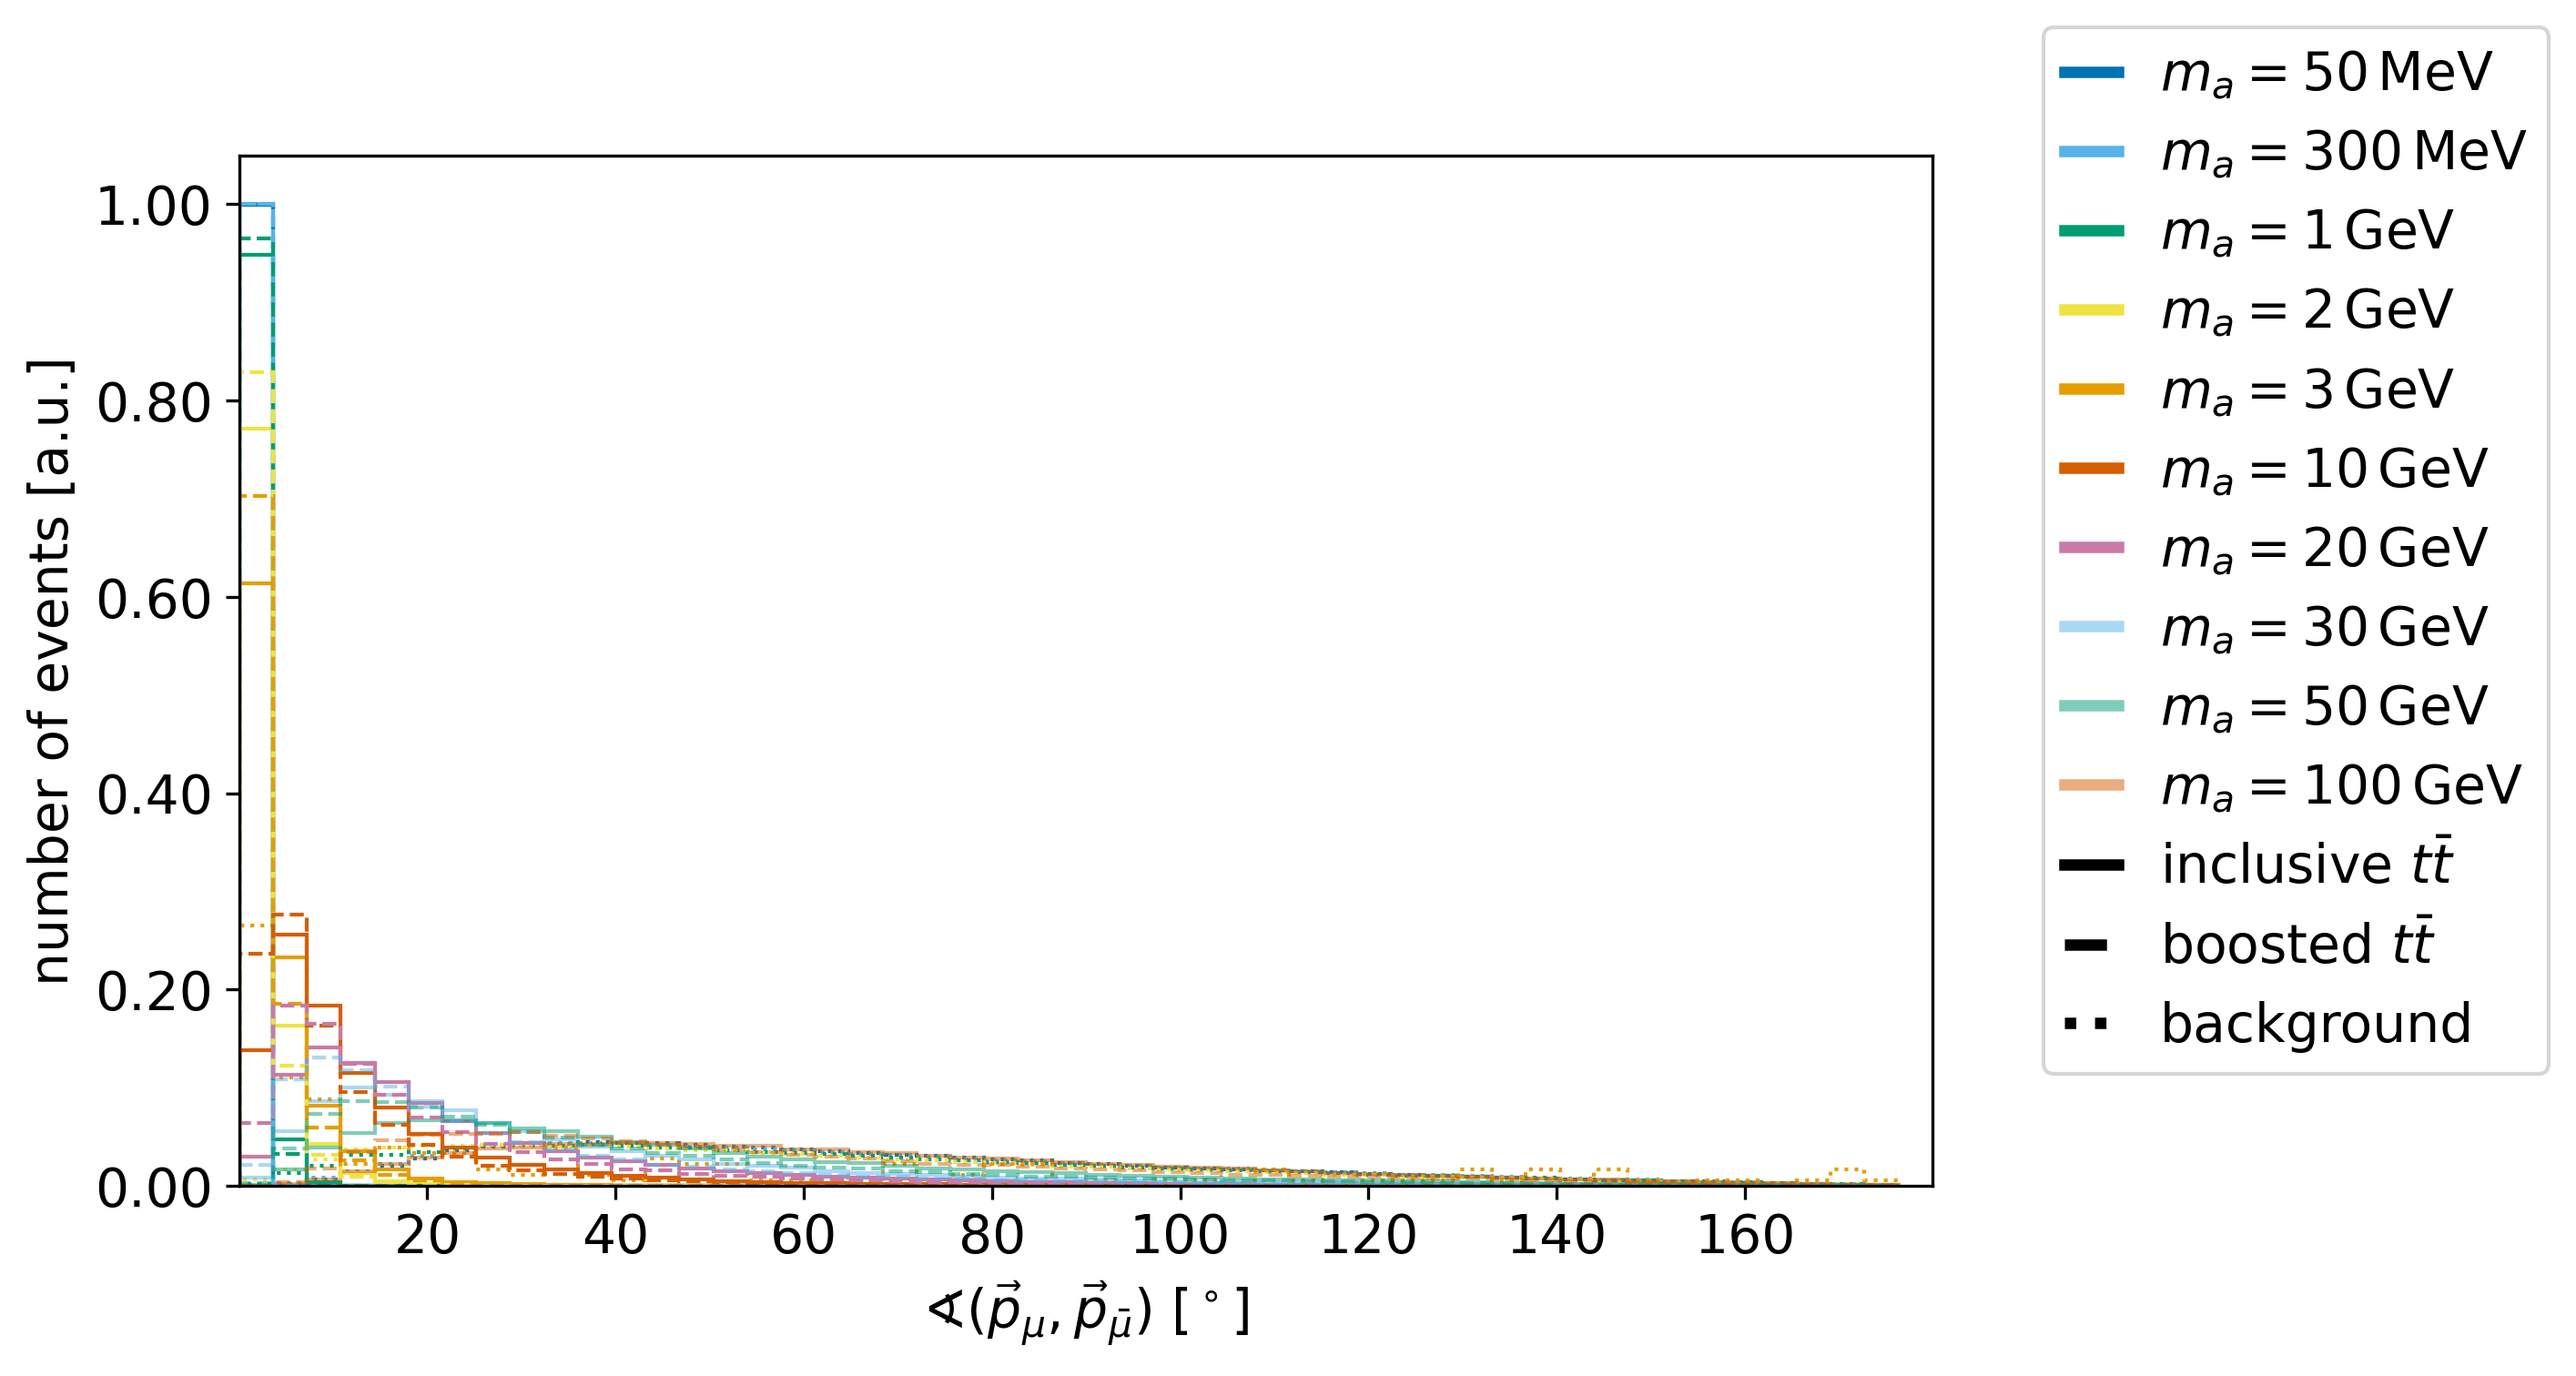

In [20]:
# kinematics of the inclusive and boosted signal events and the ttmumu+ttj background events
mypl.hist1dcomp(data("inv_mass",["top","antitop"],"incl"), data("inv_mass",["top","antitop"],"boost"), data("inv_mass",["top","antitop"],"bkg"),massLabels,dirLabel["mtt"],outputpath+"mtt_cwb_ttj_lin.png",customXlim=[0,2000],customXlabels=labels_bkg, log_scale=False)
#mypl.hist1dcomp(data("inv_mass",["top","antitop"],"incl"), data("inv_mass",["top","antitop"],"boost"), data("inv_mass",["top","antitop"],"bkg"),massLabels,dirLabel["mtt"],outputpath+"mtt_cwb_ttj_log.png",customXlim=[0,2000],customXlabels=labels_bkg, log_scale=True)
#mypl.hist1dcompden(data("inv_mass",["top","antitop"],"incl"),data("inv_mass",["top","antitop"],"bkg"),data("inv_mass",["top","antitop"],"ttj"),massLabels,dirLabel["mtt"],outputpath+"mtt_cwb_ttj_den.png",customXlim=[0,2000],customXlabels=labels_bkg)
mypl.hist1dcomp(data("oA",["top","antitop"],"incl"),data("oA",["top","antitop"],"boost"),data("oA",["top","antitop"],"bkg"),massLabels,dirLabel["oA_tat"],outputpath+"Angle_TopAntiTop_cwb_lin.png",customXlabels=labels_bkg)
#mypl.hist1dcomp(data("oA",["top","antitop"],"incl"),data("oA",["top","antitop"],"boost"),data("oA",["top","antitop"],"bkg"),massLabels,dirLabel["oA_tat"],outputpath+"Angle_TopAntiTop_cwb_log.png",customXlabels=labels_bkg, log_scale = True)
#mypl.hist1dcomp(data("oA",["top","antitop"],"incl"),data("oA",["top","antitop"],"bkg"),data("oA",["top","antitop"],"ttj"),massLabels,dirLabel["oA_tat"],outputpath+"Angle_TopAntiTop_cwb_ttj.png",customXlabels=labels_bkg)
mypl.hist1dcomp(data("pT",["top"],"incl"),data("pT",["top"],"boost"),data("pT",["top"],"bkg"),massLabels,dirLabel["pT_t"],outputpath+"Top_pT_cwb_ttj_lin.png",customXlim=[0,1000],customXlabels=labels_bkg)
#mypl.hist1dcomp(data("pT",["top"],"incl"),data("pT",["top"],"boost"),data("pT",["top"],"bkg"),massLabels,dirLabel["pT_t"],outputpath+"Top_pT_cwb_ttj_log.png",customXlim=[0,1000],customXlabels=labels_bkg, log_scale = True)
mypl.hist1dcomp(data("pT",["muon"],"incl"),data("pT",["muon"],"boost"),data("pT",["muon"],"bkg"),massLabels,dirLabel["pT_mu"],outputpath+"Muon_pT_cwb_lin.png",customXlim=[0,1000],customXlabels=labels_bkg)
#mypl.hist1dcomp(data("pT",["muon"],"incl"),data("pT",["muon"],"boost"),data("pT",["muon"],"bkg"),massLabels,dirLabel["pT_mu"],outputpath+"Muon_pT_cwb_log.png",customXlim=[0,1000],customXlabels=labels_bkg, log_scale = True)
mypl.hist1dcomp(data("oA",["antimuon","muon"],"incl"),data("oA",["antimuon","muon"],"boost"),data("oA",["antimuon","muon"],"bkg"),massLabels,dirLabel["oA_muons"],outputpath+"Angle_Muons_cwb_lin.png",customXlabels=labels_bkg)
#mypl.hist1dcomp(data("oA",["antimuon","muon"],"incl"),data("oA",["antimuon","muon"],"boost"),data("oA",["antimuon","muon"],"bkg"),massLabels,dirLabel["oA_muons"],outputpath+"Angle_Muons_cwb_log.png",customXlabels=labels_bkg, log_scale = True)


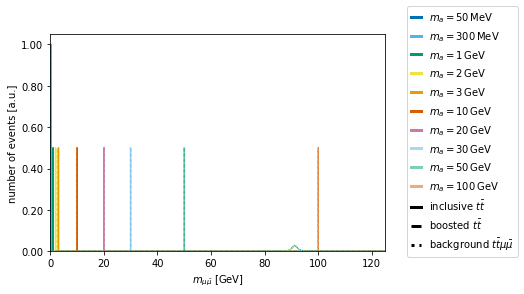

In [103]:
mypl.hist1dcomp(data("inv_mass",["muon","antimuon"],"incl"),data("inv_mass",["muon","antimuon"],"boost"),data("inv_mass",["muon","antimuon"],"bkg"),massLabels,dirLabel['mmumu'],outputpath+"muonInvariantMass_cwBkg.png",customXlabels=[r'inclusive $t\bar{t}$',r'boosted $t\bar{t}$',r'background $t\bar{t}\mu\bar{\mu}$'],nbins=1000,customXlim=[0,125])

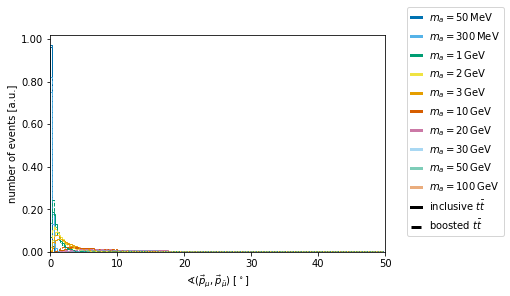

In [46]:
labels_cwb = [r'inclusive $t\bar{t}$',r'boosted $t\bar{t}$']
mypl.hist1dcomp(data("oA",["antimuon","muon"],"incl"),data("oA",["antimuon","muon"],"boost"),data("oA",["antimuon","muon"],"bkg"),massLabels,dirLabel["oA_muons"],outputpath+"Angle_Muons_cwb.png",customXlabels=labels_cwb,nbins=200,customXlim=[0,50])

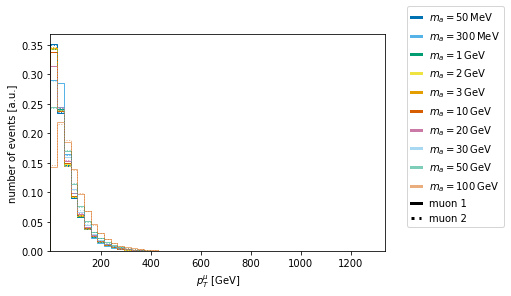

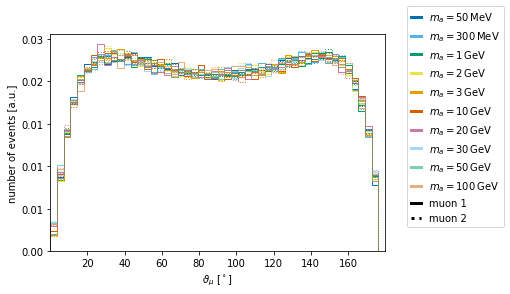

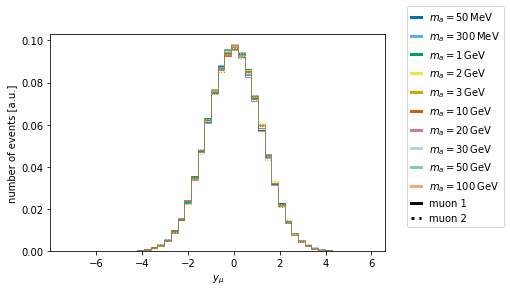

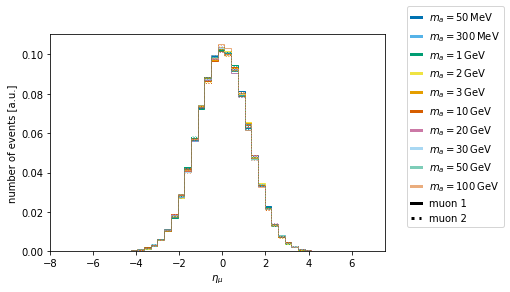

In [47]:
labels_1v2 = ['muon 1', 'muon 2']
mypl.hist1dcomp(data("pT",["muon"],"incl"),data("pT",["antimuon"],"incl"),[],massLabels,dirLabel['pT_mu'],outputpath+"pT_mu_cmp12.png",customXlabels=labels_1v2)
mypl.hist1dcomp(data("theta",["muon"],"incl"),data("theta",["antimuon"],"incl"),[],massLabels,dirLabel['theta_mu'],outputpath+"theta_mu_cmp12.png",customXlabels=labels_1v2)
mypl.hist1dcomp(data("y",["muon"],"incl"),data("y",["antimuon"],"incl"),[],massLabels,dirLabel['y_mu'],outputpath+"y_mu_cmp12.png",customXlabels=labels_1v2)
mypl.hist1dcomp(data("eta",["muon"],"incl"),data("eta",["antimuon"],"incl"),[],massLabels,dirLabel['eta_mu'],outputpath+"eta_mu_cmp12.png",customXlabels=labels_1v2)

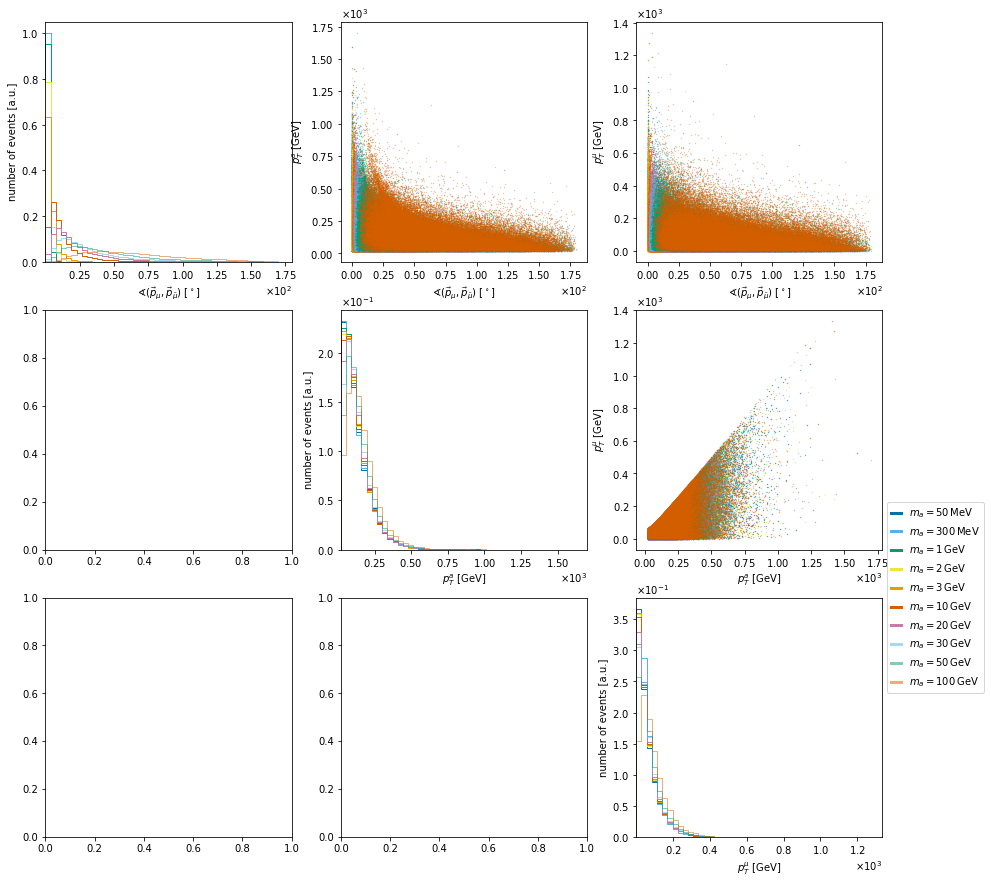

In [48]:
data_list = [data("oA",["antimuon","muon"],"incl"),data("pT",["alp"],"incl"),data("pT",["muon"],"incl")]
axesLabelKeys = ["oA_muons", "pT_a","pT_mu"]
mypl.plotMatrix(data_list, axesLabelKeys,dirLabel, massLabels, "")

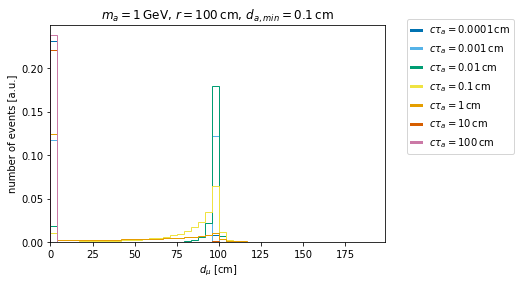

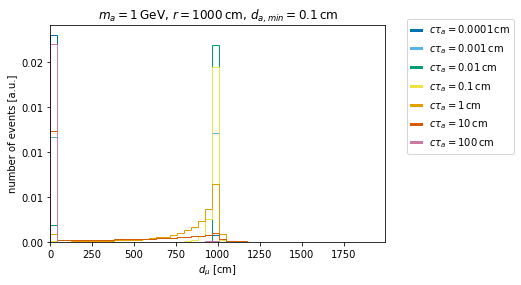

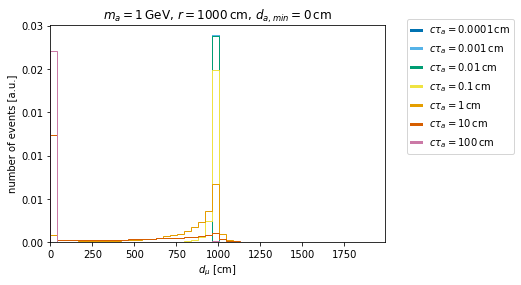

In [49]:
iMass = 2
ma = masses[iMass]
r = 100
d_a_min = 0.1
ctaus = [10**exp for exp in range(-4,3)]
mypl.hist1d([data("track_from_ctau", ["alp","muon"], ("incl",iMass), radius=r, ctau=ct, minimum_displacement=d_a_min) for ct in ctaus],
            [r"$c\tau_a=$"+str(ct)+"$\,$cm" for ct in ctaus], dirLabel["track_mu"],
            filename = outputpath+"Tracklength_at_1GeV_100_0p1.png", title=r"$m_a=$"+str(ma)+"$\,$GeV, $r=$"+str(r)+"$\,$cm, $d_{a, min}=$"+str(d_a_min)+"$\,$cm")
r = 1000
mypl.hist1d([data("track_from_ctau", ["alp","muon"], ("incl",iMass), radius=r, ctau=ct, minimum_displacement=d_a_min) for ct in ctaus],
            [r"$c\tau_a=$"+str(ct)+"$\,$cm" for ct in ctaus], dirLabel["track_mu"],
            filename = outputpath+"Tracklength_at_1GeV_1000_0p1.png", title=r"$m_a=$"+str(ma)+"$\,$GeV, $r=$"+str(r)+"$\,$cm, $d_{a, min}=$"+str(d_a_min)+"$\,$cm")
d_a_min = 0
mypl.hist1d([data("track_from_ctau", ["alp","muon"], ("incl",iMass), radius=r, ctau=ct, minimum_displacement=d_a_min) for ct in ctaus],
            [r"$c\tau_a=$"+str(ct)+"$\,$cm" for ct in ctaus], dirLabel["track_mu"],
            filename = outputpath+"Tracklength_at_1GeV_1000_0.png", title=r"$m_a=$"+str(ma)+"$\,$GeV, $r=$"+str(r)+"$\,$cm, $d_{a, min}=$"+str(d_a_min)+"$\,$cm")

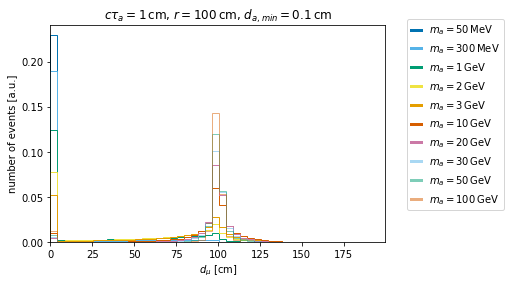

In [50]:
mypl.hist1d(data("track_from_ctau",["alp","muon"],"incl",radius=100,ctau=1,minimum_displacement=0.1),massLabels,dirLabel["track_mu"],outputpath+"Tracklength_at_100_1_0p1.png", title=r"$c\tau_a=1\,$cm, $r=100\,$cm, $d_{a, min}=0.1\,$cm")

/afs/cern.ch/user/l/lrygaard/private/ALPpheno/ttalps/physics.py:253: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
/afs/cern.ch/user/l/lrygaard/private/ALPpheno/ttalps/physics.py:234: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
/afs/cern.ch/user/l/lrygaard/private/ALPpheno/ttalps/physics.py:182: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
/afs/cern.ch/user/l/lrygaard/private/ALPpheno/ttalps/lib64/python3.6/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/afs/cern.ch/user/l/lrygaard/private/ALPpheno/ttalps/lib64/python3.6/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


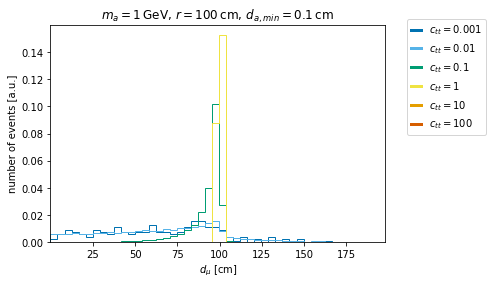

In [51]:
iMass = 2
ma = masses[iMass]
r = 100
d_a_min = 0.1
ctts = [10**exp for exp in range(-3,3)]
mypl.hist1d([[date for date in data("track_from_ctau", ["alp", "muon"], ("incl", iMass), radius=r, ctau=ph.ctaua(ma, ctt/2, ctt/2, math.pi*1000), minimum_displacement=d_a_min) if date>0] for ctt in ctts],
            [r"$c_{tt}=$"+str(ctt) for ctt in ctts], dirLabel["track_mu"],
            title=r"$m_a=$"+str(ma)+"$\,$GeV, $r=$"+str(r)+"$\,$cm, $d_{a, min}=$"+str(d_a_min)+"$\,$cm")

In [52]:
def plot_tracklength_parameter_space_ctau(r, min_disp, filename=""):
    xs = []
    ys = []
    rates = []
    tracks = []
    tracklengths = {}
    ctaus = [10**exp for exp in range(-6,8)]
    for ctau in ctaus:
        tracklengths[ctau] = data("track_from_ctau", ["alp", "muon"], "incl",
                          radius=r, ctau=ctau, minimum_displacement=min_disp)
    for iMass in range(1,len(masses)-1):
        for ctau in ctaus:
            ma = masses[iMass]
            xs.append(ma)
            ys.append(ctau)
            tracklength_list = tracklengths[ctau][iMass]
            rates.append(sum([1 for track in tracklength_list if track>0])/len(tracklength_list))
            tracks.append(np.mean([track for track in tracklength_list if track>0]))
    rates = np.array(rates)/max(rates)*plt.rcParams['lines.markersize']*10
    mypl.scatter_w_c(xs, ys, tracks, rates, dirLabel["ma"], dirLabel["ctau"], dirLabel["track_mu"], log=False, filename=filename, title=r"$r=$"+str(r)+"$\,$cm, $d_{a, min}=$"+str(min_disp)+"$\,$cm")
    
def plot_tracklength_parameter_space_ctt(r, min_disp, filename=""):
    xs = []
    ys = []
    rates = []
    Lambda = 4*math.pi*1000
    tracklengths = {}
    tracks = []
    ctts = [10**exp for exp in np.arange(-7,2.5,0.5)]
    for iMass in range(1,len(masses)-1):
        for ctt in ctts:
            ma = masses[iMass]
            with aux.HiddenPrints():
                ct = ph.ctaua(ma, ctt/2, ctt/2, Lambda)
            xs.append(ma)
            ys.append(ctt)
            tracklength_list = data("track_from_ctau", ["alp", "muon"], ("incl",iMass),
                                    radius=r, ctau=ct, minimum_displacement=min_disp)
            rates.append(sum([1 for track in tracklength_list if track>0])/len(tracklength_list))
            tracks.append(np.mean([track for track in tracklength_list if track>0]))
    rates = np.array(rates)/max(rates)*plt.rcParams['lines.markersize']*10
    mypl.scatter_w_c(xs, ys, tracks, rates, dirLabel["ma"], dirLabel["ctt"], dirLabel["track_mu"], log=False, filename=filename, title=r"$r=$"+str(r)+"$\,$cm, $d_{a, min}=$"+str(min_disp)+"$\,$cm")

/afs/cern.ch/user/l/lrygaard/private/ALPpheno/ttalps/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/afs/cern.ch/user/l/lrygaard/private/ALPpheno/ttalps/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


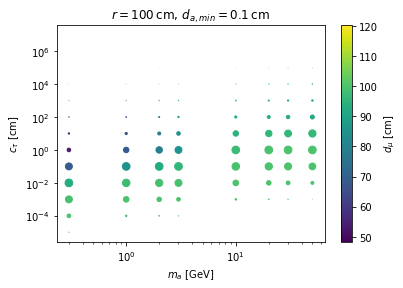

In [53]:
plot_tracklength_parameter_space_ctau(100,0.1,outputpath+"ma_ctau_tracklength_0p1_100.png")

/afs/cern.ch/user/l/lrygaard/private/ALPpheno/ttalps/physics.py:182: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
/afs/cern.ch/user/l/lrygaard/private/ALPpheno/ttalps/physics.py:253: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
/afs/cern.ch/user/l/lrygaard/private/ALPpheno/ttalps/physics.py:234: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
/afs/cern.ch/user/l/lrygaard/private/ALPpheno/ttalps/physics.py:215: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


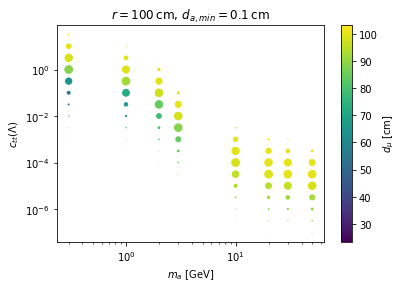

In [54]:
plot_tracklength_parameter_space_ctt(100,0.1,outputpath+"ma_ctt_tracklength_0p1_100.png")

In [55]:
def plot_rates_ctau(dataset="incl", detector="tracker", filename=None, title=None):
    xs = []
    ys = []
    rates = []
    ctaus = [10**exp for exp in range(-6,8)]
    for iMass in range(1,len(masses)-1):
        for ct in ctaus:
            ma = masses[iMass]
            xs.append(ma)
            ys.append(ct)
            rates.append(
                rate((dataset,iMass), [
                    ((lambda x: x[0]>cms[detector]["tl-2d"] or x[1]>cms[detector]["tl-z"]), "track_from_ctau", ["alp","muon"],
                     {'radius': cms[detector]["r"], 'ctau': ct, 'minimum_displacement': cms[detector]["min_disp"], 'direction': "2d-z", 'z': cms[detector]["z"]}),
                    ((lambda x: x>cms[detector]["pT-mu"]),"pT", ["muon"]),
                    ((lambda x: x>cms[detector]["pT-mu"]),"pT", ["antimuon"]),
                    ((lambda x: abs(x)<cms[detector]["eta"]),"eta", ["muon"]),
                    ((lambda x: abs(x)<cms[detector]["eta"]),"eta", ["antimuon"])
                ]))
    mypl.scatter_w_c(xs, ys, rates, 20, dirLabel["ma"], dirLabel["ctau"], "#", log=True, filename=filename, title=title)

def plot_rates_ctt(dataset="incl", detector="tracker", filename=None, title=None):
    xs = []
    ys = []
    rates = []
    Lambda = 4*math.pi*1000
    ctts = [10**exp for exp in np.arange(-7,2.5,0.5)]
    for iMass in range(1,len(masses)-1):
        for ctt in ctts:
            ma = masses[iMass]
            with aux.HiddenPrints():
                ct = ph.ctaua(ma, ctt/2, ctt/2, Lambda)
            xs.append(ma)
            ys.append(ctt)
            rates.append(
                rate((dataset,iMass), [
                    ((lambda x: x[0]>cms[detector]["tl-2d"] or x[1]>cms[detector]["tl-z"]), "track_from_ctau", ["alp","muon"],
                     {'radius': cms[detector]["r"], 'ctau': ct, 'minimum_displacement': cms[detector]["min_disp"], 'direction': "2d-z", 'z': cms[detector]["z"]}),
                    ((lambda x: x>cms[detector]["pT-mu"]),"pT", ["muon"]),
                    ((lambda x: x>cms[detector]["pT-mu"]),"pT", ["antimuon"]),
                    ((lambda x: abs(x)<cms[detector]["eta"]),"eta", ["muon"]),
                    ((lambda x: abs(x)<cms[detector]["eta"]),"eta", ["antimuon"])
                ]))
    mypl.scatter_w_c(xs, ys, rates, 20, dirLabel["ma"], dirLabel["ctt"], "#", log=True, filename=filename, title=title)

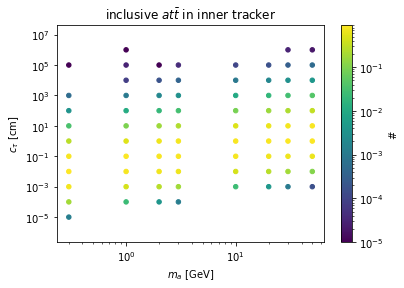

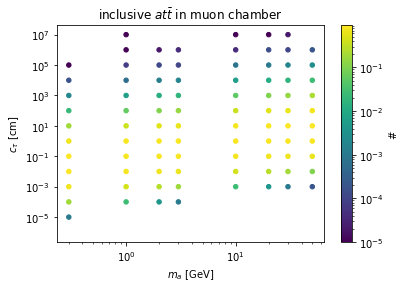

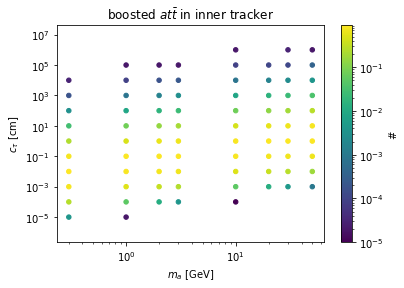

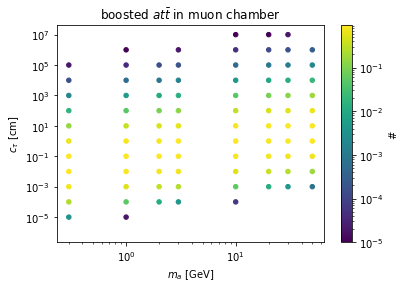

In [56]:
plot_rates_ctau(dataset="incl", detector="tracker", title=r"inclusive $at\bar{t}$ in inner tracker", filename=outputpath+"ma_ctau_rates_incl_tracker.png")
plot_rates_ctau(dataset="incl", detector="muon", title=r"inclusive $at\bar{t}$ in muon chamber", filename=outputpath+"ma_ctau_rates_incl_muon.png")
plot_rates_ctau(dataset="boost", detector="tracker", title=r"boosted $at\bar{t}$ in inner tracker", filename=outputpath+"ma_ctau_rates_boost_tracker.png")
plot_rates_ctau(dataset="boost", detector="muon", title=r"boosted $at\bar{t}$ in muon chamber", filename=outputpath+"ma_ctau_rates_boost_muon.png")

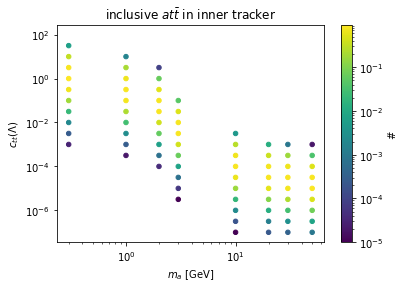

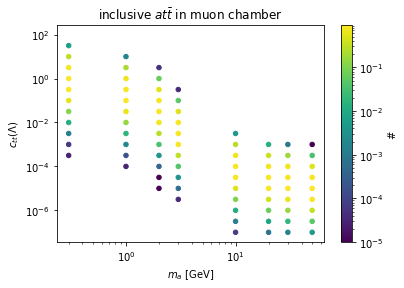

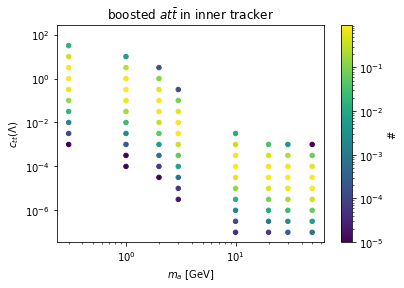

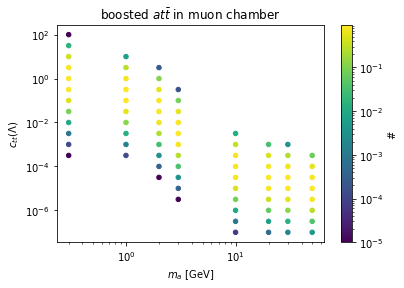

In [57]:
plot_rates_ctt(dataset="incl", detector="tracker", title=r"inclusive $at\bar{t}$ in inner tracker", filename=outputpath+"ma_ctt_rates_incl_tracker.png")
plot_rates_ctt(dataset="incl", detector="muon", title=r"inclusive $at\bar{t}$ in muon chamber", filename=outputpath+"ma_ctt_rates_incl_muon.png")
plot_rates_ctt(dataset="boost", detector="tracker", title=r"boosted $at\bar{t}$ in inner tracker", filename=outputpath+"ma_ctt_rates_boost_tracker.png")
plot_rates_ctt(dataset="boost", detector="muon", title=r"boosted $at\bar{t}$ in muon chamber", filename=outputpath+"ma_ctt_rates_boost_muon.png")